In [4]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.5 MB/s eta 0:00:00


In [6]:
pip install shap lime catboost xgboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=78b3981fd731036e627f9b1adcba43c6ebecff02736e20fbd879677be184181c
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


mfcc without smote

Reading label files...
Visualizing class distribution...


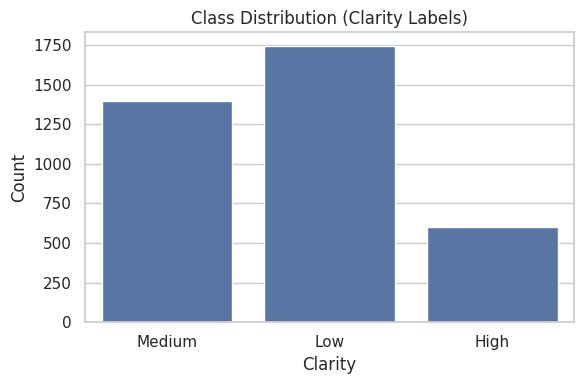

Skipping SMOTE. Using original training data...
Original training class distribution: [ 424 1208  983]

Training classifiers...

KNN Performance:
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}


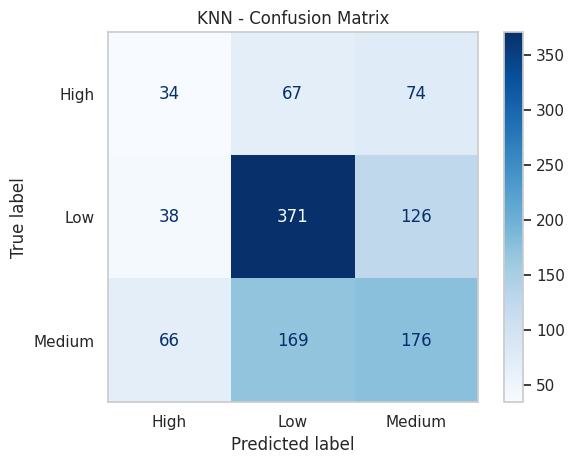

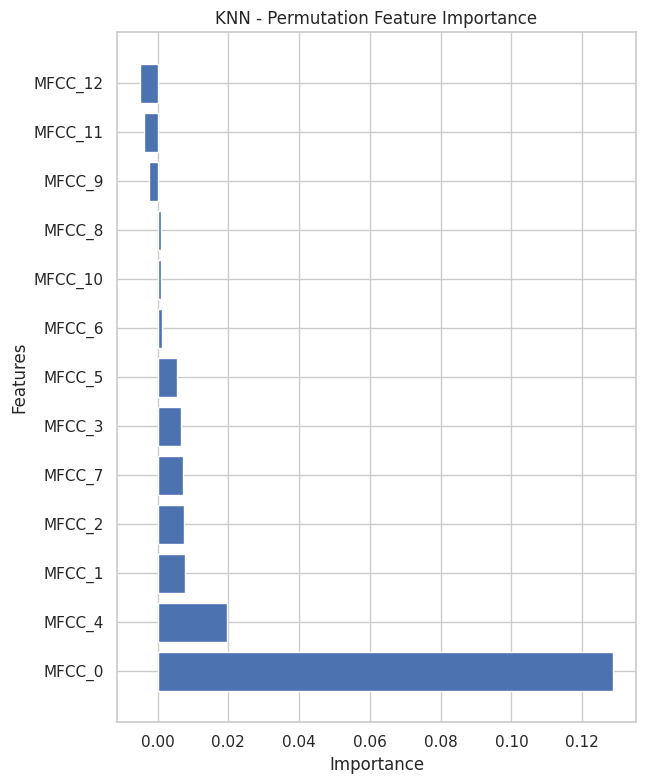


Logistic Regression Performance:
Best Parameters: {'C': 1, 'solver': 'lbfgs'}


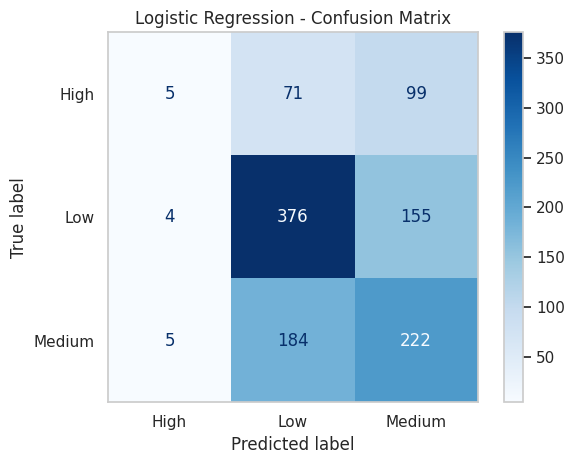

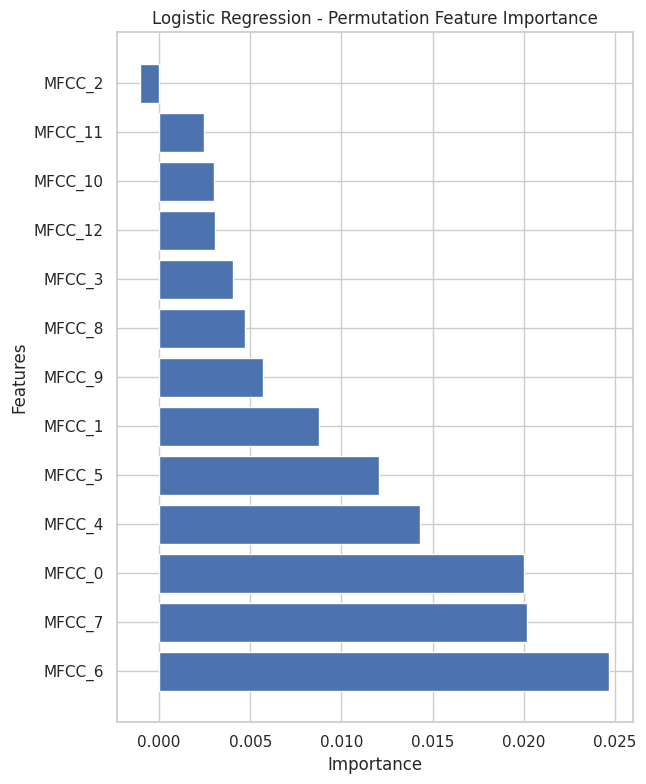


AdaBoost Performance:
Best Parameters: {'learning_rate': 0.1, 'n_estimators': 200}


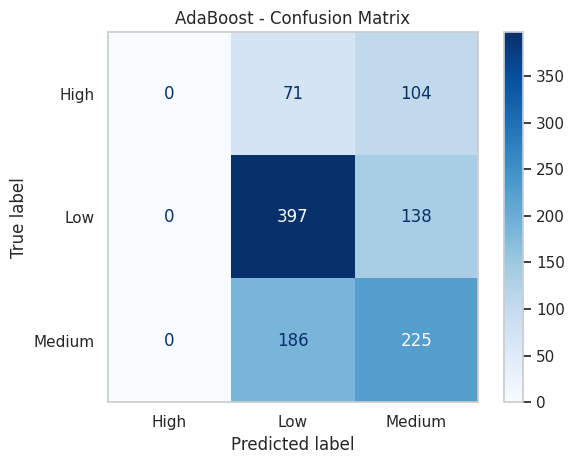

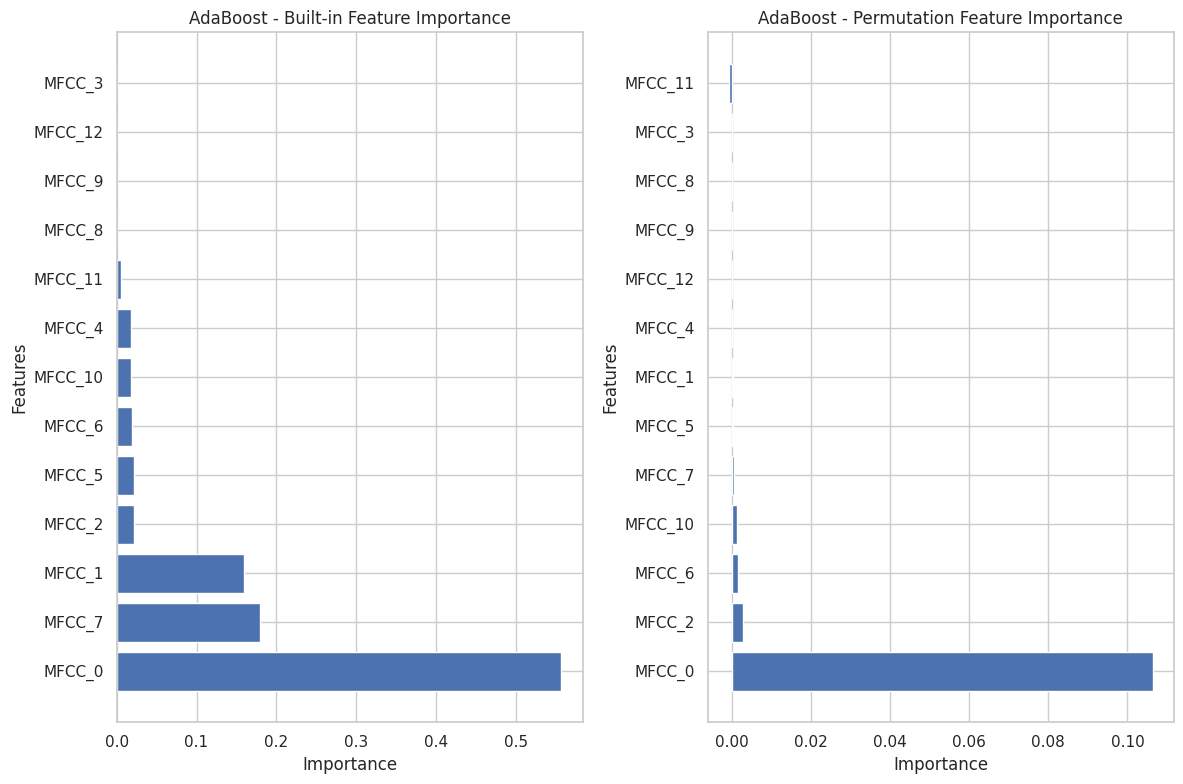


CatBoost Performance:
Best Parameters: {'depth': 8, 'iterations': 100, 'learning_rate': 0.1}
Error training CatBoost: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

Decision Tree Performance:


Traceback (most recent call last):
  File "<ipython-input-14-70993deae9dd>", line 357, in <cell line: 0>
    target_names = le.inverse_transform(np.unique(np.concatenate([y_test, y_test_pred])))
                                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}


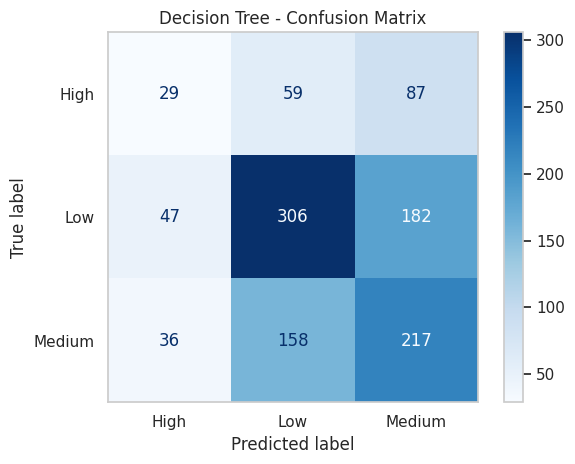

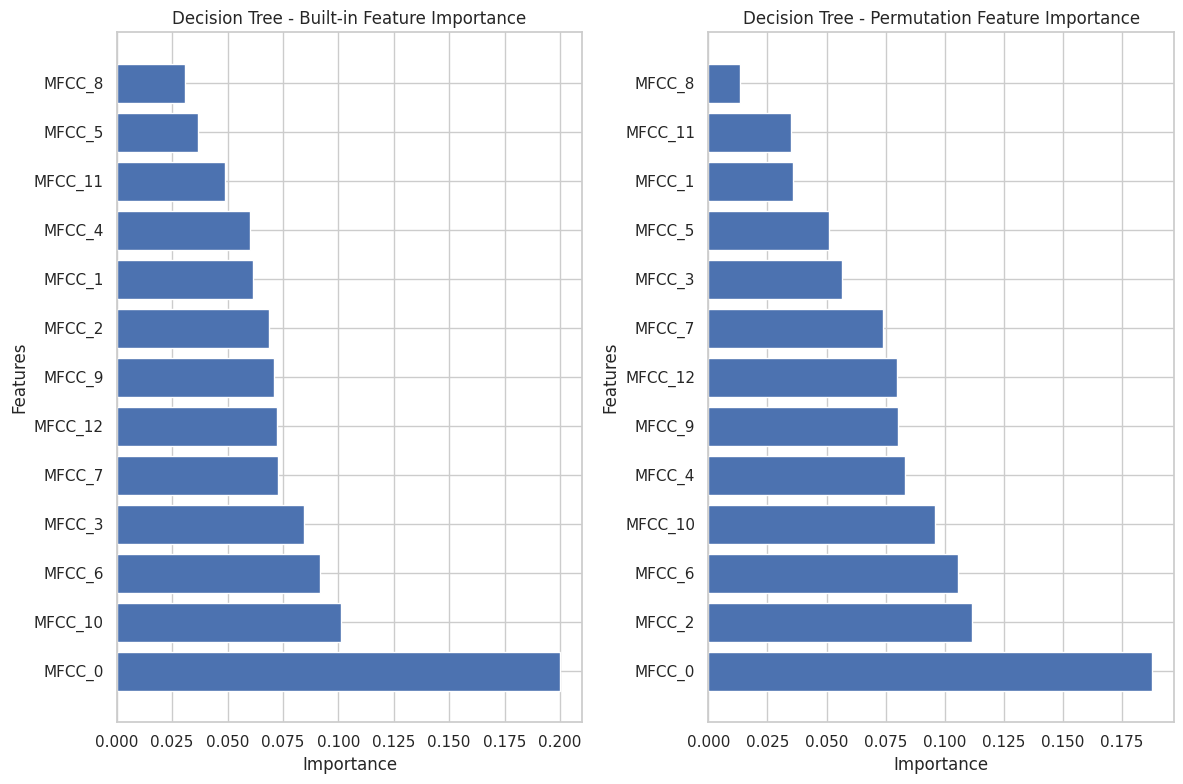


XGBoost Performance:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


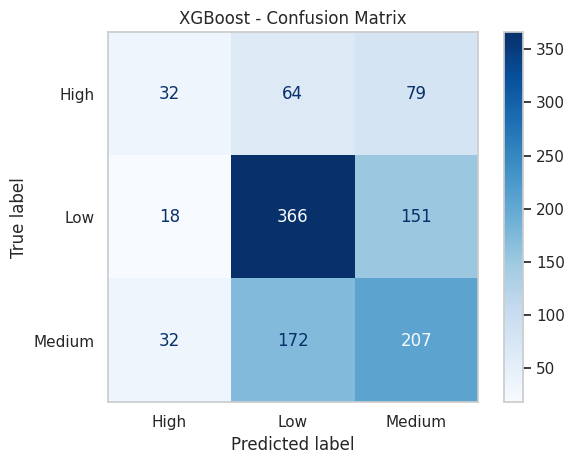

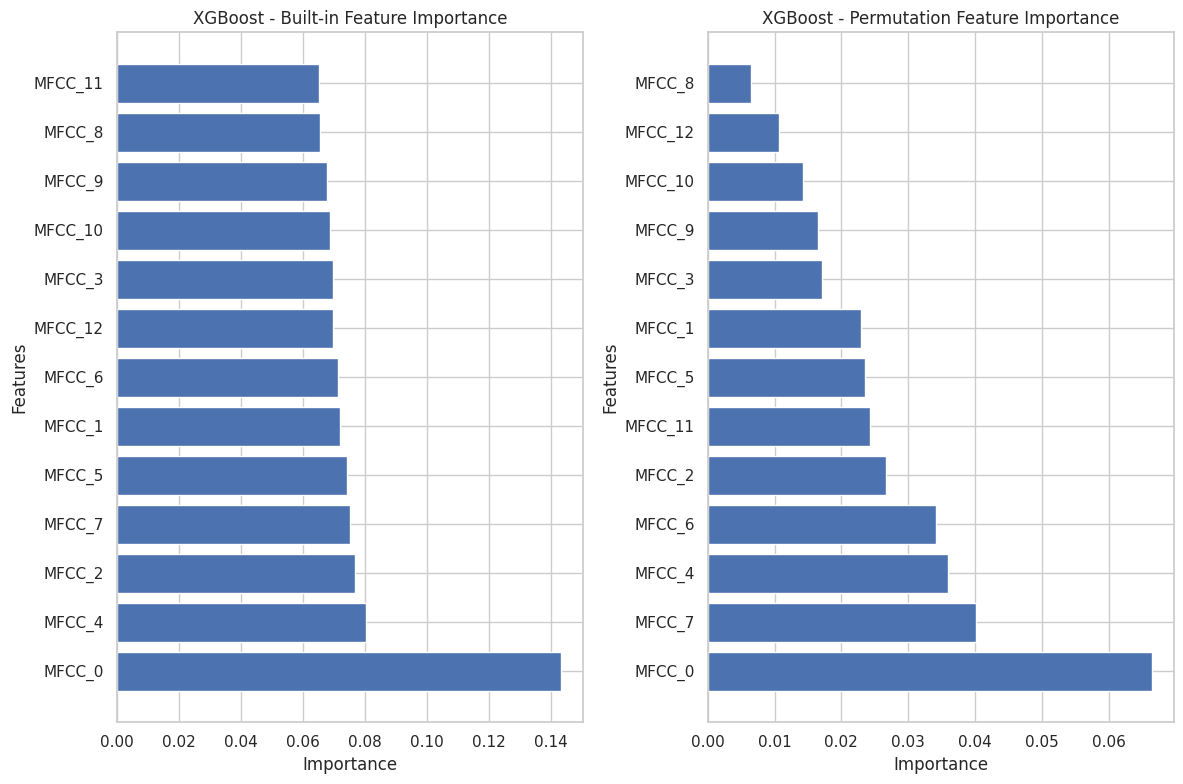


MLP Performance:
Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}


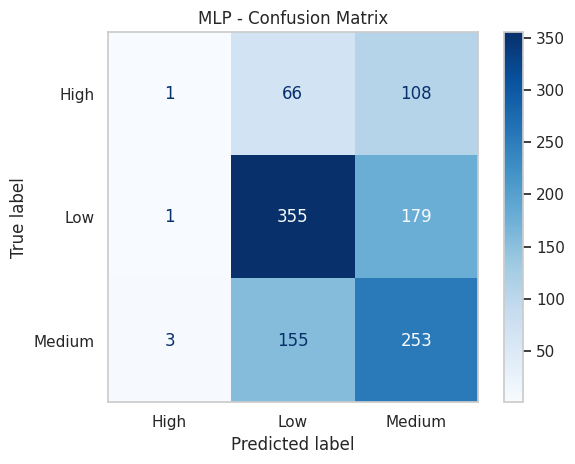

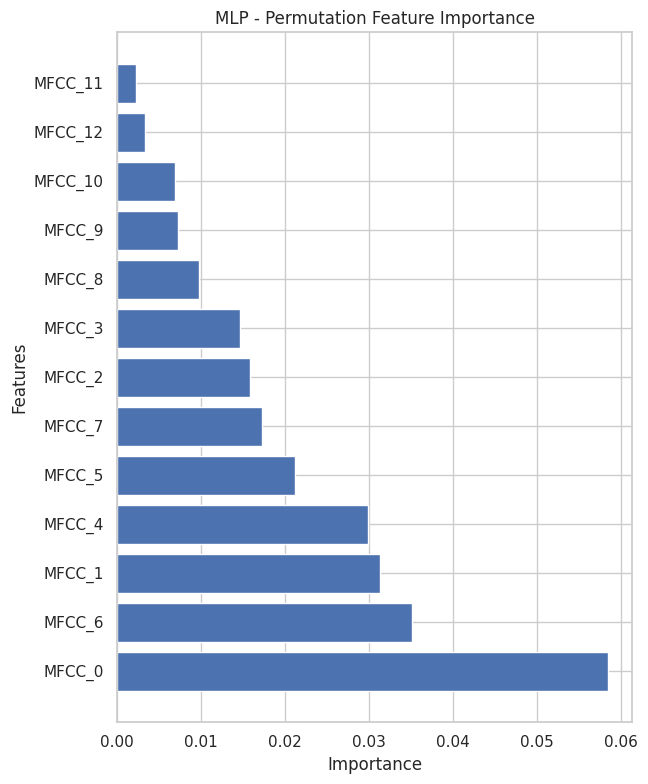


Random Forest Performance:
Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


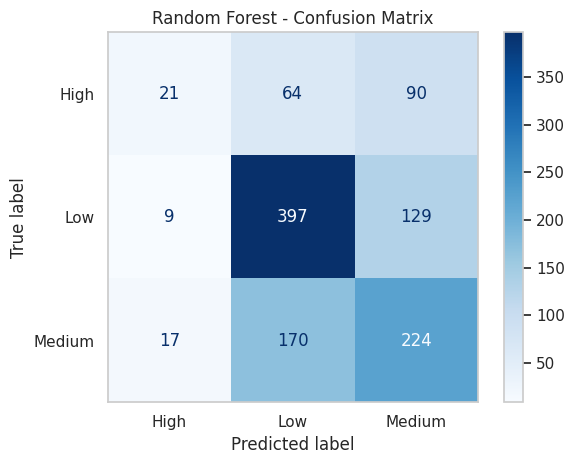

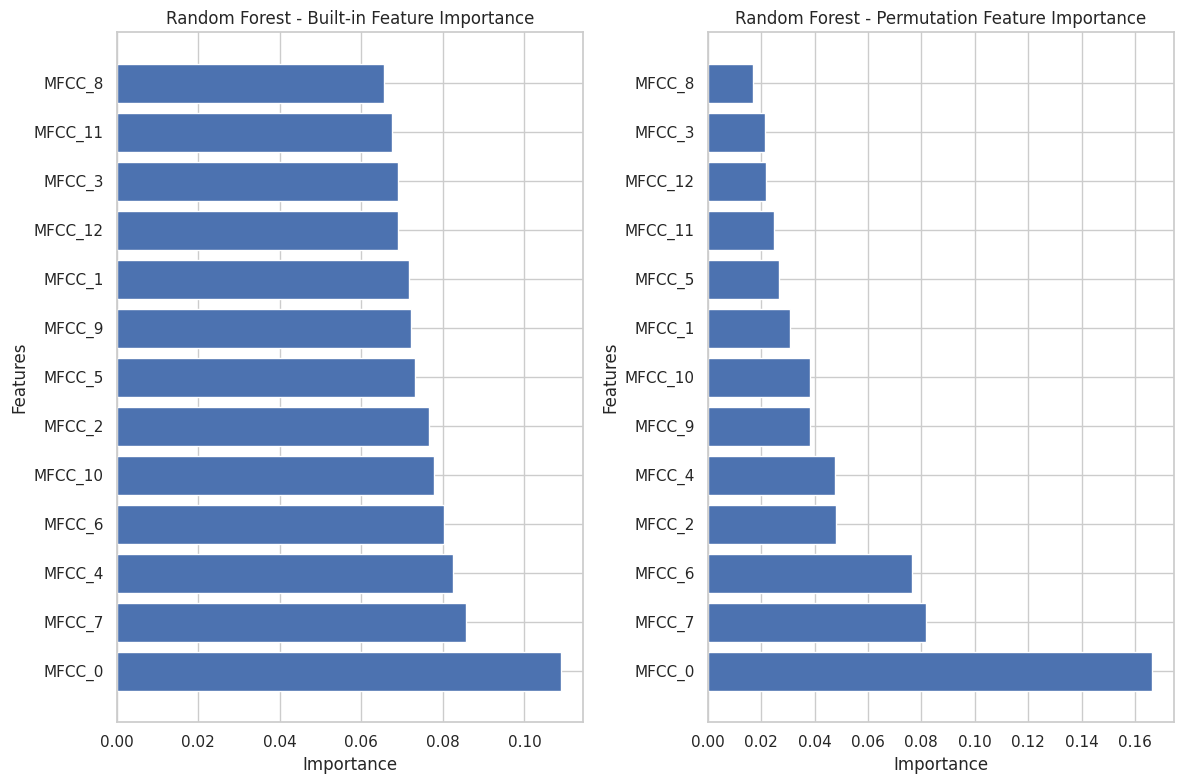


Naïve Bayes Performance:
Best Parameters: {'var_smoothing': 1e-09}


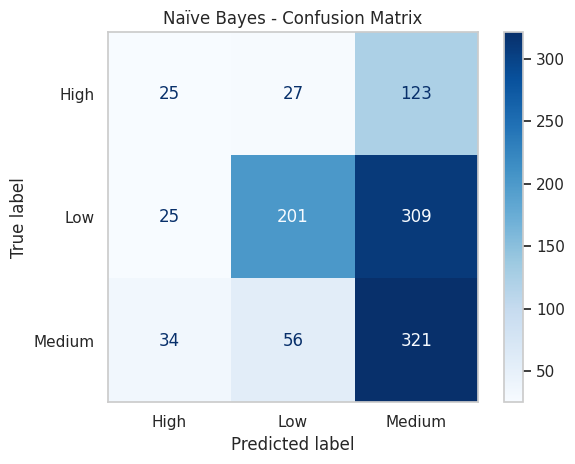

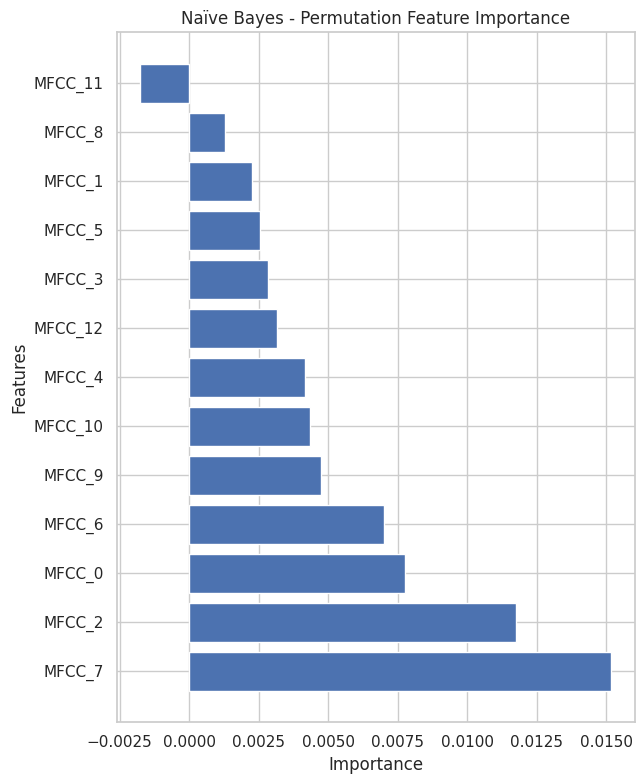

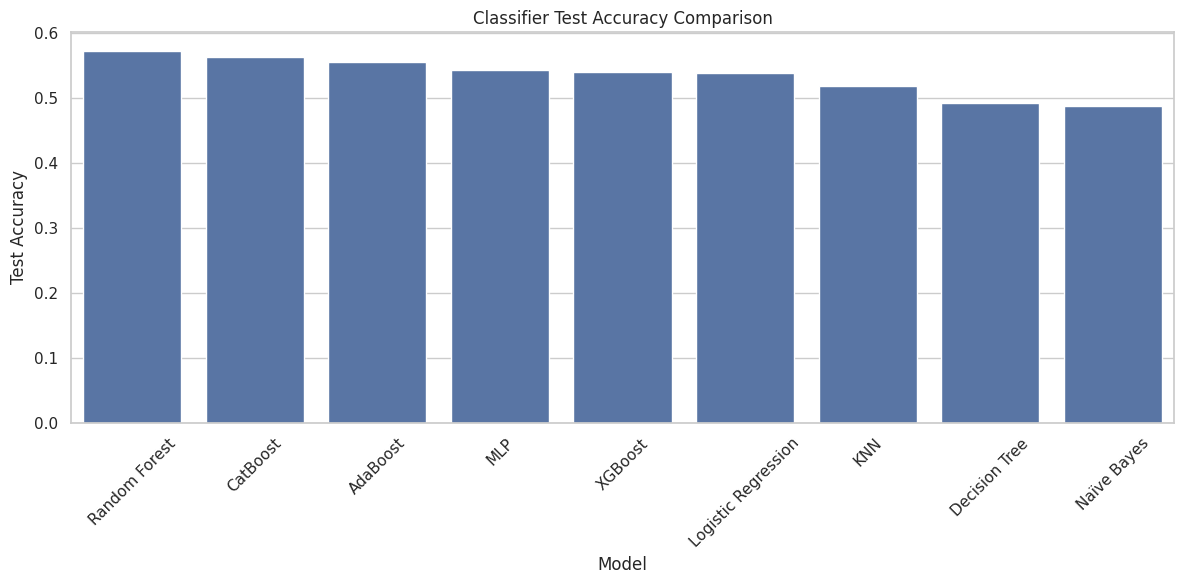


Final Metrics Comparison Table:
              Model  Train Accuracy  Test Accuracy  Precision   Recall  F1 Score
                KNN        0.648566       0.518287   0.501777 0.518287  0.507989
Logistic Regression        0.548375       0.537913   0.511133 0.537913  0.499584
           AdaBoost        0.537667       0.554862   0.466353 0.554862  0.506615
           CatBoost        0.826769       0.563782   0.542898 0.563782  0.539062
      Decision Tree        0.749522       0.492417   0.483359 0.492417  0.485007
            XGBoost        0.990057       0.539697   0.524748 0.539697  0.525126
                MLP        0.574761       0.543265   0.497138 0.543265  0.501806
      Random Forest        0.988910       0.572703   0.555407 0.572703  0.546859
        Naïve Bayes        0.495602       0.487957   0.540531 0.487957  0.466610
Results saved to 'classification_results_summary.xlsx'


Analyzing SHAP values for best model: Random Forest (Test Accuracy: 0.5727)

Calculating SHAP values

<Figure size 800x670 with 0 Axes>

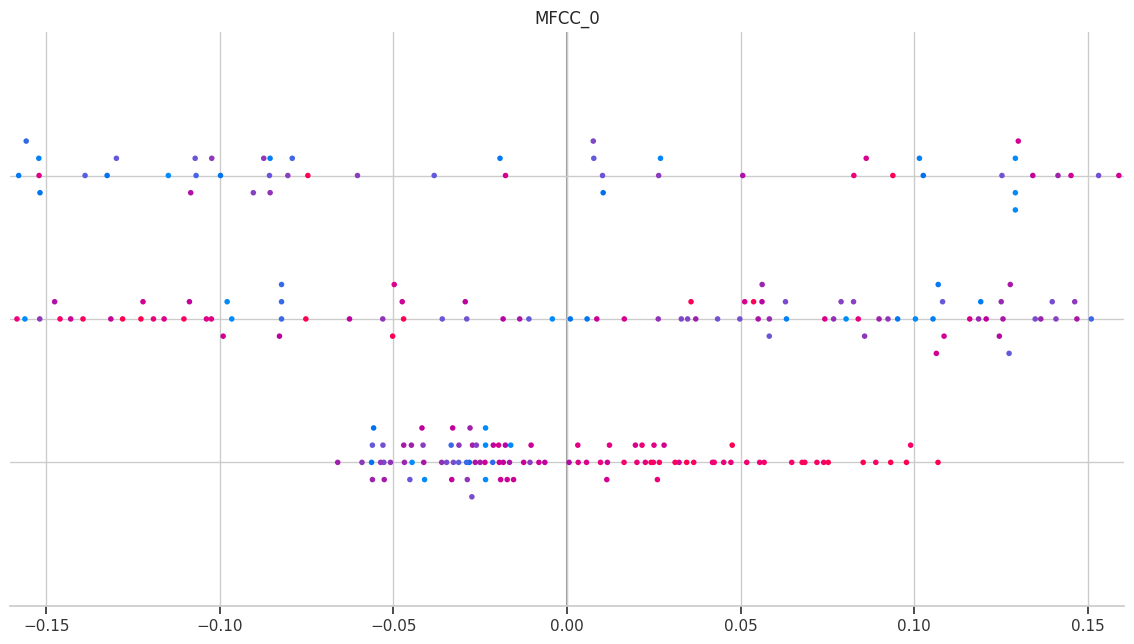

Error in SHAP analysis for Random Forest: Must pass 2-d input. shape=(100, 13, 3)
MFCC mode values saved to 'mfcc_mode_features_saved.csv'


Traceback (most recent call last):
  File "<ipython-input-14-70993deae9dd>", line 152, in analyze_shap_values
    shap_df = pd.DataFrame(shap_values, columns=feature_names)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/frame.py", line 827, in __init__
    mgr = ndarray_to_mgr(
          ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/internals/construction.py", line 314, in ndarray_to_mgr
    values = _ensure_2d(values)
             ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/internals/construction.py", line 592, in _ensure_2d
    raise ValueError(f"Must pass 2-d input. shape={values.shape}")
ValueError: Must pass 2-d input. shape=(100, 13, 3)


In [14]:
import librosa
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance

# Function to extract and plot feature importance for all models
def plot_feature_importance(model, name, X, X_train, y_train, feature_names):
    plt.figure(figsize=(12, 8))

    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.subplot(1, 2, 1)
        plt.title(f"{name} - Built-in Feature Importance")
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.ylabel('Features')
        plt.xlabel('Importance')

        # Save feature importance to CSV
        importance_df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": importances
        }).sort_values(by="Importance", ascending=False)
        importance_df.to_csv(f"feature_importance_{name.replace(' ', '_')}_builtin.csv", index=False)

    try:
        result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1)
        perm_importance = result.importances_mean
        indices = np.argsort(perm_importance)[::-1]

        plt.subplot(1, 2, 2)
        plt.title(f"{name} - Permutation Feature Importance")
        plt.barh(range(len(indices)), perm_importance[indices], align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.ylabel('Features')
        plt.xlabel('Importance')

        perm_importance_df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": perm_importance
        }).sort_values(by="Importance", ascending=False)
        perm_importance_df.to_csv(f"feature_importance_{name.replace(' ', '_')}_permutation.csv", index=False)
    except Exception as e:
        print(f"Could not compute permutation importance for {name}: {e}")

    plt.tight_layout()
    plt.show()

    return {"built_in": importances if hasattr(model, "feature_importances_") else None,
            "permutation": perm_importance if 'perm_importance' in locals() else None}


# Function to calculate and visualize SHAP values for the best model
def analyze_shap_values(model, X_train, X_test, feature_names, model_name):
    print(f"\nCalculating SHAP values for {model_name}...")
    plt.figure(figsize=(12, 10))

    try:
        # Create explainer appropriate for the model type
        if isinstance(model, (XGBClassifier, RandomForestClassifier, AdaBoostClassifier, DecisionTreeClassifier, CatBoostClassifier)):
            # Tree-based models
            explainer = shap.TreeExplainer(model)
            # Sample from test set for faster computation
            sample_size = min(100, X_test.shape[0])
            X_sample = shap.sample(X_test, sample_size, random_state=42)
            # Calculate SHAP values
            shap_values = explainer.shap_values(X_sample)

            # For multi-class, shap_values is a list of arrays, one per class
            if isinstance(shap_values, list):
                # Plot summary for first class (can be changed to other classes)
                plt.subplot(2, 1, 1)
                plt.title(f"SHAP Summary Plot for {model_name} - Class 0")
                shap.summary_plot(shap_values[0], X_sample, feature_names=feature_names, plot_type="bar", show=False)
                plt.subplot(2, 1, 2)
                shap.summary_plot(shap_values[0], X_sample, feature_names=feature_names, show=False)
            else:
                plt.subplot(2, 1, 1)
                plt.title(f"SHAP Summary Plot for {model_name}")
                shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar", show=False)
                plt.subplot(2, 1, 2)
                shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)

        elif isinstance(model, (LogisticRegression, SVC)):
            # Linear models
            explainer = shap.LinearExplainer(model, X_train)
            sample_size = min(100, X_test.shape[0])
            X_sample = shap.sample(X_test, sample_size, random_state=42)
            shap_values = explainer.shap_values(X_sample)

            plt.subplot(2, 1, 1)
            plt.title(f"SHAP Summary Plot for {model_name}")
            shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar", show=False)
            plt.subplot(2, 1, 2)
            shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)

        else:
            # KernelExplainer works with any model but is slower
            # Create a smaller background dataset for KernelExplainer
            background = shap.sample(X_train, 100, random_state=42)
            explainer = shap.KernelExplainer(model.predict_proba, background)
            sample_size = min(50, X_test.shape[0])  # Smaller sample due to computational intensity
            X_sample = shap.sample(X_test, sample_size, random_state=42)
            shap_values = explainer.shap_values(X_sample)

            if isinstance(shap_values, list):
                plt.subplot(2, 1, 1)
                plt.title(f"SHAP Summary Plot for {model_name} - Class 0")
                shap.summary_plot(shap_values[0], X_sample, feature_names=feature_names, plot_type="bar", show=False)
                plt.subplot(2, 1, 2)
                shap.summary_plot(shap_values[0], X_sample, feature_names=feature_names, show=False)
            else:
                plt.subplot(2, 1, 1)
                plt.title(f"SHAP Summary Plot for {model_name}")
                shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar", show=False)
                plt.subplot(2, 1, 2)
                shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)

        plt.tight_layout()
        plt.show()

        # Create SHAP dependence plots for top features
        if isinstance(shap_values, list):
            # For multi-class, use first class shap values
            shap_df = pd.DataFrame(shap_values[0], columns=feature_names)
        else:
            shap_df = pd.DataFrame(shap_values, columns=feature_names)

        # Get top 5 features by mean absolute SHAP value
        top_features = shap_df.abs().mean().sort_values(ascending=False).head(5).index

        plt.figure(figsize=(15, 10))
        for i, feature in enumerate(top_features):
            plt.subplot(2, 3, i+1)
            if isinstance(shap_values, list):
                shap.dependence_plot(feature, shap_values[0], X_sample, feature_names=feature_names,
                                    show=False, ax=plt.gca())
            else:
                shap.dependence_plot(feature, shap_values, X_sample, feature_names=feature_names,
                                    show=False, ax=plt.gca())

        plt.tight_layout()
        plt.suptitle(f"SHAP Dependence Plots for Top Features - {model_name}", y=1.02)
        plt.show()

    except Exception as e:
        print(f"Error in SHAP analysis for {model_name}: {e}")
        import traceback
        traceback.print_exc()


# Visuals
sns.set(style="whitegrid")
n_mfcc = 13

# Load MFCC mode features
mfcc_df = pd.read_csv("/content/mfcc_mean_features (2).csv")
if mfcc_df.empty:
    raise ValueError("MFCC feature file is empty or not loaded correctly.")

# Load labels from Excel
print("Reading label files...")
excel_files = glob.glob("output_*_s.xlsx")
if not excel_files:
    raise FileNotFoundError("No Excel files found.")

labels_list = []
for excel_file in excel_files:
    try:
        df = pd.read_excel(excel_file)
        df = df[["File Name", "Clarity"]]
        df["File Name"] = df["File Name"].astype(str)
        labels_list.append(df)
    except Exception as e:
        print(f"Error reading {excel_file}: {e}")

labels_df = pd.concat(labels_list, ignore_index=True)

# Normalize filenames
def normalize_filename(name):
    return os.path.splitext(name.replace("_s", "s").replace(" ", "").lower())[0]

mfcc_df["File Name"] = mfcc_df["File Name"].astype(str).apply(normalize_filename)
labels_df["File Name"] = labels_df["File Name"].astype(str).apply(normalize_filename)
labels_df["Clarity"] = labels_df["Clarity"].astype(str).str.strip().str.title()
labels_df["Clarity"] = labels_df["Clarity"].replace({
    "Medium Low": "Low", "Low Medium": "Medium",
    "High Medium": "High", "Lowhigh": "High",
    "Med": "Medium", "Mid": "Medium"
})

# Merge features and labels
data = mfcc_df.merge(labels_df, on="File Name", how="inner")
if data.empty:
    raise ValueError("No matching data found after merging features with labels.")

X = data.drop(columns=["File Name", "Clarity"])
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
X = X.select_dtypes(include=[np.number])
le = LabelEncoder()
y = le.fit_transform(data["Clarity"])

# Plot class distribution
print("Visualizing class distribution...")
plt.figure(figsize=(6, 4))
sns.countplot(x=data["Clarity"])
plt.title("Class Distribution (Clarity Labels)")
plt.xlabel("Clarity")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Classifiers
classifiers = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7],
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan"]
        }
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "solver": ["lbfgs", "liblinear"]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0]
        }
    },
    "CatBoost": {
        "model": CatBoostClassifier(verbose=0, random_state=42),
        "params": {
            "iterations": [100, 200],
            "depth": [4, 6, 8],
            "learning_rate": [0.01, 0.1]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1]
        }
    },
    "MLP": {
        "model": MLPClassifier(max_iter=500, random_state=42),
        "params": {
            "hidden_layer_sizes": [(50,), (100,), (50, 50)],
            "activation": ["relu", "tanh"],
            "learning_rate_init": [0.001, 0.01]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5]
        }
    },
    "Naïve Bayes": {
        "model": GaussianNB(),
        "params": {
            "var_smoothing": [1e-9, 1e-8, 1e-7]
        }
    },

}

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Skipping SMOTE. Using original training data...")
print("Original training class distribution:", np.bincount(y_train))

# Train and evaluate
results = []
print("\nTraining classifiers...")
best_model = None
best_acc = 0
best_model_name = ""
models_dict = {}  # Store trained models

feature_names = X.columns.tolist()

for name, clf_info in classifiers.items():
    try:
        print(f"\n{name} Performance:")
        clf = clf_info["model"]
        param_grid = clf_info["params"]

        grid_search = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_clf = grid_search.best_estimator_
        models_dict[name] = best_clf  # Store model for later use

        print("Best Parameters:", grid_search.best_params_)

        y_test_pred = best_clf.predict(X_test)
        y_train_pred = best_clf.predict(X_train)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        precision = precision_score(y_test, y_test_pred, average='weighted')
        recall = recall_score(y_test, y_test_pred, average='weighted')
        f1 = f1_score(y_test, y_test_pred, average='weighted')

        results.append((name, train_acc, test_acc, precision, recall, f1))

        # Keep track of best model
        if test_acc > best_acc:
            best_acc = test_acc
            best_model = best_clf
            best_model_name = name

        target_names = le.inverse_transform(np.unique(np.concatenate([y_test, y_test_pred])))
        ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=target_names, cmap="Blues", values_format='d')
        plt.title(f"{name} - Confusion Matrix")
        plt.grid(False)
        plt.tight_layout()
        plt.show()

        # Plot feature importance for all models
        importances = plot_feature_importance(best_clf, name, X, X_train, y_train, feature_names)

    except Exception as e:
        print(f"Error training {name}: {e}")
        import traceback
        traceback.print_exc()

# Results
results_df = pd.DataFrame(results, columns=["Model", "Train Accuracy", "Test Accuracy", "Precision", "Recall", "F1 Score"])
plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Test Accuracy", data=results_df.sort_values(by="Test Accuracy", ascending=False))
plt.xticks(rotation=45)
plt.title("Classifier Test Accuracy Comparison")
plt.tight_layout()
plt.show()

print("\nFinal Metrics Comparison Table:")
print(results_df.to_string(index=False))

# Save metrics
results_df.to_excel("classification_results_summary.xlsx", index=False)
print("Results saved to 'classification_results_summary.xlsx'")

# SHAP analysis for the best model
print(f"\n\nAnalyzing SHAP values for best model: {best_model_name} (Test Accuracy: {best_acc:.4f})")
analyze_shap_values(best_model, X_train, X_test, feature_names, best_model_name)

# Save data
mfcc_df.to_csv("mfcc_mode_features_saved.csv", index=False)
print("MFCC mode values saved to 'mfcc_mode_features_saved.csv'")

In [7]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def analyze_shap_values(model, X_train, X_test, feature_names, model_name):
    print(f"\n📊 Calculating SHAP values for: {model_name}")
    plt.figure(figsize=(12, 10))

    try:
        sample_size = min(100, X_test.shape[0])
        X_sample = shap.sample(X_test, sample_size, random_state=42)

        # Tree-based models
        if isinstance(model, (XGBClassifier, RandomForestClassifier, AdaBoostClassifier, DecisionTreeClassifier, CatBoostClassifier)):
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_sample)

        # Linear models
        elif isinstance(model, (LogisticRegression, SVC)):
            explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
            shap_values = explainer.shap_values(X_sample)

        # Fallback to kernel explainer
        else:
            background = shap.sample(X_train, 100, random_state=42)
            explainer = shap.KernelExplainer(model.predict_proba, background)
            sample_size = min(50, X_test.shape[0])
            X_sample = shap.sample(X_test, sample_size, random_state=42)
            shap_values = explainer.shap_values(X_sample)

        # Plot summary
        if isinstance(shap_values, list):
            # Multi-class: use shap_values[0] (class 0)
            shap_df = pd.DataFrame(shap_values[0], columns=feature_names)
            plt.subplot(2, 1, 1)
            plt.title(f"{model_name} - SHAP Bar Summary (Class 0)")
            shap.summary_plot(shap_values[0], X_sample, feature_names=feature_names, plot_type="bar", show=False)

            plt.subplot(2, 1, 2)
            plt.title(f"{model_name} - SHAP Dot Summary (Class 0)")
            shap.summary_plot(shap_values[0], X_sample, feature_names=feature_names, show=False)
        else:
            shap_df = pd.DataFrame(shap_values, columns=feature_names)
            plt.subplot(2, 1, 1)
            plt.title(f"{model_name} - SHAP Bar Summary")
            shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar", show=False)

            plt.subplot(2, 1, 2)
            plt.title(f"{model_name} - SHAP Dot Summary")
            shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)

        plt.tight_layout()
        plt.show()

        # Dependence plots for top 5 features
        top_features = shap_df.abs().mean().sort_values(ascending=False).head(5).index
        plt.figure(figsize=(15, 10))
        for i, feature in enumerate(top_features):
            plt.subplot(2, 3, i+1)
            if isinstance(shap_values, list):
                shap.dependence_plot(feature, shap_values[0], X_sample, feature_names=feature_names, show=False, ax=plt.gca())
            else:
                shap.dependence_plot(feature, shap_values, X_sample, feature_names=feature_names, show=False, ax=plt.gca())

        plt.tight_layout()
        plt.suptitle(f"SHAP Dependence Plots - Top 5 Features ({model_name})", y=1.02)
        plt.show()

    except Exception as e:
        print(f"❌ Error in SHAP analysis for {model_name}: {e}")
        import traceback
        traceback.print_exc()


In [8]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=bbd64b361921dfbefc98241b493cd87ddae27bdcf0fb8da65e95b260774ca8c9
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


<ipython-input-6-d16208708e71>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["File Name"] = df["File Name"].astype(str)


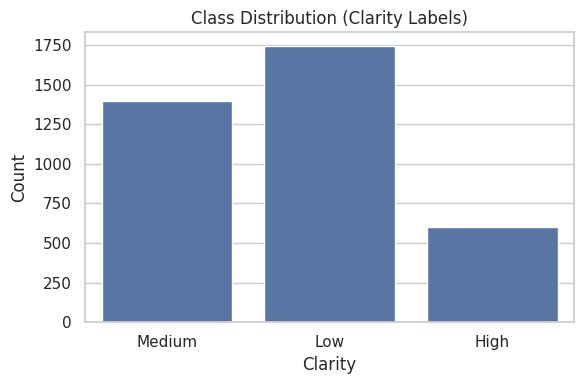

Skipping SMOTE. Using original training data...
Original training class distribution: [ 424 1208  983]

 Training classifiers with hyperparameter tuning and evaluating performance...

Random Forest Performance:
Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


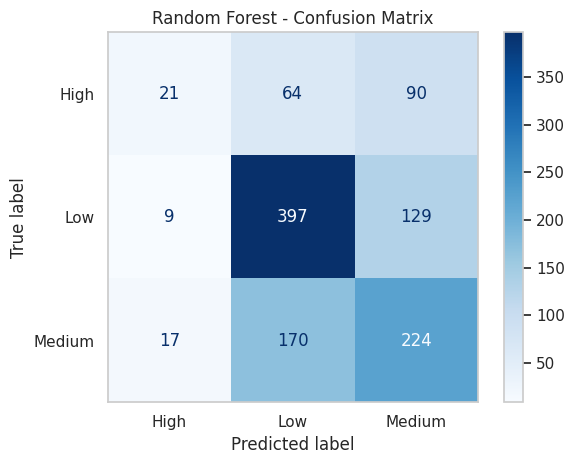

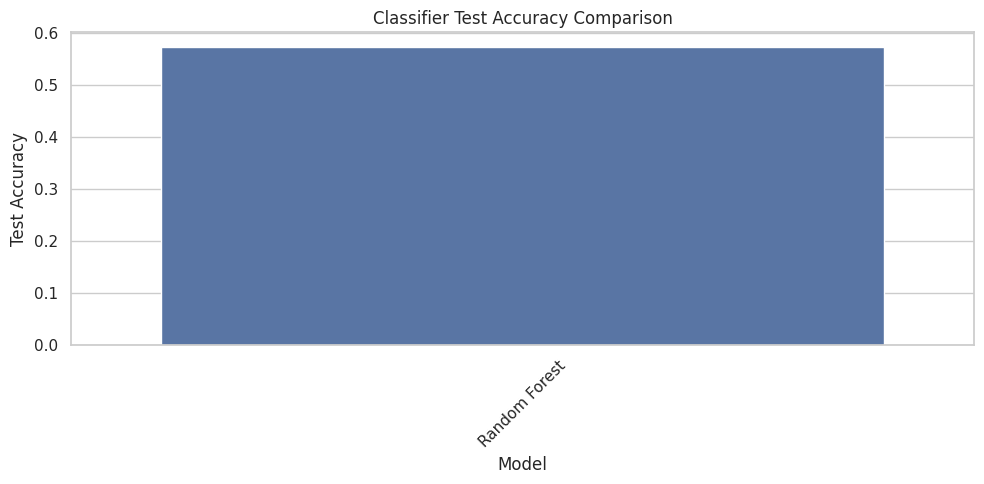


 Final Metrics Comparison Table:
        Model  Train Accuracy  Test Accuracy  Precision   Recall  F1 Score
Random Forest         0.98891       0.572703   0.555407 0.572703  0.546859

All classifier performance metrics saved to 'mfcc_classifier.xlsx'

 SHAP Summary Plot for Feature Importance (Model: Random Forest):


100%|===================| 7844/7845 [12:25<00:00]       

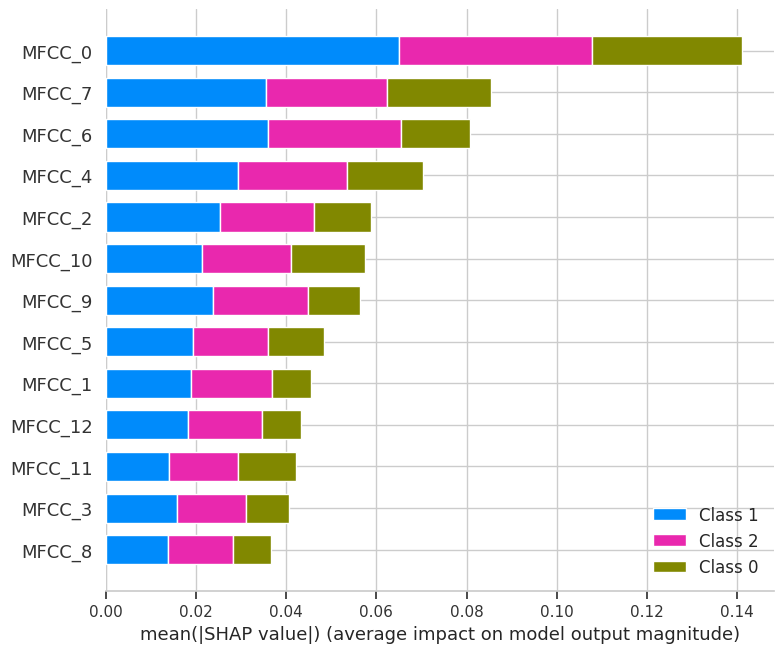

In [6]:
import librosa
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

sns.set(style="whitegrid")
n_mfcc = 13


def load_mfcc_features(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"{path} not found. Please provide the MFCC feature CSV.")
    return pd.read_csv(path)

def load_labels():
    excel_files = glob.glob("output_*_s.xlsx")
    if not excel_files:
        raise FileNotFoundError("No Excel files found.")

    labels_list = []
    for excel_file in excel_files:
        try:
            df = pd.read_excel(excel_file)[["File Name", "Clarity"]]
            df["File Name"] = df["File Name"].astype(str)
            labels_list.append(df)
        except Exception as e:
            print(f"Error reading {excel_file}: {e}")

    return pd.concat(labels_list, ignore_index=True)

def normalize_and_merge(mfcc_df, labels_df):
    def normalize_filename(name):
        return os.path.splitext(name.replace("_s", "s").replace(" ", "").lower())[0]

    mfcc_df["File Name"] = mfcc_df["File Name"].astype(str).apply(normalize_filename)
    labels_df["File Name"] = labels_df["File Name"].astype(str).apply(normalize_filename)
    labels_df["Clarity"] = labels_df["Clarity"].astype(str).str.strip().str.title()
    labels_df["Clarity"] = labels_df["Clarity"].replace({
        "Medium Low": "Low",
        "Low Medium": "Medium",
        "High Medium": "High",
        "Lowhigh": "High",
        "Med": "Medium",
        "Mid": "Medium"
    })

    return mfcc_df.merge(labels_df, on="File Name", how="inner")

def plot_class_distribution(data):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=data["Clarity"])
    plt.title("Class Distribution (Clarity Labels)")
    plt.xlabel("Clarity")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

def define_classifiers():
    return {
        "Random Forest": {
            "model": RandomForestClassifier(random_state=42),
            "params": {
                "n_estimators": [100, 200],
                "max_depth": [None, 10, 20],
                "min_samples_split": [2, 5]
            }
        }
    }

def train_and_evaluate_classifiers(X_train, X_test, y_train, y_test, classifiers):
    results = []
    shap_model = None
    final_model = None

    for name, clf_info in classifiers.items():
        print(f"\n{name} Performance:")
        clf = clf_info["model"]
        param_grid = clf_info["params"]

        grid_search = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_clf = grid_search.best_estimator_
        print(f"Best Parameters: {grid_search.best_params_}")

        y_train_pred = best_clf.predict(X_train)
        y_test_pred = best_clf.predict(X_test)

        results.append((
            name,
            accuracy_score(y_train, y_train_pred),
            accuracy_score(y_test, y_test_pred),
            precision_score(y_test, y_test_pred, average='weighted'),
            recall_score(y_test, y_test_pred, average='weighted'),
            f1_score(y_test, y_test_pred, average='weighted')
        ))

        ConfusionMatrixDisplay.from_predictions(
            y_test, y_test_pred,
            display_labels=le.inverse_transform(np.unique(y_test)),
            cmap="Blues",
            values_format='d'
        )
        plt.title(f"{name} - Confusion Matrix")
        plt.grid(False)
        plt.tight_layout()
        plt.show()

        shap_model = best_clf
        final_model = name

    return results, shap_model, final_model

def plot_feature_importance_with_shap(model, X):
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    shap.summary_plot(shap_values, X, feature_names=X.columns, plot_type="bar")

# ======================= Main =======================

mfcc_df = load_mfcc_features("/content/mfcc_mean_features (2).csv")
labels_df = load_labels()
data = normalize_and_merge(mfcc_df, labels_df)

if data.empty:
    raise ValueError("No matching data found after merging features with labels.")

X = data.drop(columns=["File Name", "Clarity"])
X = X.apply(pd.to_numeric, errors='coerce').fillna(0).select_dtypes(include=[np.number])
le = LabelEncoder()
y = le.fit_transform(data["Clarity"])

plot_class_distribution(data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Skipping SMOTE. Using original training data...")
print("Original training class distribution:", np.bincount(y_train))

print("\n Training classifiers with hyperparameter tuning and evaluating performance...")
classifiers = define_classifiers()
results, best_model, best_model_name = train_and_evaluate_classifiers(X_train, X_test, y_train, y_test, classifiers)

results_df = pd.DataFrame(results, columns=["Model", "Train Accuracy", "Test Accuracy", "Precision", "Recall", "F1 Score"])
plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="Test Accuracy", data=results_df.sort_values(by="Test Accuracy", ascending=False))
plt.xticks(rotation=45)
plt.title("Classifier Test Accuracy Comparison")
plt.tight_layout()
plt.show()

print("\n Final Metrics Comparison Table:")
print(results_df.to_string(index=False))

results_df.to_excel("mfcc_classifier.xlsx", index=False)
print("\nAll classifier performance metrics saved to 'mfcc_classifier.xlsx'")

print("\n SHAP Summary Plot for Feature Importance (Model: {}):".format(best_model_name))
plot_feature_importance_with_shap(best_model, X_train)


mfcc with smote

Reading label files...
Visualizing class distribution...


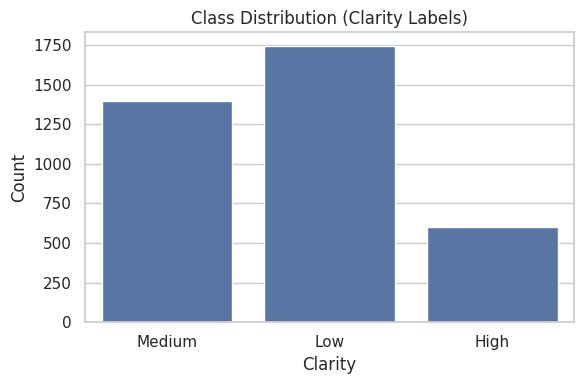

Applying SMOTE to balance training data...
Original class distribution: [ 424 1208  983]
Balanced class distribution: [1208 1208 1208]

Training classifiers with hyperparameter tuning and evaluating performance...

KNN Performance:
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


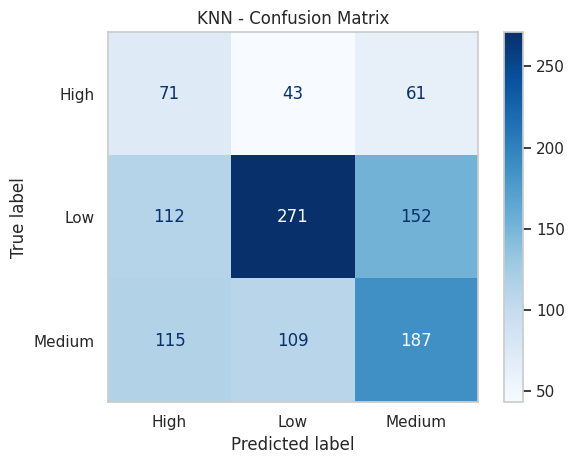


Classification Report:
              precision    recall  f1-score   support

        High       0.24      0.41      0.30       175
         Low       0.64      0.51      0.57       535
      Medium       0.47      0.45      0.46       411

    accuracy                           0.47      1121
   macro avg       0.45      0.46      0.44      1121
weighted avg       0.51      0.47      0.49      1121



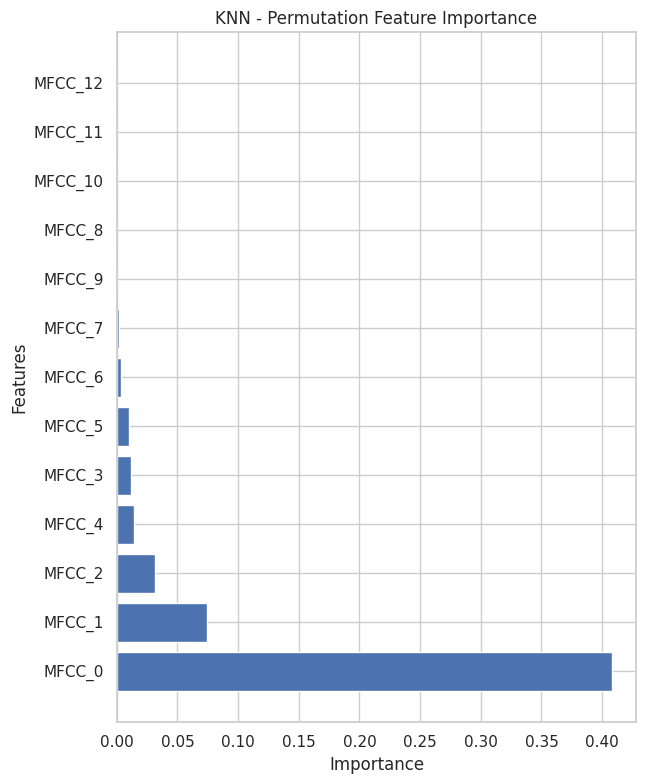


Logistic Regression Performance:
Best Parameters: {'C': 0.1, 'solver': 'liblinear'}


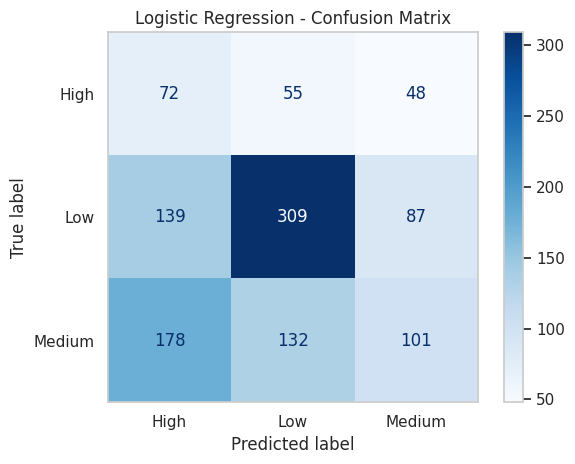


Classification Report:
              precision    recall  f1-score   support

        High       0.19      0.41      0.26       175
         Low       0.62      0.58      0.60       535
      Medium       0.43      0.25      0.31       411

    accuracy                           0.43      1121
   macro avg       0.41      0.41      0.39      1121
weighted avg       0.48      0.43      0.44      1121



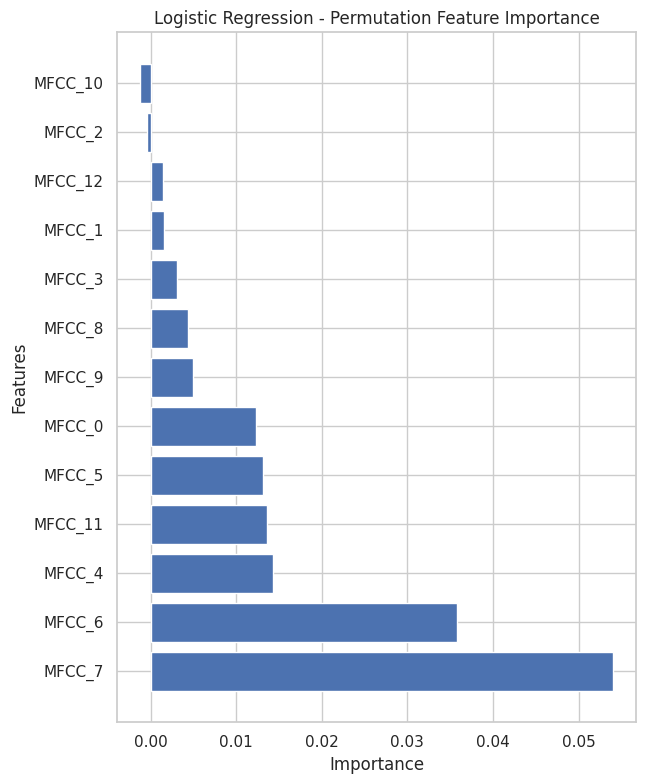


AdaBoost Performance:
Best Parameters: {'learning_rate': 1.0, 'n_estimators': 200}


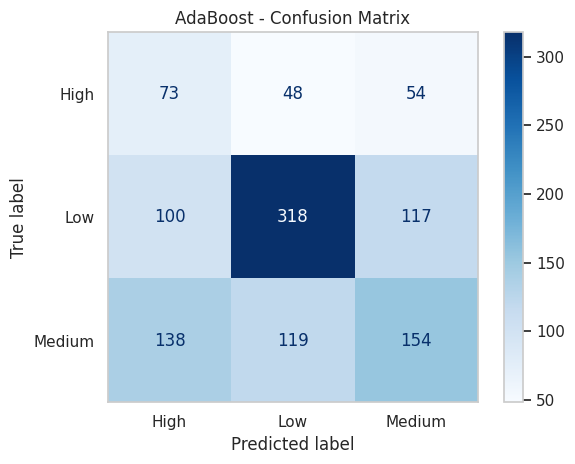


Classification Report:
              precision    recall  f1-score   support

        High       0.23      0.42      0.30       175
         Low       0.66      0.59      0.62       535
      Medium       0.47      0.37      0.42       411

    accuracy                           0.49      1121
   macro avg       0.45      0.46      0.45      1121
weighted avg       0.52      0.49      0.50      1121



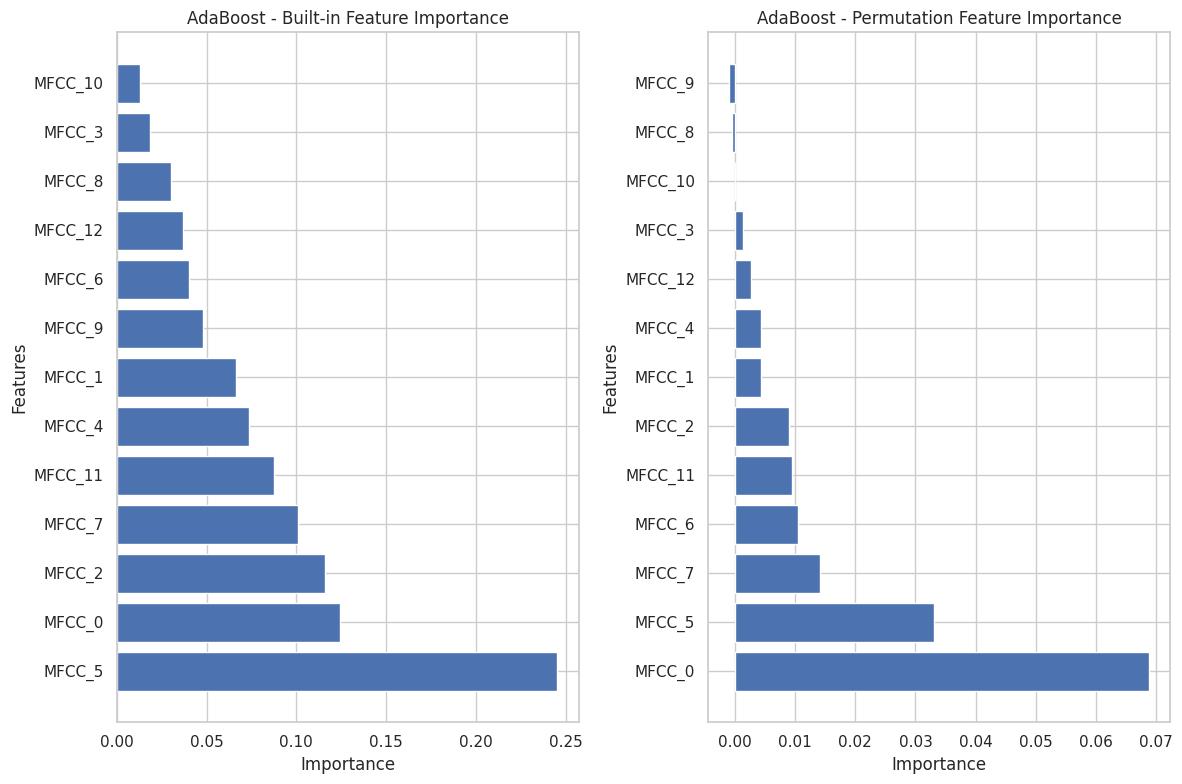


CatBoost Performance:
Best Parameters: {'depth': 8, 'iterations': 200, 'learning_rate': 0.1}
Error training CatBoost: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

Decision Tree Performance:


Traceback (most recent call last):
  File "<ipython-input-15-373bbc50765b>", line 380, in <cell line: 0>
    unique_labels = np.unique(np.concatenate([y_test, y_test_pred]))
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


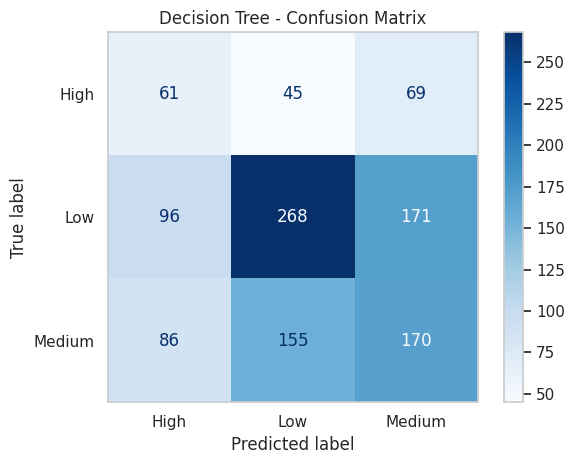


Classification Report:
              precision    recall  f1-score   support

        High       0.25      0.35      0.29       175
         Low       0.57      0.50      0.53       535
      Medium       0.41      0.41      0.41       411

    accuracy                           0.45      1121
   macro avg       0.41      0.42      0.41      1121
weighted avg       0.46      0.45      0.45      1121



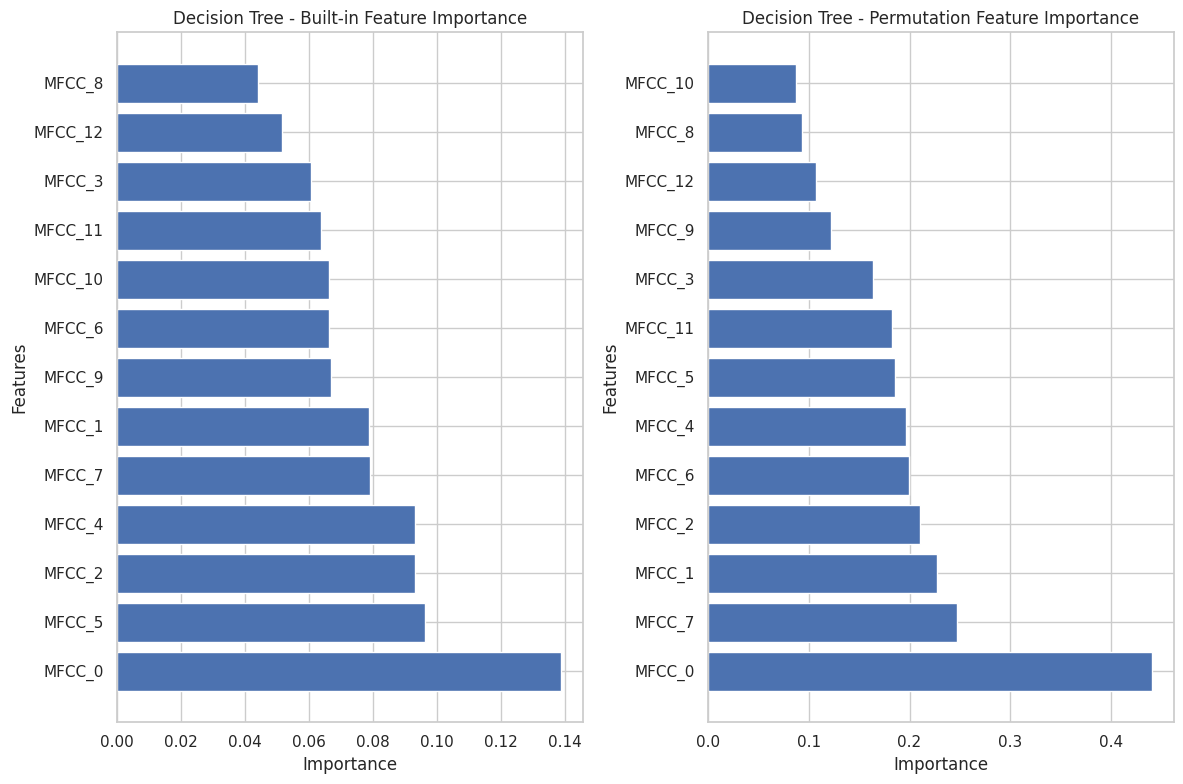


XGBoost Performance:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


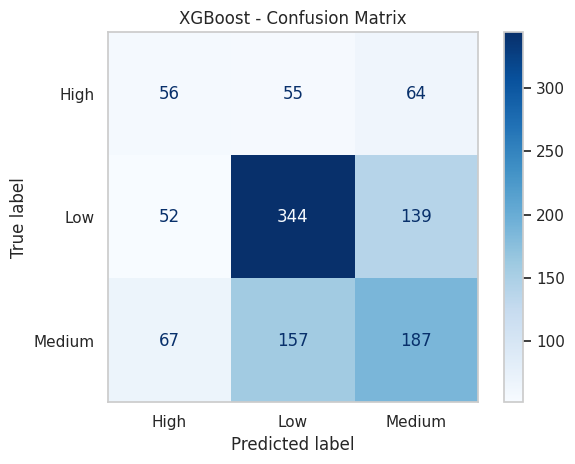


Classification Report:
              precision    recall  f1-score   support

        High       0.32      0.32      0.32       175
         Low       0.62      0.64      0.63       535
      Medium       0.48      0.45      0.47       411

    accuracy                           0.52      1121
   macro avg       0.47      0.47      0.47      1121
weighted avg       0.52      0.52      0.52      1121



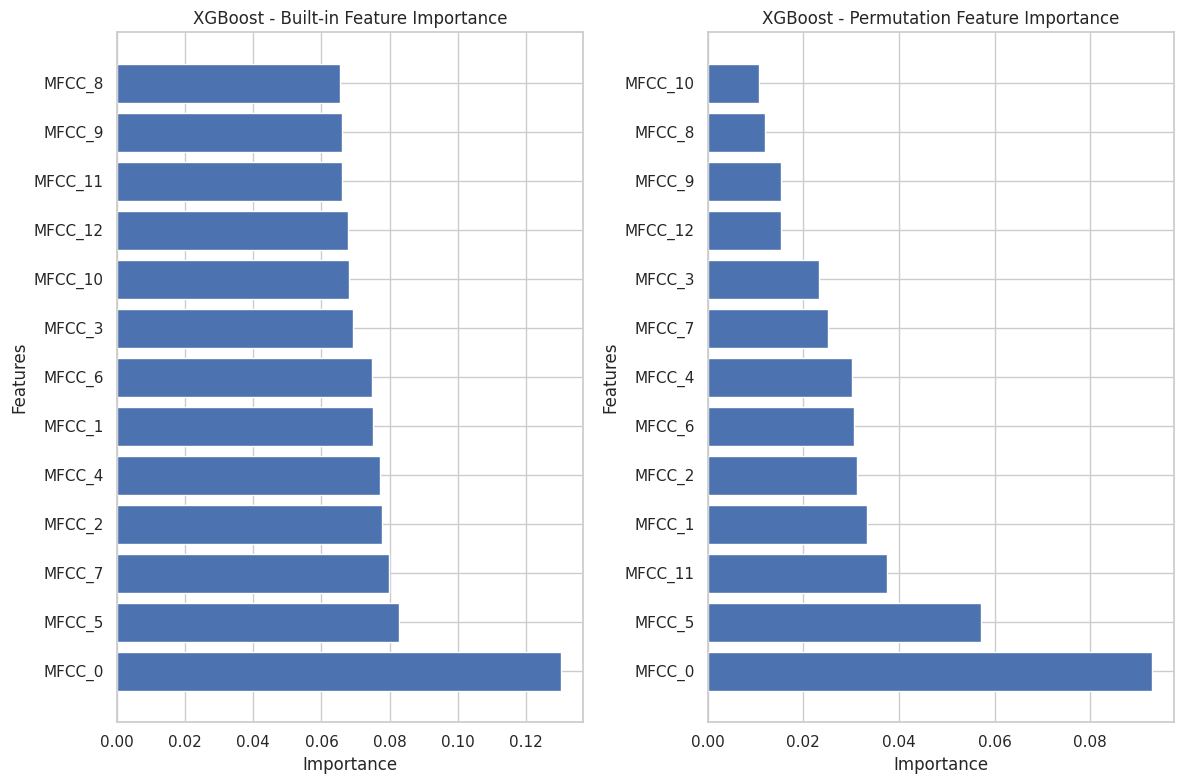


MLP Performance:
Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}


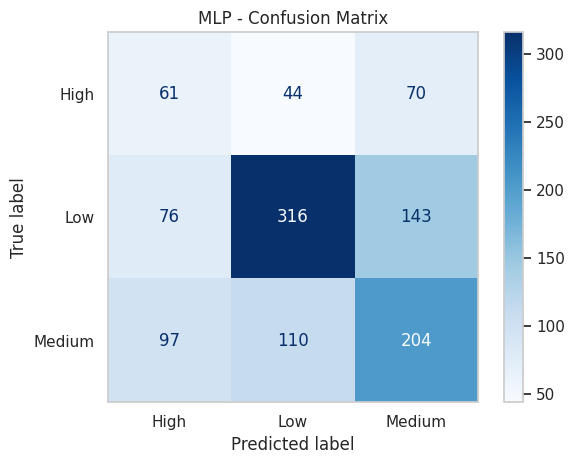


Classification Report:
              precision    recall  f1-score   support

        High       0.26      0.35      0.30       175
         Low       0.67      0.59      0.63       535
      Medium       0.49      0.50      0.49       411

    accuracy                           0.52      1121
   macro avg       0.47      0.48      0.47      1121
weighted avg       0.54      0.52      0.53      1121



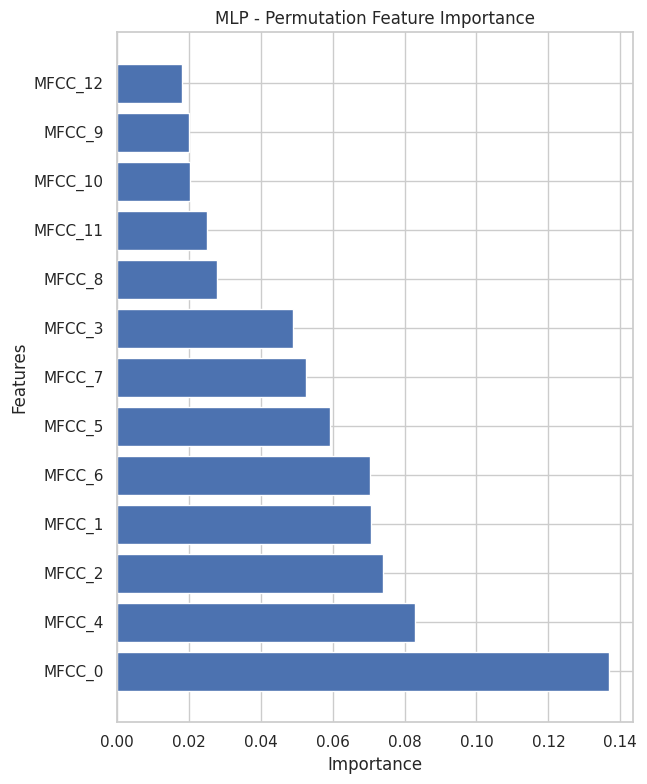


Random Forest Performance:
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


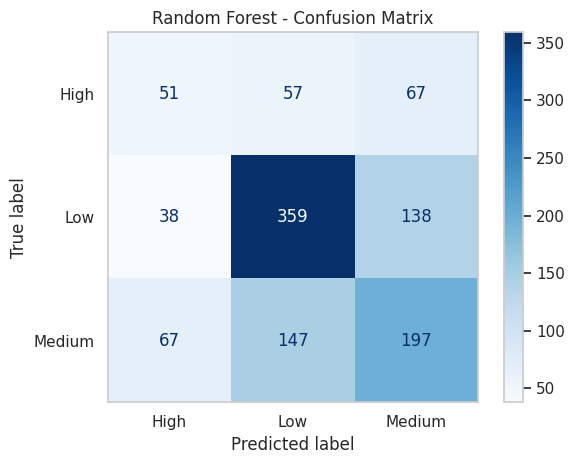


Classification Report:
              precision    recall  f1-score   support

        High       0.33      0.29      0.31       175
         Low       0.64      0.67      0.65       535
      Medium       0.49      0.48      0.48       411

    accuracy                           0.54      1121
   macro avg       0.48      0.48      0.48      1121
weighted avg       0.54      0.54      0.54      1121



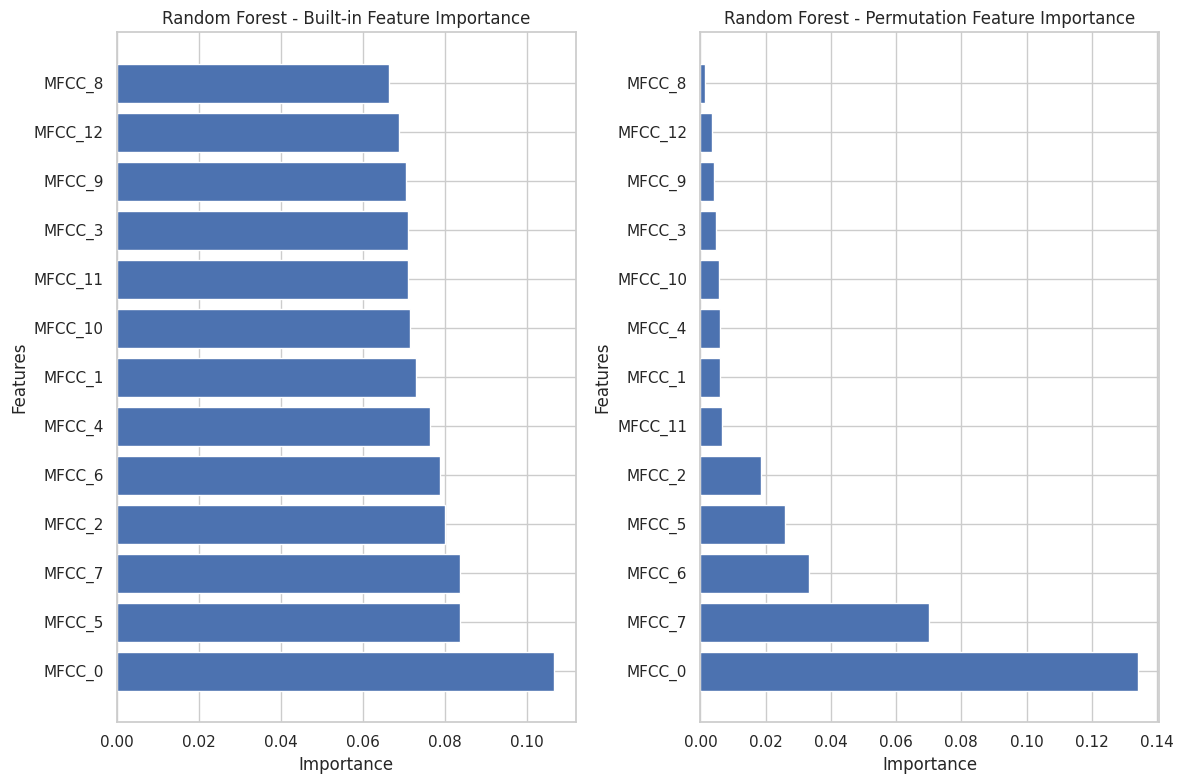


Naïve Bayes Performance:
Best Parameters: {'var_smoothing': 1e-09}


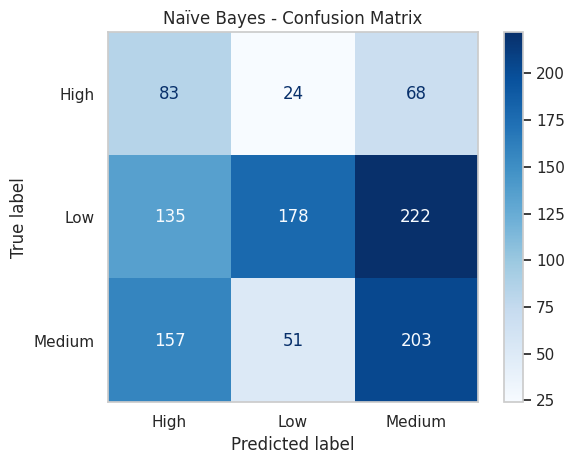


Classification Report:
              precision    recall  f1-score   support

        High       0.22      0.47      0.30       175
         Low       0.70      0.33      0.45       535
      Medium       0.41      0.49      0.45       411

    accuracy                           0.41      1121
   macro avg       0.45      0.43      0.40      1121
weighted avg       0.52      0.41      0.43      1121



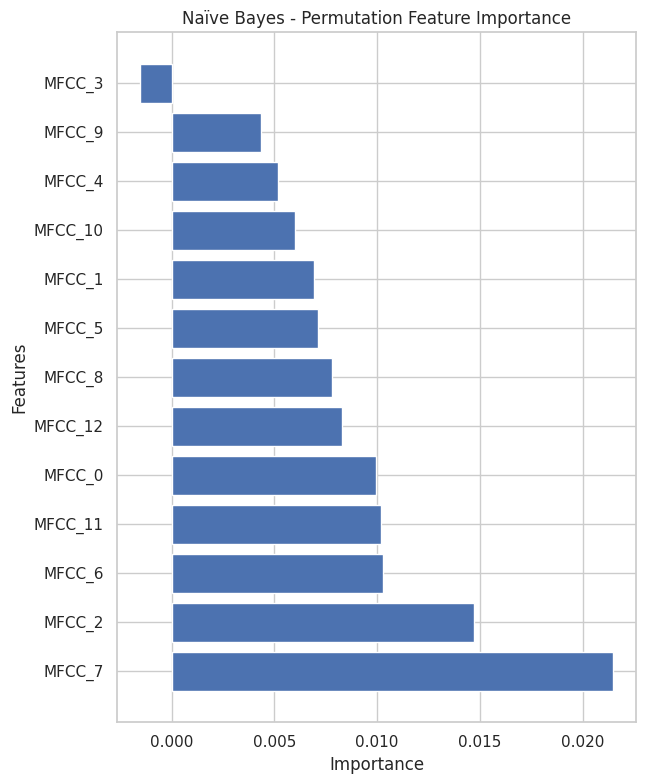

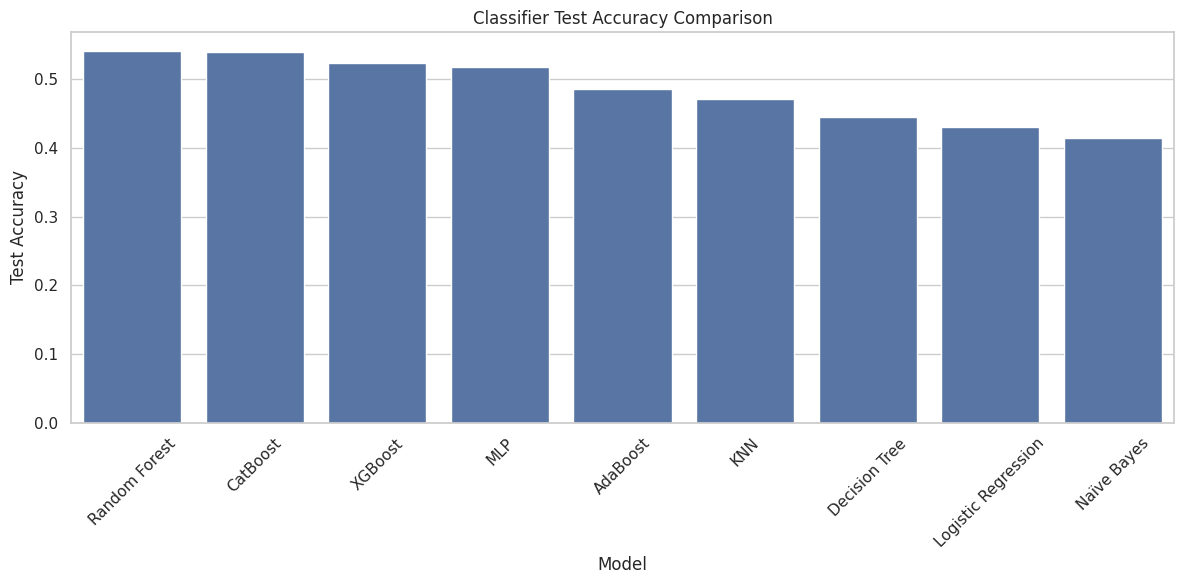


Final Metrics Comparison Table:
              Model  Train Accuracy  Test Accuracy  Precision   Recall  F1 Score
                KNN        0.987031       0.471900   0.514354 0.471900  0.485955
Logistic Regression        0.488962       0.429973   0.483123 0.429973  0.440400
           AdaBoost        0.539459       0.486173   0.523293 0.486173  0.497908
           CatBoost        0.938190       0.539697   0.542347 0.539697  0.540729
      Decision Tree        0.987031       0.445138   0.464507 0.445138  0.452441
            XGBoost        0.987031       0.523640   0.521032 0.523640  0.522106
                MLP        0.583057       0.518287   0.540934 0.518287  0.527351
      Random Forest        0.987031       0.541481   0.535029 0.541481  0.537871
        Naïve Bayes        0.476269       0.413916   0.521295 0.413916  0.427391

Displaying MFCC Values for Each Audio File:

MFCC values saved to 'mfcc_features_saved.csv'


Analyzing SHAP values for best model: Random Forest (Test Accu

<Figure size 800x670 with 0 Axes>

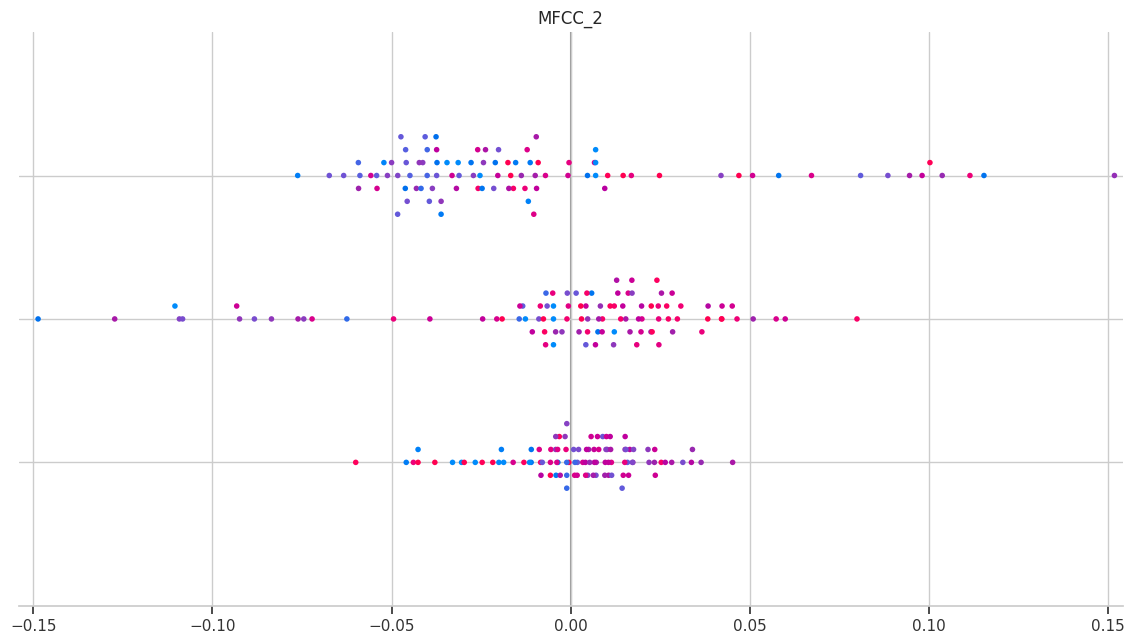

Error in SHAP analysis for Random Forest: Must pass 2-d input. shape=(100, 13, 3)

All classifier performance metrics saved to 'mfcc_smote_classifier_results.xlsx'

Generating feature importance ranking for best model: Random Forest


Traceback (most recent call last):
  File "<ipython-input-15-373bbc50765b>", line 158, in analyze_shap_values
    shap_df = pd.DataFrame(shap_values, columns=feature_names)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/frame.py", line 827, in __init__
    mgr = ndarray_to_mgr(
          ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/internals/construction.py", line 314, in ndarray_to_mgr
    values = _ensure_2d(values)
             ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/internals/construction.py", line 592, in _ensure_2d
    raise ValueError(f"Must pass 2-d input. shape={values.shape}")
ValueError: Must pass 2-d input. shape=(100, 13, 3)


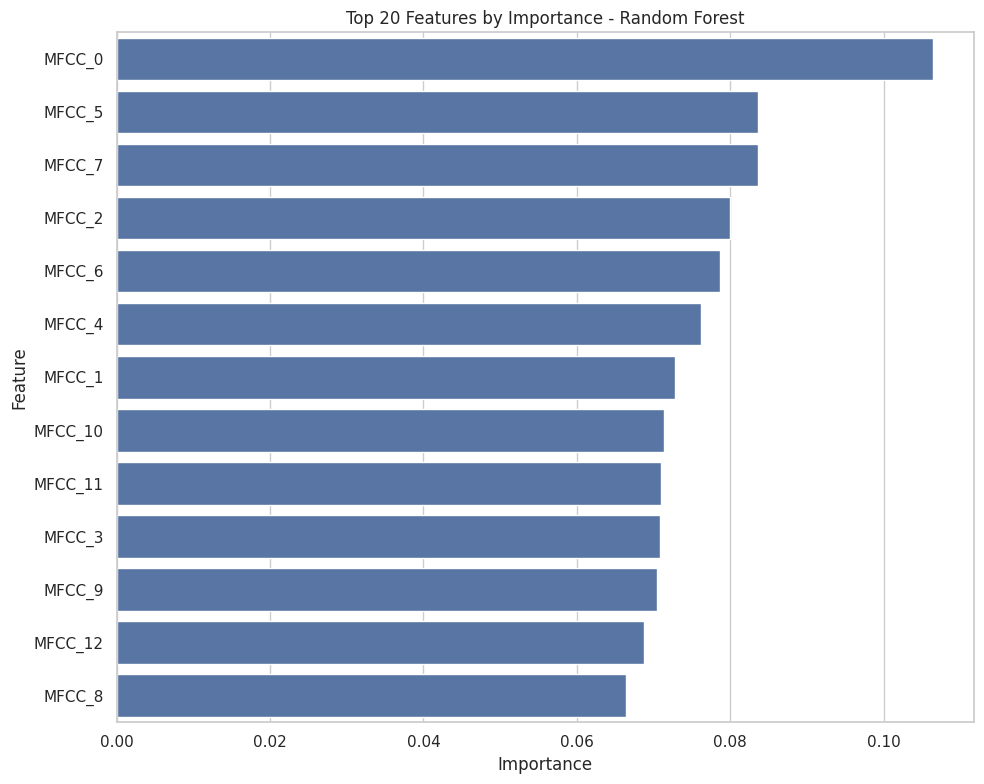

Feature importance ranking saved to 'best_model_Random_Forest_feature_importance.csv'


In [15]:
import librosa
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance

# Function to extract and plot feature importance for all models
def plot_feature_importance(model, name, X, X_train, y_train, feature_names):
    plt.figure(figsize=(12, 8))

    # Method 1: Built-in feature importances (if available)
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.subplot(1, 2, 1)
        plt.title(f"{name} - Built-in Feature Importance")
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.ylabel('Features')
        plt.xlabel('Importance')

        # Save feature importance to CSV
        importance_df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": importances
        }).sort_values(by="Importance", ascending=False)
        importance_df.to_csv(f"feature_importance_{name.replace(' ', '_')}_builtin.csv", index=False)

    # Method 2: Permutation importance (works for all models)
    try:
        result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1)
        perm_importance = result.importances_mean
        indices = np.argsort(perm_importance)[::-1]

        plt.subplot(1, 2, 2)
        plt.title(f"{name} - Permutation Feature Importance")
        plt.barh(range(len(indices)), perm_importance[indices], align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.ylabel('Features')
        plt.xlabel('Importance')

        # Save permutation importance to CSV
        perm_importance_df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": perm_importance
        }).sort_values(by="Importance", ascending=False)
        perm_importance_df.to_csv(f"feature_importance_{name.replace(' ', '_')}_permutation.csv", index=False)
    except Exception as e:
        print(f"Could not compute permutation importance for {name}: {e}")

    plt.tight_layout()
    plt.show()

    return {"built_in": importances if hasattr(model, "feature_importances_") else None,
            "permutation": perm_importance if 'perm_importance' in locals() else None}


# Function to calculate and visualize SHAP values for the best model
def analyze_shap_values(model, X_train, X_test, feature_names, model_name):
    print(f"\nCalculating SHAP values for {model_name}...")
    plt.figure(figsize=(12, 10))

    try:
        # Create explainer appropriate for the model type
        if isinstance(model, (XGBClassifier, RandomForestClassifier, AdaBoostClassifier, DecisionTreeClassifier, CatBoostClassifier)):
            # Tree-based models
            explainer = shap.TreeExplainer(model)
            # Sample from test set for faster computation
            sample_size = min(100, X_test.shape[0])
            X_sample = shap.sample(X_test, sample_size, random_state=42)
            # Calculate SHAP values
            shap_values = explainer.shap_values(X_sample)

            # For multi-class, shap_values is a list of arrays, one per class
            if isinstance(shap_values, list):
                # Plot summary for first class (can be changed to other classes)
                plt.subplot(2, 1, 1)
                plt.title(f"SHAP Summary Plot for {model_name} - Class 0")
                shap.summary_plot(shap_values[0], X_sample, feature_names=feature_names, plot_type="bar", show=False)
                plt.subplot(2, 1, 2)
                shap.summary_plot(shap_values[0], X_sample, feature_names=feature_names, show=False)
            else:
                plt.subplot(2, 1, 1)
                plt.title(f"SHAP Summary Plot for {model_name}")
                shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar", show=False)
                plt.subplot(2, 1, 2)
                shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)

        elif isinstance(model, (LogisticRegression, SVC)):
            # Linear models
            explainer = shap.LinearExplainer(model, X_train)
            sample_size = min(100, X_test.shape[0])
            X_sample = shap.sample(X_test, sample_size, random_state=42)
            shap_values = explainer.shap_values(X_sample)

            plt.subplot(2, 1, 1)
            plt.title(f"SHAP Summary Plot for {model_name}")
            shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar", show=False)
            plt.subplot(2, 1, 2)
            shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)

        else:
            # KernelExplainer works with any model but is slower
            # Create a smaller background dataset for KernelExplainer
            background = shap.sample(X_train, 100, random_state=42)
            explainer = shap.KernelExplainer(model.predict_proba, background)
            sample_size = min(50, X_test.shape[0])  # Smaller sample due to computational intensity
            X_sample = shap.sample(X_test, sample_size, random_state=42)
            shap_values = explainer.shap_values(X_sample)

            if isinstance(shap_values, list):
                plt.subplot(2, 1, 1)
                plt.title(f"SHAP Summary Plot for {model_name} - Class 0")
                shap.summary_plot(shap_values[0], X_sample, feature_names=feature_names, plot_type="bar", show=False)
                plt.subplot(2, 1, 2)
                shap.summary_plot(shap_values[0], X_sample, feature_names=feature_names, show=False)
            else:
                plt.subplot(2, 1, 1)
                plt.title(f"SHAP Summary Plot for {model_name}")
                shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar", show=False)
                plt.subplot(2, 1, 2)
                shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)

        plt.tight_layout()
        plt.show()

        # Create SHAP dependence plots for top features
        if isinstance(shap_values, list):
            # For multi-class, use first class shap values
            shap_df = pd.DataFrame(shap_values[0], columns=feature_names)
        else:
            shap_df = pd.DataFrame(shap_values, columns=feature_names)

        # Get top 5 features by mean absolute SHAP value
        top_features = shap_df.abs().mean().sort_values(ascending=False).head(5).index

        plt.figure(figsize=(15, 10))
        for i, feature in enumerate(top_features):
            plt.subplot(2, 3, i+1)
            if isinstance(shap_values, list):
                shap.dependence_plot(feature, shap_values[0], X_sample, feature_names=feature_names,
                                    show=False, ax=plt.gca())
            else:
                shap.dependence_plot(feature, shap_values, X_sample, feature_names=feature_names,
                                    show=False, ax=plt.gca())

        plt.tight_layout()
        plt.suptitle(f"SHAP Dependence Plots for Top Features - {model_name}", y=1.02)
        plt.show()

        # Save SHAP values to CSV
        if isinstance(shap_values, list):
            for i, class_shap in enumerate(shap_values):
                shap_df = pd.DataFrame(class_shap, columns=feature_names)
                shap_df["class"] = i
                shap_df.to_csv(f"shap_values_{model_name.replace(' ', '_')}_class_{i}.csv", index=False)
        else:
            shap_df = pd.DataFrame(shap_values, columns=feature_names)
            shap_df.to_csv(f"shap_values_{model_name.replace(' ', '_')}.csv", index=False)

    except Exception as e:
        print(f"Error in SHAP analysis for {model_name}: {e}")
        import traceback
        traceback.print_exc()


sns.set(style="whitegrid")
mfcc_df = pd.read_csv("/content/mfcc_mean_features (2).csv")  # <-- NOTE: You must generate MFCC features using MODE not MEAN
if mfcc_df.empty:
    raise ValueError("MFCC feature file is empty or not loaded correctly.")

print("Reading label files...")
excel_files = glob.glob("output_*_s.xlsx")
if not excel_files:
    raise FileNotFoundError("No Excel files found.")

labels_list = []
for excel_file in excel_files:
    try:
        df = pd.read_excel(excel_file)
        df = df[["File Name", "Clarity"]]
        df["File Name"] = df["File Name"].astype(str)
        labels_list.append(df)
    except Exception as e:
        print(f"Error reading {excel_file}: {e}")

labels_df = pd.concat(labels_list, ignore_index=True)

#  Normalize File Name for consistent merging
def normalize_filename(name):
    return os.path.splitext(name.replace("_s", "s").replace(" ", "").lower())[0]

mfcc_df["File Name"] = mfcc_df["File Name"].astype(str).apply(normalize_filename)
labels_df["File Name"] = labels_df["File Name"].astype(str).apply(normalize_filename)
labels_df["Clarity"] = labels_df["Clarity"].astype(str).str.strip().str.title()
labels_df["Clarity"] = labels_df["Clarity"].replace({
    "Medium Low": "Low",
    "Low Medium": "Medium",
    "High Medium": "High",
    "Lowhigh": "High",
    "Med": "Medium",
    "Mid": "Medium"
})

data = mfcc_df.merge(labels_df, on="File Name", how="inner")
if data.empty:
    print("Sample MFCC DF:", mfcc_df["File Name"].head())
    print("Sample Labels DF:", labels_df["File Name"].head())
    raise ValueError("No matching data found after merging features with labels.")

X = data.drop(columns=["File Name", "Clarity"])
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
X = X.select_dtypes(include=[np.number])

le = LabelEncoder()
y = le.fit_transform(data["Clarity"])

print("Visualizing class distribution...")
plt.figure(figsize=(6, 4))
sns.countplot(x=data["Clarity"])
plt.title("Class Distribution (Clarity Labels)")
plt.xlabel("Clarity")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

classifiers = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7],
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan"]
        }
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "solver": ["lbfgs", "liblinear"]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0]
        }
    },
    "CatBoost": {
        "model": CatBoostClassifier(verbose=0, random_state=42),
        "params": {
            "iterations": [100, 200],
            "depth": [4, 6, 8],
            "learning_rate": [0.01, 0.1]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1]
        }
    },
    "MLP": {
        "model": MLPClassifier(max_iter=500, random_state=42),
        "params": {
            "hidden_layer_sizes": [(50,), (100,), (50, 50)],
            "activation": ["relu", "tanh"],
            "learning_rate_init": [0.001, 0.01]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5]
        }
    },
    "Naïve Bayes": {
        "model": GaussianNB(),
        "params": {
            "var_smoothing": [1e-9, 1e-8, 1e-7]
        }
    },

}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Applying SMOTE to balance training data...")
print("Original class distribution:", np.bincount(y_train))
smote = SMOTE(random_state=42, k_neighbors=2)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print("Balanced class distribution:", np.bincount(y_train_balanced))

# Train and evaluate
results = []
print("\nTraining classifiers with hyperparameter tuning and evaluating performance...")
best_model = None
best_acc = 0
best_model_name = ""
models_dict = {}  # Store trained models

feature_names = X.columns.tolist()

for name, clf_info in classifiers.items():
    try:
        print(f"\n{name} Performance:")
        clf = clf_info["model"]
        param_grid = clf_info["params"]

        grid_search = GridSearchCV(
            estimator=clf,
            param_grid=param_grid,
            cv=5,
            scoring="accuracy",
            n_jobs=-1
        )
        grid_search.fit(X_train_balanced, y_train_balanced)

        best_clf = grid_search.best_estimator_
        models_dict[name] = best_clf  # Store model for later use

        print(f"Best Parameters: {grid_search.best_params_}")

        y_train_pred = best_clf.predict(X_train_balanced)
        y_test_pred = best_clf.predict(X_test)

        train_acc = accuracy_score(y_train_balanced, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred, average='weighted')
        precision = precision_score(y_test, y_test_pred, average='weighted')
        recall = recall_score(y_test, y_test_pred, average='weighted')

        results.append((name, train_acc, test_acc, precision, recall, f1))

        # Keep track of best model
        if test_acc > best_acc:
            best_acc = test_acc
            best_model = best_clf
            best_model_name = name

        unique_labels = np.unique(np.concatenate([y_test, y_test_pred]))
        target_names = le.inverse_transform(unique_labels)

        ConfusionMatrixDisplay.from_predictions(
            y_test, y_test_pred,
            display_labels=target_names,
            cmap="Blues",
            values_format='d'
        )
        plt.title(f"{name} - Confusion Matrix")
        plt.grid(False)
        plt.tight_layout()
        plt.show()

        # Generate detailed classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_test_pred, target_names=target_names))

        # Plot feature importance for all models
        importances = plot_feature_importance(best_clf, name, X, X_train_balanced, y_train_balanced, feature_names)

    except Exception as e:
        print(f"Error training {name}: {e}")
        import traceback
        traceback.print_exc()

# Results summary
results_df = pd.DataFrame(results, columns=["Model", "Train Accuracy", "Test Accuracy", "Precision", "Recall", "F1 Score"])
plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Test Accuracy", data=results_df.sort_values(by="Test Accuracy", ascending=False))
plt.xticks(rotation=45)
plt.title("Classifier Test Accuracy Comparison")
plt.tight_layout()
plt.show()

print("\nFinal Metrics Comparison Table:")
print(results_df.to_string(index=False))

print("\nDisplaying MFCC Values for Each Audio File:")
mfcc_df.to_csv("mfcc_features_saved.csv", index=False)
print("\nMFCC values saved to 'mfcc_features_saved.csv'")

# SHAP analysis for the best model
print(f"\n\nAnalyzing SHAP values for best model: {best_model_name} (Test Accuracy: {best_acc:.4f})")
analyze_shap_values(best_model, X_train_balanced, X_test, feature_names, best_model_name)

# Save all results
excel_output_path = "mfcc_smote_classifier_results.xlsx"
results_df.to_excel(excel_output_path, index=False)
print(f"\nAll classifier performance metrics saved to '{excel_output_path}'")

# Feature importance ranking and visualization
if best_model_name:
    print(f"\nGenerating feature importance ranking for best model: {best_model_name}")
    if hasattr(best_model, "feature_importances_"):
        # For models with built-in feature importance
        importances = best_model.feature_importances_
        feature_importance_df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": importances
        }).sort_values(by="Importance", ascending=False)

        # Plot top features
        plt.figure(figsize=(10, 8))
        top_n = 20  # Show top 20 features
        sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(top_n))
        plt.title(f"Top {top_n} Features by Importance - {best_model_name}")
        plt.tight_layout()
        plt.show()

        # Save feature importance to CSV
        feature_importance_df.to_csv(f"best_model_{best_model_name.replace(' ', '_')}_feature_importance.csv", index=False)
        print(f"Feature importance ranking saved to 'best_model_{best_model_name.replace(' ', '_')}_feature_importance.csv'")
    else:
        print(f"Model {best_model_name} does not have built-in feature importance.")

In [16]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.8 MB/s eta 0:00:00


MFCC with smote, cross validation

Reading label files...


<ipython-input-17-d2275bf43a5a>:272: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["File Name"] = df["File Name"].astype(str)


Visualizing class distribution...


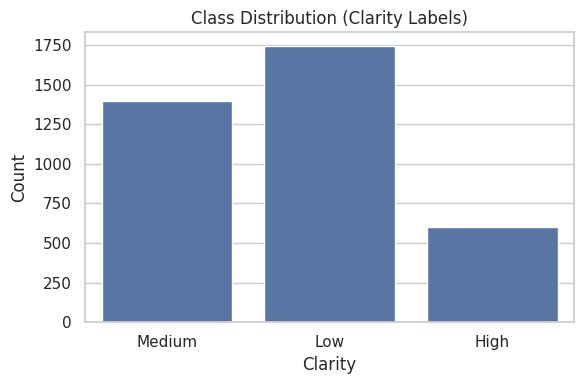


STEP 1: PERFORMING CROSS-VALIDATION ON ORIGINAL DATASET

Performing 5-fold cross-validation...

Cross-validating KNN...
KNN CV Accuracy: 0.5123 ± 0.0282
KNN CV Precision: 0.5050 ± 0.0287
KNN CV Recall: 0.5123 ± 0.0282
KNN CV F1 Score: 0.5057 ± 0.0291

Cross-validating Logistic Regression...
Logistic Regression CV Accuracy: 0.5431 ± 0.0162
Logistic Regression CV Precision: 0.5134 ± 0.0374
Logistic Regression CV Recall: 0.5431 ± 0.0162
Logistic Regression CV F1 Score: 0.4987 ± 0.0173

Cross-validating AdaBoost...
AdaBoost CV Accuracy: 0.5407 ± 0.0170
AdaBoost CV Precision: 0.5065 ± 0.0362
AdaBoost CV Recall: 0.5407 ± 0.0170
AdaBoost CV F1 Score: 0.4969 ± 0.0143

Cross-validating CatBoost...
CatBoost CV Accuracy: 0.5541 ± 0.0167
CatBoost CV Precision: 0.5397 ± 0.0203
CatBoost CV Recall: 0.5541 ± 0.0167
CatBoost CV F1 Score: 0.5373 ± 0.0179

Cross-validating Decision Tree...
Decision Tree CV Accuracy: 0.4673 ± 0.0137
Decision Tree CV Precision: 0.4692 ± 0.0125
Decision Tree CV Recall: 0.4

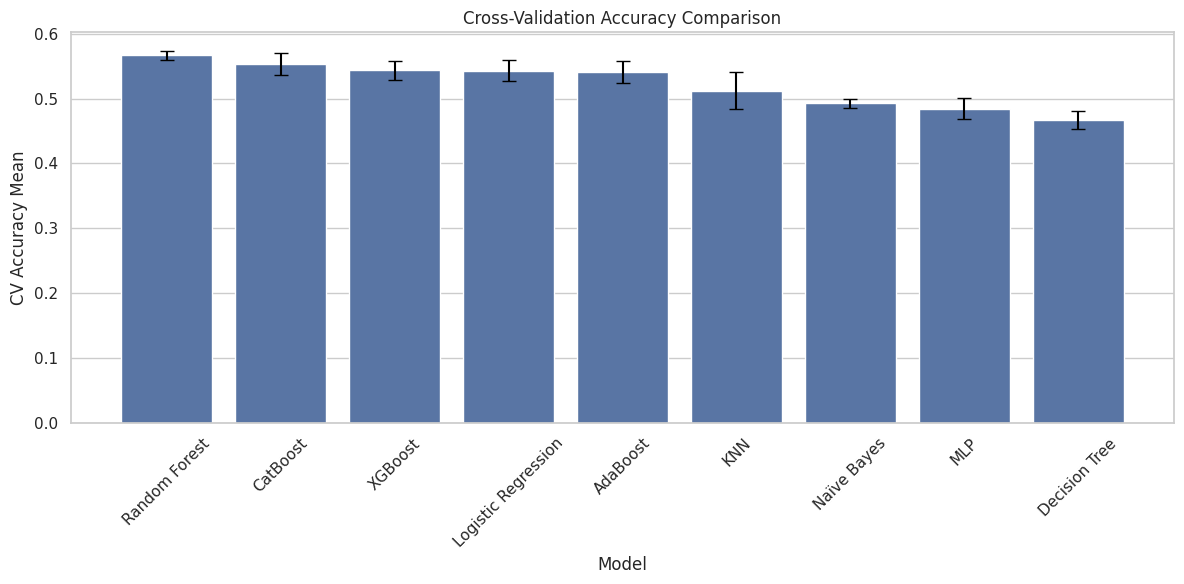

Cross-validation results saved to 'cross_validation_results.csv'

STEP 2: PROCEEDING WITH TRAIN-TEST SPLIT AND HYPERPARAMETER TUNING
Applying SMOTE to balance training data...
Original class distribution: [ 424 1208  983]
Balanced class distribution: [1208 1208 1208]

Training classifiers with hyperparameter tuning and evaluating performance...

KNN Performance:
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


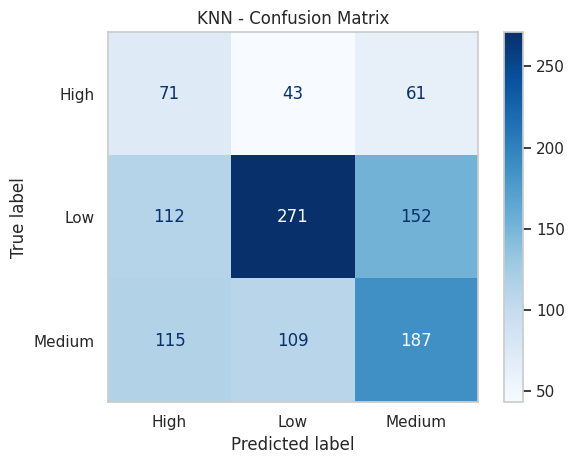


Classification Report:
              precision    recall  f1-score   support

        High       0.24      0.41      0.30       175
         Low       0.64      0.51      0.57       535
      Medium       0.47      0.45      0.46       411

    accuracy                           0.47      1121
   macro avg       0.45      0.46      0.44      1121
weighted avg       0.51      0.47      0.49      1121



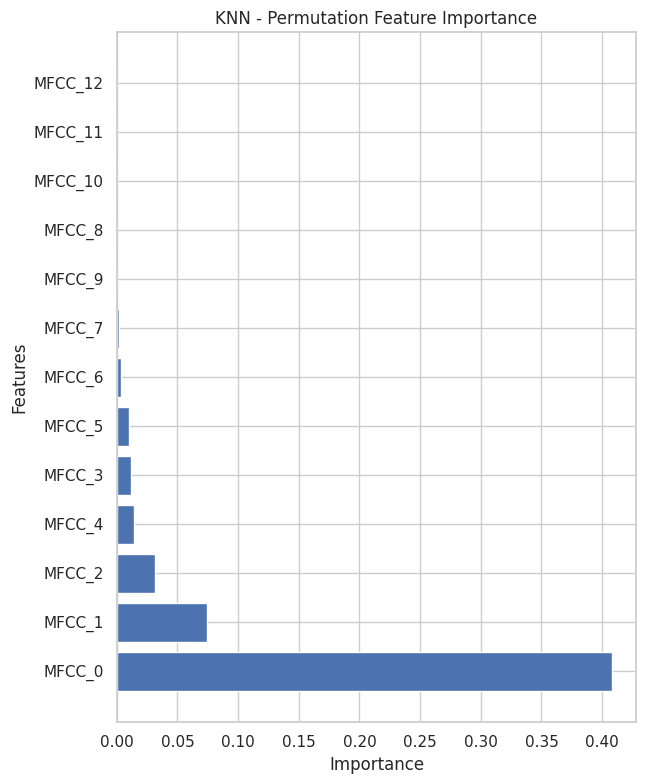


Logistic Regression Performance:
Best Parameters: {'C': 0.1, 'solver': 'liblinear'}


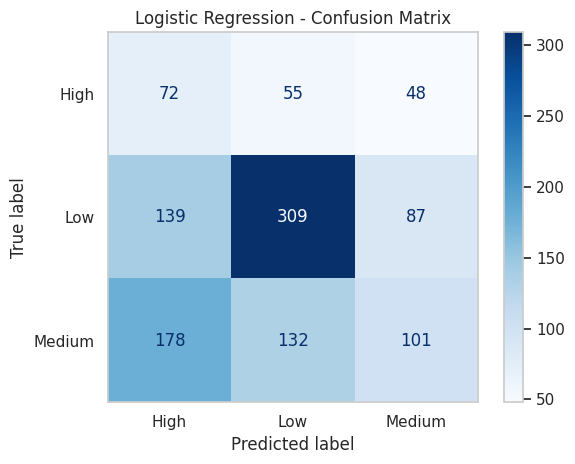


Classification Report:
              precision    recall  f1-score   support

        High       0.19      0.41      0.26       175
         Low       0.62      0.58      0.60       535
      Medium       0.43      0.25      0.31       411

    accuracy                           0.43      1121
   macro avg       0.41      0.41      0.39      1121
weighted avg       0.48      0.43      0.44      1121



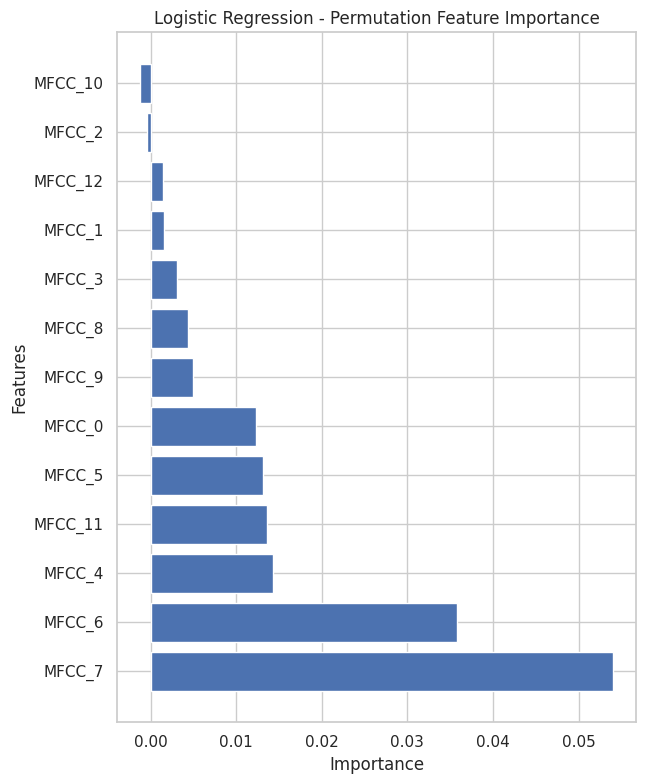


AdaBoost Performance:
Best Parameters: {'learning_rate': 1.0, 'n_estimators': 200}


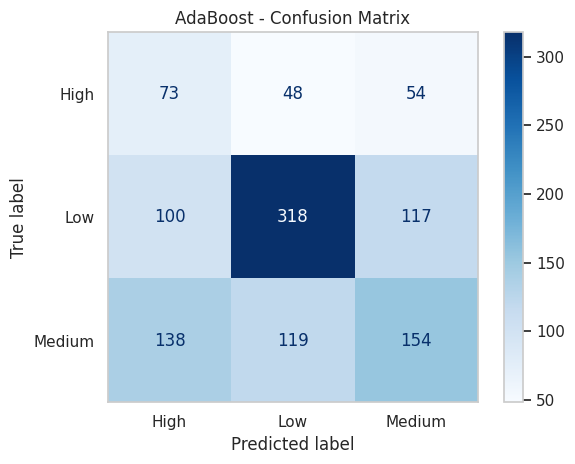


Classification Report:
              precision    recall  f1-score   support

        High       0.23      0.42      0.30       175
         Low       0.66      0.59      0.62       535
      Medium       0.47      0.37      0.42       411

    accuracy                           0.49      1121
   macro avg       0.45      0.46      0.45      1121
weighted avg       0.52      0.49      0.50      1121



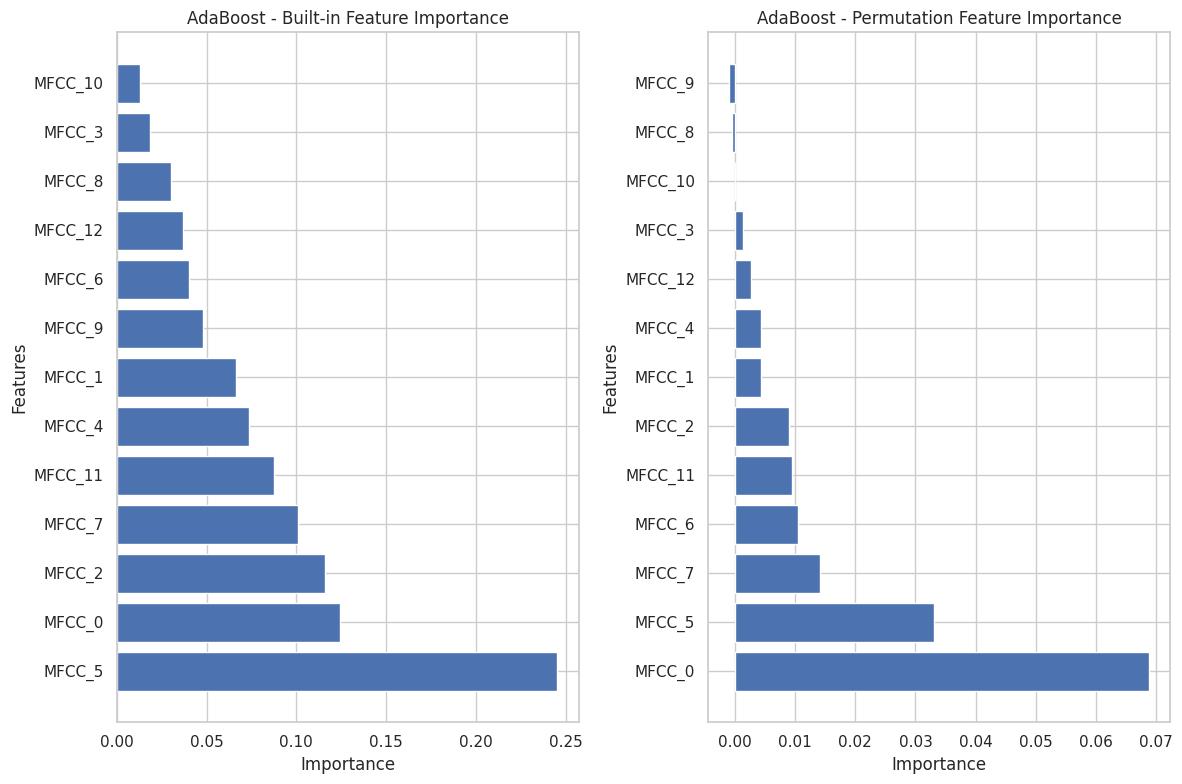


CatBoost Performance:
Best Parameters: {'depth': 8, 'iterations': 200, 'learning_rate': 0.1}
Error training CatBoost: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

Decision Tree Performance:


Traceback (most recent call last):
  File "<ipython-input-17-d2275bf43a5a>", line 472, in <cell line: 0>
    unique_labels = np.unique(np.concatenate([y_test, y_test_pred]))
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


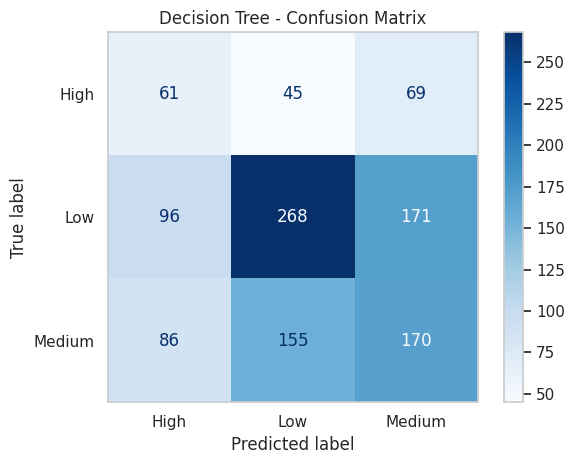


Classification Report:
              precision    recall  f1-score   support

        High       0.25      0.35      0.29       175
         Low       0.57      0.50      0.53       535
      Medium       0.41      0.41      0.41       411

    accuracy                           0.45      1121
   macro avg       0.41      0.42      0.41      1121
weighted avg       0.46      0.45      0.45      1121



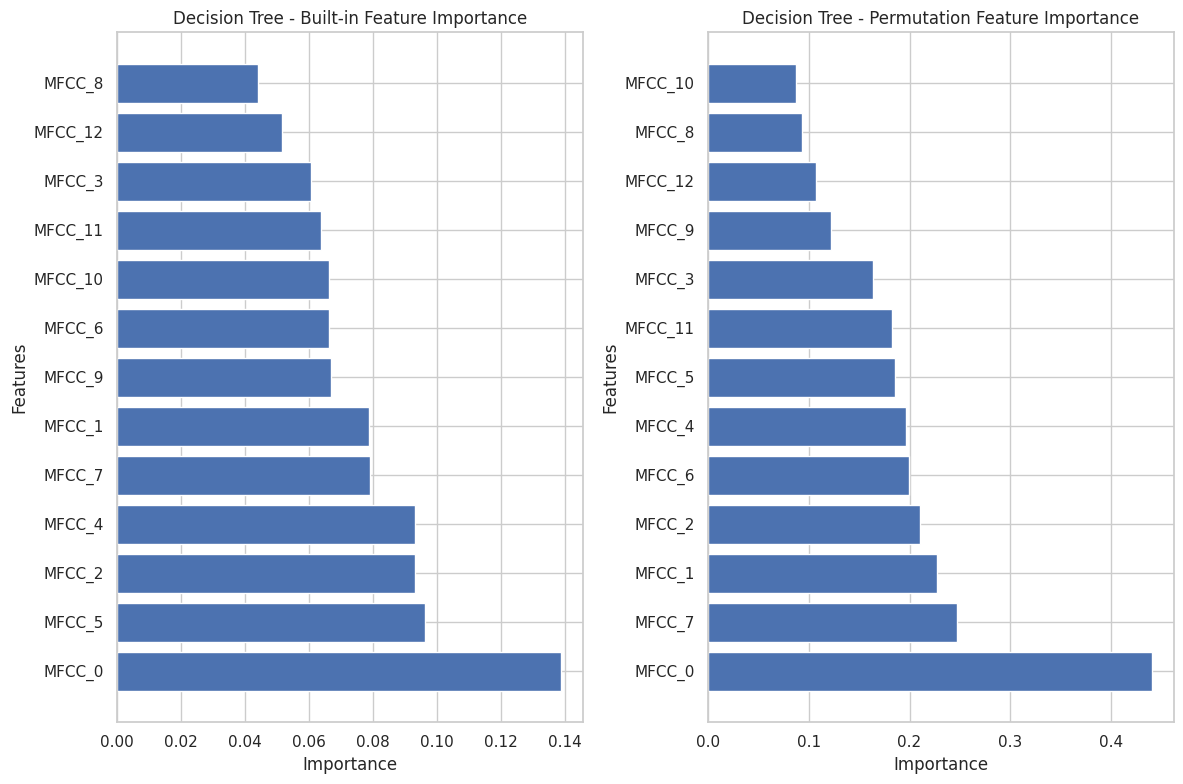


XGBoost Performance:


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:43:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


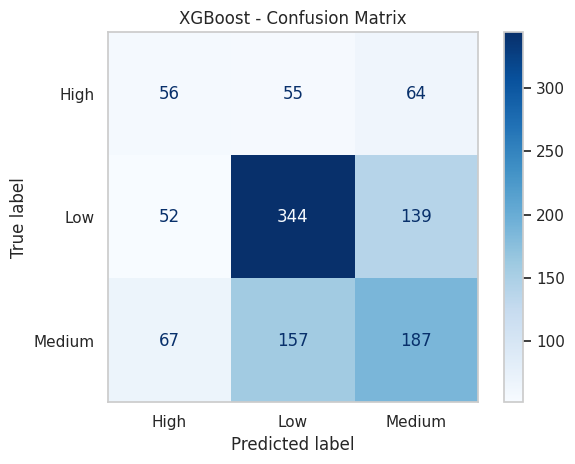


Classification Report:
              precision    recall  f1-score   support

        High       0.32      0.32      0.32       175
         Low       0.62      0.64      0.63       535
      Medium       0.48      0.45      0.47       411

    accuracy                           0.52      1121
   macro avg       0.47      0.47      0.47      1121
weighted avg       0.52      0.52      0.52      1121



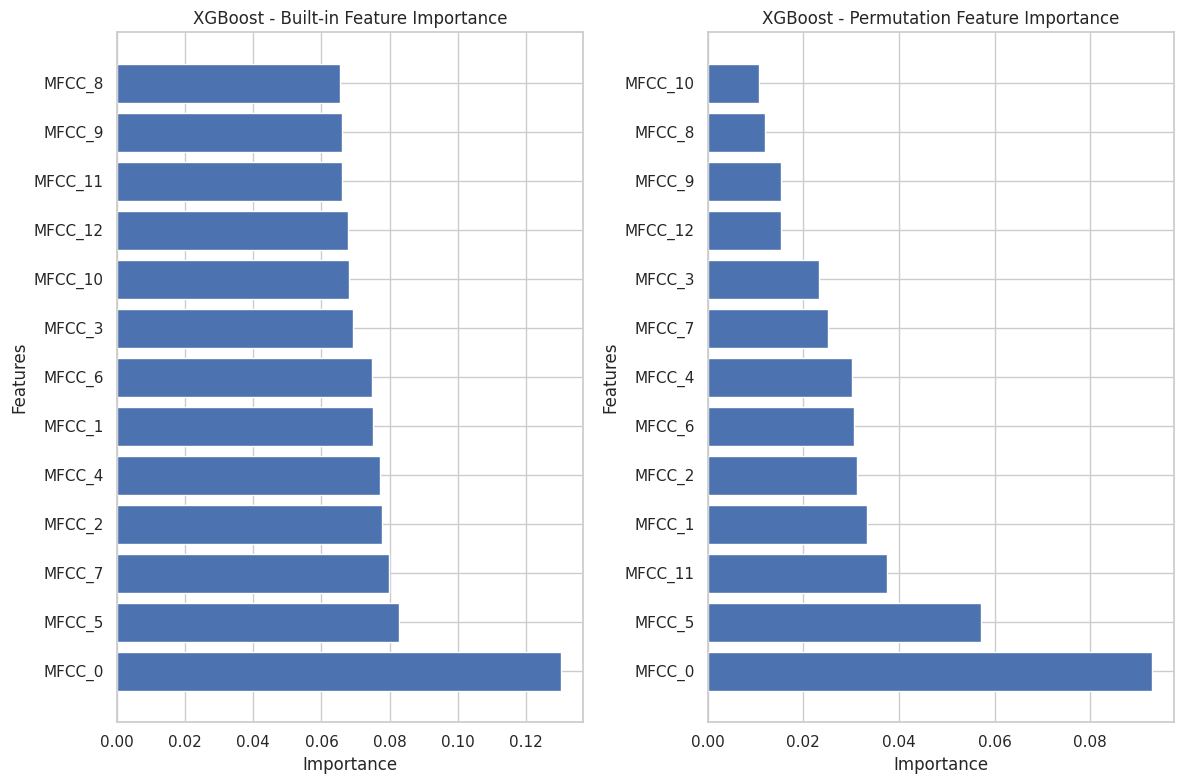


MLP Performance:
Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}


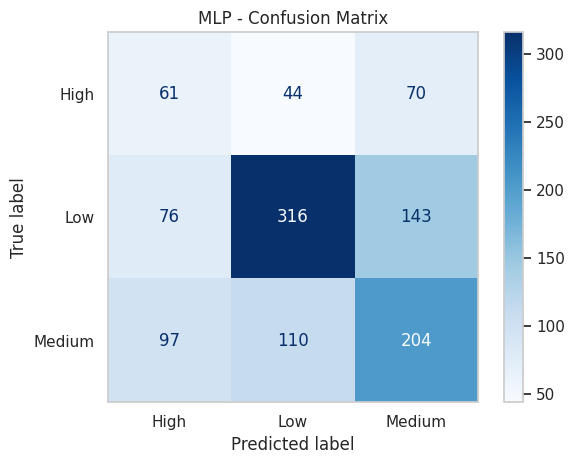


Classification Report:
              precision    recall  f1-score   support

        High       0.26      0.35      0.30       175
         Low       0.67      0.59      0.63       535
      Medium       0.49      0.50      0.49       411

    accuracy                           0.52      1121
   macro avg       0.47      0.48      0.47      1121
weighted avg       0.54      0.52      0.53      1121



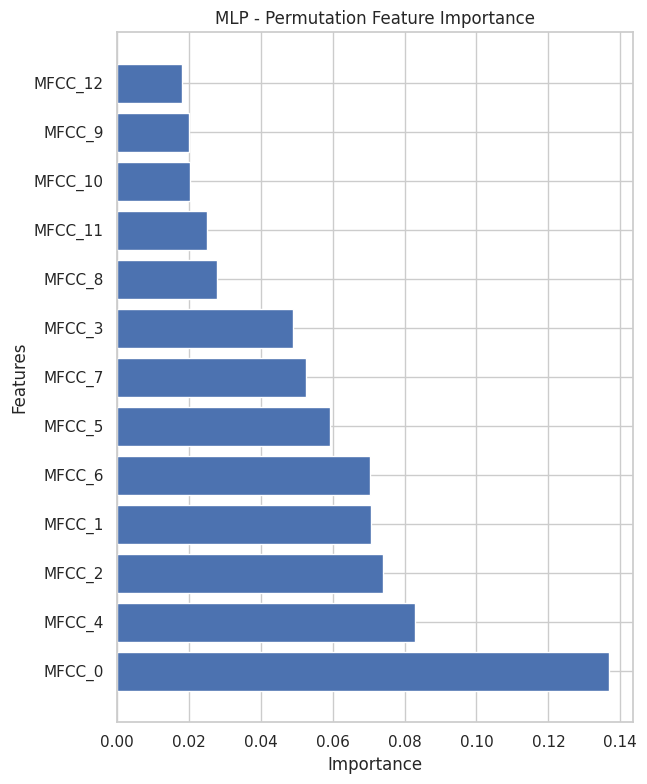


Random Forest Performance:
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


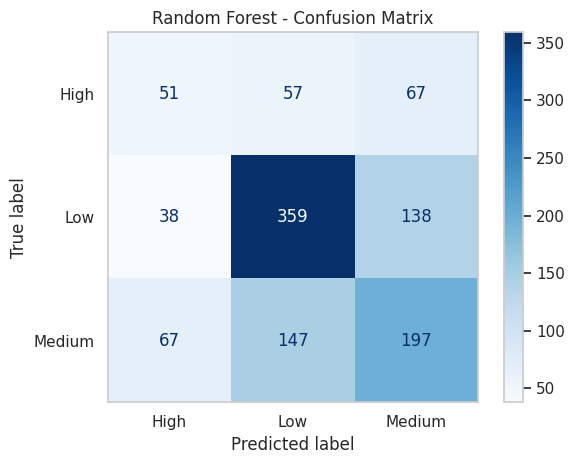


Classification Report:
              precision    recall  f1-score   support

        High       0.33      0.29      0.31       175
         Low       0.64      0.67      0.65       535
      Medium       0.49      0.48      0.48       411

    accuracy                           0.54      1121
   macro avg       0.48      0.48      0.48      1121
weighted avg       0.54      0.54      0.54      1121



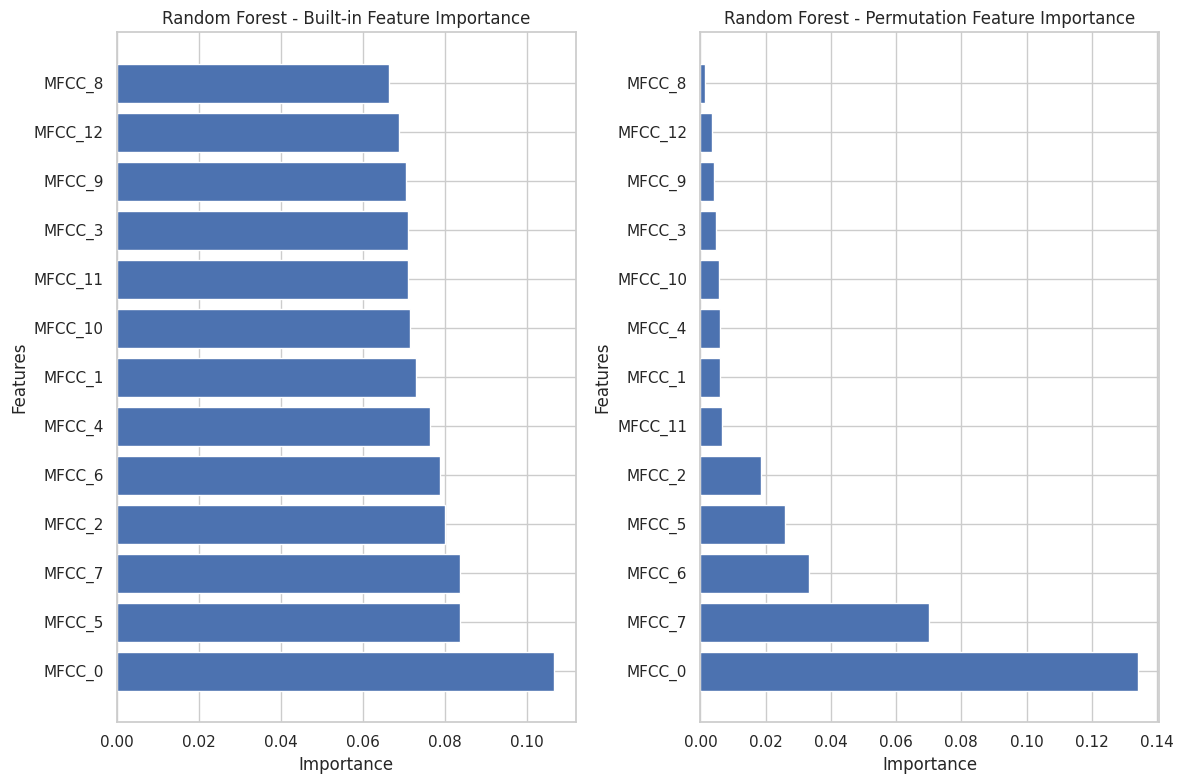


Naïve Bayes Performance:
Best Parameters: {'var_smoothing': 1e-09}


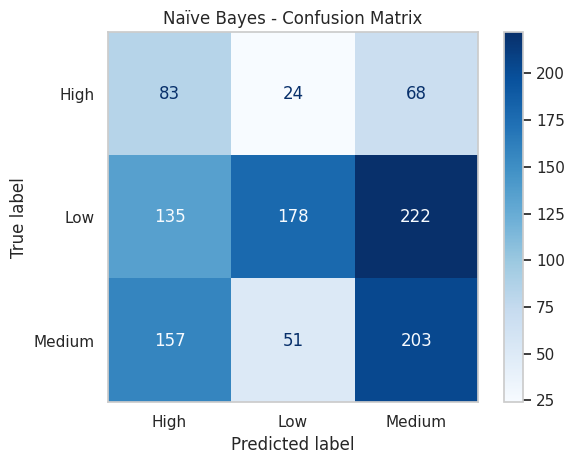


Classification Report:
              precision    recall  f1-score   support

        High       0.22      0.47      0.30       175
         Low       0.70      0.33      0.45       535
      Medium       0.41      0.49      0.45       411

    accuracy                           0.41      1121
   macro avg       0.45      0.43      0.40      1121
weighted avg       0.52      0.41      0.43      1121



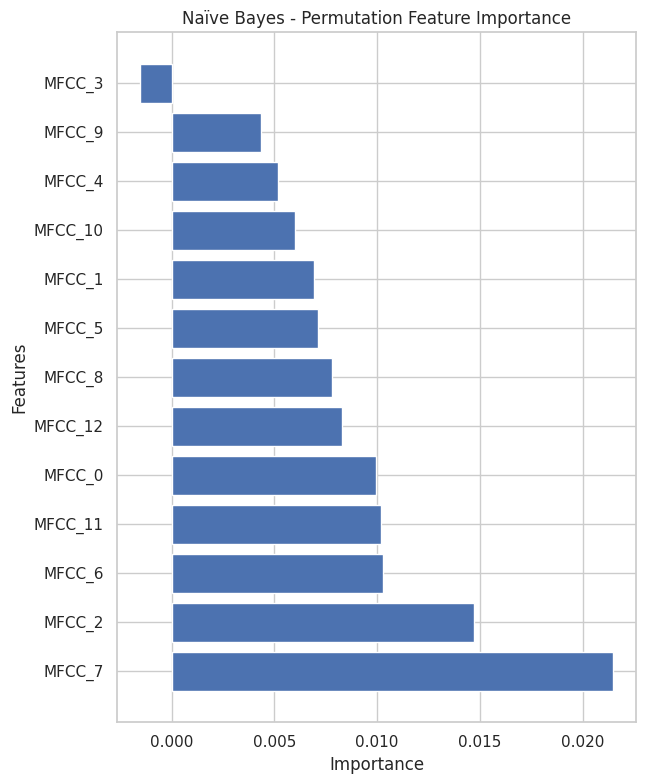

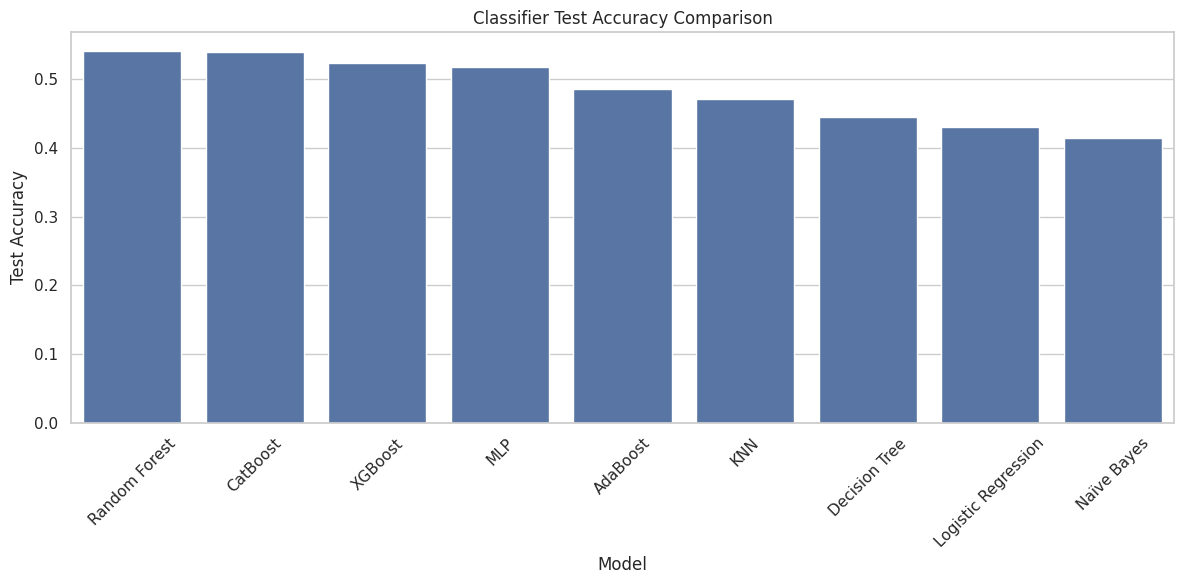

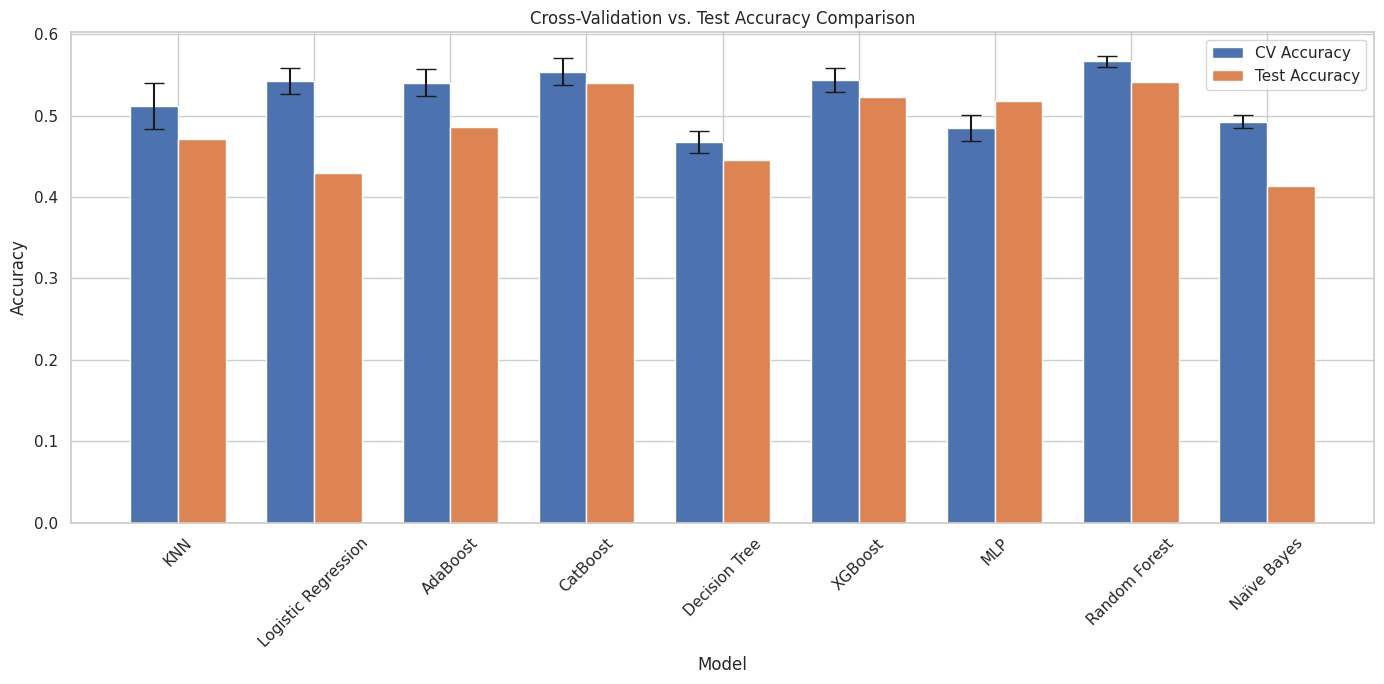


Final Metrics Comparison Table:
              Model  Train Accuracy  Test Accuracy  Precision   Recall  F1 Score
                KNN        0.987031       0.471900   0.514354 0.471900  0.485955
Logistic Regression        0.488962       0.429973   0.483123 0.429973  0.440400
           AdaBoost        0.539459       0.486173   0.523293 0.486173  0.497908
           CatBoost        0.938190       0.539697   0.542347 0.539697  0.540729
      Decision Tree        0.987031       0.445138   0.464507 0.445138  0.452441
            XGBoost        0.987031       0.523640   0.521032 0.523640  0.522106
                MLP        0.583057       0.518287   0.540934 0.518287  0.527351
      Random Forest        0.987031       0.541481   0.535029 0.541481  0.537871
        Naïve Bayes        0.476269       0.413916   0.521295 0.413916  0.427391

Comparison of CV and Test Results:
              Model  CV Accuracy Mean  CV Accuracy Std  Test Accuracy  Difference
                KNN          0.512322  

<Figure size 800x670 with 0 Axes>

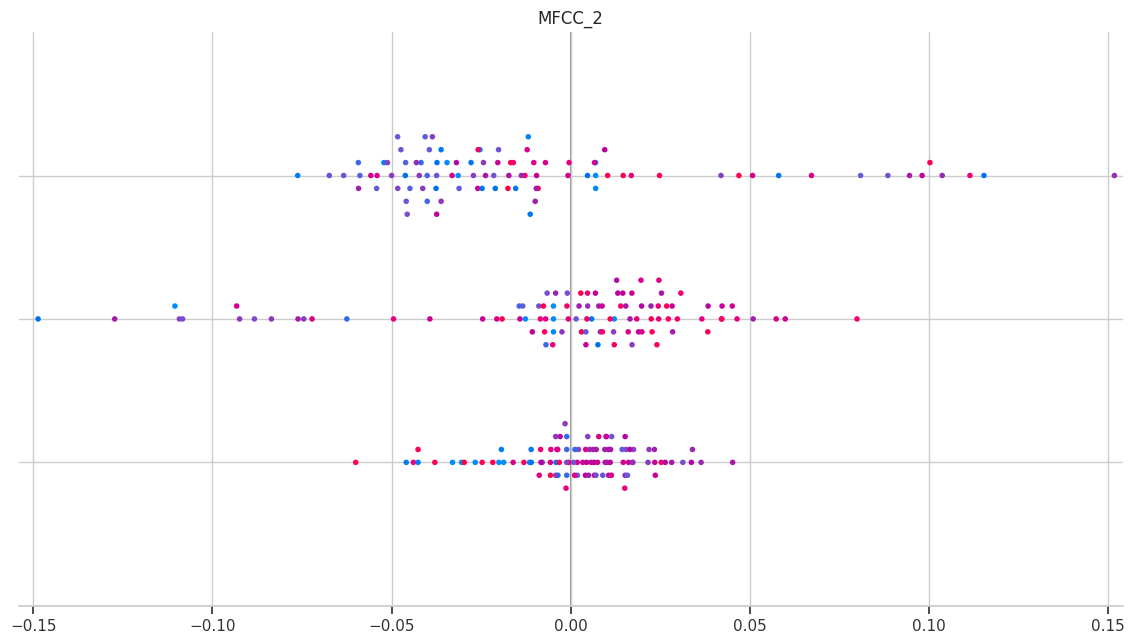

Error in SHAP analysis for Random Forest: Must pass 2-d input. shape=(100, 13, 3)

All classifier performance metrics saved to 'mfcc_smote_classifier_results.xlsx'

CV vs Test comparison saved to 'cv_vs_test_comparison.xlsx'

Generating feature importance ranking for best model: Random Forest


Traceback (most recent call last):
  File "<ipython-input-17-d2275bf43a5a>", line 158, in analyze_shap_values
    shap_df = pd.DataFrame(shap_values, columns=feature_names)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/frame.py", line 827, in __init__
    mgr = ndarray_to_mgr(
          ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/internals/construction.py", line 314, in ndarray_to_mgr
    values = _ensure_2d(values)
             ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/internals/construction.py", line 592, in _ensure_2d
    raise ValueError(f"Must pass 2-d input. shape={values.shape}")
ValueError: Must pass 2-d input. shape=(100, 13, 3)


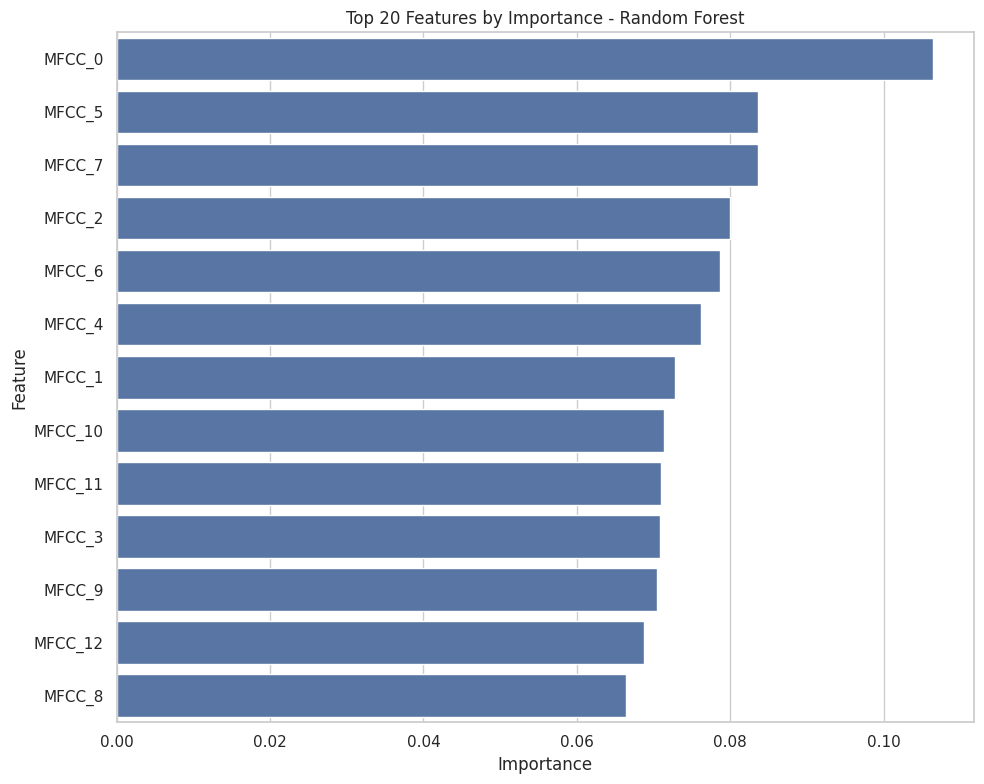

Feature importance ranking saved to 'best_model_Random_Forest_feature_importance.csv'


In [17]:
import librosa
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance

# Function to extract and plot feature importance for all models
def plot_feature_importance(model, name, X, X_train, y_train, feature_names):
    plt.figure(figsize=(12, 8))

    # Method 1: Built-in feature importances (if available)
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.subplot(1, 2, 1)
        plt.title(f"{name} - Built-in Feature Importance")
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.ylabel('Features')
        plt.xlabel('Importance')

        # Save feature importance to CSV
        importance_df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": importances
        }).sort_values(by="Importance", ascending=False)
        importance_df.to_csv(f"feature_importance_{name.replace(' ', '_')}_builtin.csv", index=False)

    # Method 2: Permutation importance (works for all models)
    try:
        result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1)
        perm_importance = result.importances_mean
        indices = np.argsort(perm_importance)[::-1]

        plt.subplot(1, 2, 2)
        plt.title(f"{name} - Permutation Feature Importance")
        plt.barh(range(len(indices)), perm_importance[indices], align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.ylabel('Features')
        plt.xlabel('Importance')

        # Save permutation importance to CSV
        perm_importance_df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": perm_importance
        }).sort_values(by="Importance", ascending=False)
        perm_importance_df.to_csv(f"feature_importance_{name.replace(' ', '_')}_permutation.csv", index=False)
    except Exception as e:
        print(f"Could not compute permutation importance for {name}: {e}")

    plt.tight_layout()
    plt.show()

    return {"built_in": importances if hasattr(model, "feature_importances_") else None,
            "permutation": perm_importance if 'perm_importance' in locals() else None}


# Function to calculate and visualize SHAP values for the best model
def analyze_shap_values(model, X_train, X_test, feature_names, model_name):
    print(f"\nCalculating SHAP values for {model_name}...")
    plt.figure(figsize=(12, 10))

    try:
        # Create explainer appropriate for the model type
        if isinstance(model, (XGBClassifier, RandomForestClassifier, AdaBoostClassifier, DecisionTreeClassifier, CatBoostClassifier)):
            # Tree-based models
            explainer = shap.TreeExplainer(model)
            # Sample from test set for faster computation
            sample_size = min(100, X_test.shape[0])
            X_sample = shap.sample(X_test, sample_size, random_state=42)
            # Calculate SHAP values
            shap_values = explainer.shap_values(X_sample)

            # For multi-class, shap_values is a list of arrays, one per class
            if isinstance(shap_values, list):
                # Plot summary for first class (can be changed to other classes)
                plt.subplot(2, 1, 1)
                plt.title(f"SHAP Summary Plot for {model_name} - Class 0")
                shap.summary_plot(shap_values[0], X_sample, feature_names=feature_names, plot_type="bar", show=False)
                plt.subplot(2, 1, 2)
                shap.summary_plot(shap_values[0], X_sample, feature_names=feature_names, show=False)
            else:
                plt.subplot(2, 1, 1)
                plt.title(f"SHAP Summary Plot for {model_name}")
                shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar", show=False)
                plt.subplot(2, 1, 2)
                shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)

        elif isinstance(model, (LogisticRegression, SVC)):
            # Linear models
            explainer = shap.LinearExplainer(model, X_train)
            sample_size = min(100, X_test.shape[0])
            X_sample = shap.sample(X_test, sample_size, random_state=42)
            shap_values = explainer.shap_values(X_sample)

            plt.subplot(2, 1, 1)
            plt.title(f"SHAP Summary Plot for {model_name}")
            shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar", show=False)
            plt.subplot(2, 1, 2)
            shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)

        else:
            # KernelExplainer works with any model but is slower
            # Create a smaller background dataset for KernelExplainer
            background = shap.sample(X_train, 100, random_state=42)
            explainer = shap.KernelExplainer(model.predict_proba, background)
            sample_size = min(50, X_test.shape[0])  # Smaller sample due to computational intensity
            X_sample = shap.sample(X_test, sample_size, random_state=42)
            shap_values = explainer.shap_values(X_sample)

            if isinstance(shap_values, list):
                plt.subplot(2, 1, 1)
                plt.title(f"SHAP Summary Plot for {model_name} - Class 0")
                shap.summary_plot(shap_values[0], X_sample, feature_names=feature_names, plot_type="bar", show=False)
                plt.subplot(2, 1, 2)
                shap.summary_plot(shap_values[0], X_sample, feature_names=feature_names, show=False)
            else:
                plt.subplot(2, 1, 1)
                plt.title(f"SHAP Summary Plot for {model_name}")
                shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar", show=False)
                plt.subplot(2, 1, 2)
                shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)

        plt.tight_layout()
        plt.show()

        # Create SHAP dependence plots for top features
        if isinstance(shap_values, list):
            # For multi-class, use first class shap values
            shap_df = pd.DataFrame(shap_values[0], columns=feature_names)
        else:
            shap_df = pd.DataFrame(shap_values, columns=feature_names)

        # Get top 5 features by mean absolute SHAP value
        top_features = shap_df.abs().mean().sort_values(ascending=False).head(5).index

        plt.figure(figsize=(15, 10))
        for i, feature in enumerate(top_features):
            plt.subplot(2, 3, i+1)
            if isinstance(shap_values, list):
                shap.dependence_plot(feature, shap_values[0], X_sample, feature_names=feature_names,
                                    show=False, ax=plt.gca())
            else:
                shap.dependence_plot(feature, shap_values, X_sample, feature_names=feature_names,
                                    show=False, ax=plt.gca())

        plt.tight_layout()
        plt.suptitle(f"SHAP Dependence Plots for Top Features - {model_name}", y=1.02)
        plt.show()

        # Save SHAP values to CSV
        if isinstance(shap_values, list):
            for i, class_shap in enumerate(shap_values):
                shap_df = pd.DataFrame(class_shap, columns=feature_names)
                shap_df["class"] = i
                shap_df.to_csv(f"shap_values_{model_name.replace(' ', '_')}_class_{i}.csv", index=False)
        else:
            shap_df = pd.DataFrame(shap_values, columns=feature_names)
            shap_df.to_csv(f"shap_values_{model_name.replace(' ', '_')}.csv", index=False)

    except Exception as e:
        print(f"Error in SHAP analysis for {model_name}: {e}")
        import traceback
        traceback.print_exc()


# Function to perform cross-validation
def perform_cross_validation(X, y, classifiers, n_splits=5):
    """
    Perform cross-validation on multiple classifiers

    Parameters:
    -----------
    X : DataFrame
        Features
    y : array-like
        Target labels
    classifiers : dict
        Dictionary of classifiers
    n_splits : int
        Number of folds for cross-validation

    Returns:
    --------
    cv_results : DataFrame
        Cross-validation results
    """
    print(f"\nPerforming {n_splits}-fold cross-validation...")
    cv_results = []

    # Define cross-validation strategy
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for name, clf_info in classifiers.items():
        try:
            print(f"\nCross-validating {name}...")
            clf = clf_info["model"]

            # Calculate cross-validation scores
            cv_accuracy = cross_val_score(clf, X, y, cv=skf, scoring='accuracy', n_jobs=-1)
            cv_precision = cross_val_score(clf, X, y, cv=skf, scoring='precision_weighted', n_jobs=-1)
            cv_recall = cross_val_score(clf, X, y, cv=skf, scoring='recall_weighted', n_jobs=-1)
            cv_f1 = cross_val_score(clf, X, y, cv=skf, scoring='f1_weighted', n_jobs=-1)

            # Store results
            cv_results.append({
                'Model': name,
                'CV Accuracy Mean': cv_accuracy.mean(),
                'CV Accuracy Std': cv_accuracy.std(),
                'CV Precision Mean': cv_precision.mean(),
                'CV Precision Std': cv_precision.std(),
                'CV Recall Mean': cv_recall.mean(),
                'CV Recall Std': cv_recall.std(),
                'CV F1 Mean': cv_f1.mean(),
                'CV F1 Std': cv_f1.std()
            })

            print(f"{name} CV Accuracy: {cv_accuracy.mean():.4f} ± {cv_accuracy.std():.4f}")
            print(f"{name} CV Precision: {cv_precision.mean():.4f} ± {cv_precision.std():.4f}")
            print(f"{name} CV Recall: {cv_recall.mean():.4f} ± {cv_recall.std():.4f}")
            print(f"{name} CV F1 Score: {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")

        except Exception as e:
            print(f"Error in cross-validation for {name}: {e}")
            import traceback
            traceback.print_exc()

    return pd.DataFrame(cv_results)


sns.set(style="whitegrid")
mfcc_df = pd.read_csv("/content/mfcc_mean_features (2).csv")  # <-- NOTE: You must generate MFCC features using MODE not MEAN
if mfcc_df.empty:
    raise ValueError("MFCC feature file is empty or not loaded correctly.")

print("Reading label files...")
excel_files = glob.glob("output_*_s.xlsx")
if not excel_files:
    raise FileNotFoundError("No Excel files found.")

labels_list = []
for excel_file in excel_files:
    try:
        df = pd.read_excel(excel_file)
        df = df[["File Name", "Clarity"]]
        df["File Name"] = df["File Name"].astype(str)
        labels_list.append(df)
    except Exception as e:
        print(f"Error reading {excel_file}: {e}")

labels_df = pd.concat(labels_list, ignore_index=True)

#  Normalize File Name for consistent merging
def normalize_filename(name):
    return os.path.splitext(name.replace("_s", "s").replace(" ", "").lower())[0]

mfcc_df["File Name"] = mfcc_df["File Name"].astype(str).apply(normalize_filename)
labels_df["File Name"] = labels_df["File Name"].astype(str).apply(normalize_filename)
labels_df["Clarity"] = labels_df["Clarity"].astype(str).str.strip().str.title()
labels_df["Clarity"] = labels_df["Clarity"].replace({
    "Medium Low": "Low",
    "Low Medium": "Medium",
    "High Medium": "High",
    "Lowhigh": "High",
    "Med": "Medium",
    "Mid": "Medium"
})

data = mfcc_df.merge(labels_df, on="File Name", how="inner")
if data.empty:
    print("Sample MFCC DF:", mfcc_df["File Name"].head())
    print("Sample Labels DF:", labels_df["File Name"].head())
    raise ValueError("No matching data found after merging features with labels.")

X = data.drop(columns=["File Name", "Clarity"])
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
X = X.select_dtypes(include=[np.number])

le = LabelEncoder()
y = le.fit_transform(data["Clarity"])

print("Visualizing class distribution...")
plt.figure(figsize=(6, 4))
sns.countplot(x=data["Clarity"])
plt.title("Class Distribution (Clarity Labels)")
plt.xlabel("Clarity")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

classifiers = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7],
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan"]
        }
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "solver": ["lbfgs", "liblinear"]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0]
        }
    },
    "CatBoost": {
        "model": CatBoostClassifier(verbose=0, random_state=42),
        "params": {
            "iterations": [100, 200],
            "depth": [4, 6, 8],
            "learning_rate": [0.01, 0.1]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1]
        }
    },
    "MLP": {
        "model": MLPClassifier(max_iter=500, random_state=42),
        "params": {
            "hidden_layer_sizes": [(50,), (100,), (50, 50)],
            "activation": ["relu", "tanh"],
            "learning_rate_init": [0.001, 0.01]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5]
        }
    },
    "Naïve Bayes": {
        "model": GaussianNB(),
        "params": {
            "var_smoothing": [1e-9, 1e-8, 1e-7]
        }
    },

}

# First: Perform cross-validation on the full dataset
print("\n" + "="*50)
print("STEP 1: PERFORMING CROSS-VALIDATION ON ORIGINAL DATASET")
print("="*50)
cv_results_df = perform_cross_validation(X, y, classifiers, n_splits=5)

# Visualize cross-validation results
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="Model", y="CV Accuracy Mean", data=cv_results_df.sort_values(by="CV Accuracy Mean", ascending=False))
plt.errorbar(
    x=np.arange(len(cv_results_df)),
    y=cv_results_df.sort_values(by="CV Accuracy Mean", ascending=False)["CV Accuracy Mean"],
    yerr=cv_results_df.sort_values(by="CV Accuracy Mean", ascending=False)["CV Accuracy Std"],
    fmt='none', ecolor='black', capsize=5
)
plt.xticks(rotation=45)
plt.title("Cross-Validation Accuracy Comparison")
plt.tight_layout()
plt.show()

# Save cross-validation results
cv_results_df.to_csv("cross_validation_results.csv", index=False)
print("Cross-validation results saved to 'cross_validation_results.csv'")

# Second: Proceed with train-test split and hyperparameter tuning
print("\n" + "="*50)
print("STEP 2: PROCEEDING WITH TRAIN-TEST SPLIT AND HYPERPARAMETER TUNING")
print("="*50)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Applying SMOTE to balance training data...")
print("Original class distribution:", np.bincount(y_train))
smote = SMOTE(random_state=42, k_neighbors=2)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print("Balanced class distribution:", np.bincount(y_train_balanced))

# Train and evaluate
results = []
print("\nTraining classifiers with hyperparameter tuning and evaluating performance...")
best_model = None
best_acc = 0
best_model_name = ""
models_dict = {}  # Store trained models

feature_names = X.columns.tolist()

for name, clf_info in classifiers.items():
    try:
        print(f"\n{name} Performance:")
        clf = clf_info["model"]
        param_grid = clf_info["params"]

        grid_search = GridSearchCV(
            estimator=clf,
            param_grid=param_grid,
            cv=5,  # 5-fold cross-validation within the training set
            scoring="accuracy",
            n_jobs=-1
        )
        grid_search.fit(X_train_balanced, y_train_balanced)

        best_clf = grid_search.best_estimator_
        models_dict[name] = best_clf  # Store model for later use

        print(f"Best Parameters: {grid_search.best_params_}")

        y_train_pred = best_clf.predict(X_train_balanced)
        y_test_pred = best_clf.predict(X_test)

        train_acc = accuracy_score(y_train_balanced, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred, average='weighted')
        precision = precision_score(y_test, y_test_pred, average='weighted')
        recall = recall_score(y_test, y_test_pred, average='weighted')

        results.append((name, train_acc, test_acc, precision, recall, f1))

        # Keep track of best model
        if test_acc > best_acc:
            best_acc = test_acc
            best_model = best_clf
            best_model_name = name

        unique_labels = np.unique(np.concatenate([y_test, y_test_pred]))
        target_names = le.inverse_transform(unique_labels)

        ConfusionMatrixDisplay.from_predictions(
            y_test, y_test_pred,
            display_labels=target_names,
            cmap="Blues",
            values_format='d'
        )
        plt.title(f"{name} - Confusion Matrix")
        plt.grid(False)
        plt.tight_layout()
        plt.show()

        # Generate detailed classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_test_pred, target_names=target_names))

        # Plot feature importance for all models
        importances = plot_feature_importance(best_clf, name, X, X_train_balanced, y_train_balanced, feature_names)

    except Exception as e:
        print(f"Error training {name}: {e}")
        import traceback
        traceback.print_exc()

# Results summary
results_df = pd.DataFrame(results, columns=["Model", "Train Accuracy", "Test Accuracy", "Precision", "Recall", "F1 Score"])
plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Test Accuracy", data=results_df.sort_values(by="Test Accuracy", ascending=False))
plt.xticks(rotation=45)
plt.title("Classifier Test Accuracy Comparison")
plt.tight_layout()
plt.show()

# Compare cross-validation results with train-test split results
comparison_df = pd.merge(
    cv_results_df[["Model", "CV Accuracy Mean", "CV Accuracy Std"]],
    results_df[["Model", "Test Accuracy"]],
    on="Model"
)
comparison_df["Difference"] = comparison_df["Test Accuracy"] - comparison_df["CV Accuracy Mean"]

plt.figure(figsize=(14, 7))
bar_width = 0.35
r1 = np.arange(len(comparison_df))
r2 = [x + bar_width for x in r1]

plt.bar(r1, comparison_df["CV Accuracy Mean"], width=bar_width, label='CV Accuracy', yerr=comparison_df["CV Accuracy Std"], capsize=7)
plt.bar(r2, comparison_df["Test Accuracy"], width=bar_width, label='Test Accuracy')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Cross-Validation vs. Test Accuracy Comparison')
plt.xticks([r + bar_width/2 for r in range(len(comparison_df))], comparison_df["Model"], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print("\nFinal Metrics Comparison Table:")
print(results_df.to_string(index=False))

print("\nComparison of CV and Test Results:")
print(comparison_df.to_string(index=False))

print("\nDisplaying MFCC Values for Each Audio File:")
mfcc_df.to_csv("mfcc_features_saved.csv", index=False)
print("\nMFCC values saved to 'mfcc_features_saved.csv'")

# SHAP analysis for the best model
print(f"\n\nAnalyzing SHAP values for best model: {best_model_name} (Test Accuracy: {best_acc:.4f})")
analyze_shap_values(best_model, X_train_balanced, X_test, feature_names, best_model_name)

# Save all results
excel_output_path = "mfcc_smote_classifier_results.xlsx"
results_df.to_excel(excel_output_path, index=False)
print(f"\nAll classifier performance metrics saved to '{excel_output_path}'")

# Save cross-validation and test comparison results
comparison_df.to_excel("cv_vs_test_comparison.xlsx", index=False)
print(f"\nCV vs Test comparison saved to 'cv_vs_test_comparison.xlsx'")

# Feature importance ranking and visualization
if best_model_name:
    print(f"\nGenerating feature importance ranking for best model: {best_model_name}")
    if hasattr(best_model, "feature_importances_"):
        # For models with built-in feature importance
        importances = best_model.feature_importances_
        feature_importance_df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": importances
        }).sort_values(by="Importance", ascending=False)

        # Plot top features
        plt.figure(figsize=(10, 8))
        top_n = 20  # Show top 20 features
        sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(top_n))
        plt.title(f"Top {top_n} Features by Importance - {best_model_name}")
        plt.tight_layout()
        plt.show()

        # Save feature importance to CSV
        feature_importance_df.to_csv(f"best_model_{best_model_name.replace(' ', '_')}_feature_importance.csv", index=False)
        print(f"Feature importance ranking saved to 'best_model_{best_model_name.replace(' ', '_')}_feature_importance.csv'")
    else:
        print(f"Model {best_model_name} does not have built-in feature importance.")

In [19]:
pip install lime


In [23]:
from lime.lime_tabular import LimeTabularExplainer
import lime

# Example: Assume you've trained this model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Convert class labels to strings (required by LIME)
class_names = model.classes_.astype(str).tolist()
feature_names = X_train.columns.tolist()

# Initialize LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification',
    discretize_continuous=True
)

# Explain one instance from the test set
i = 0  # index of the test sample to explain
exp = explainer.explain_instance(
    data_row=X_test.values[i],
    predict_fn=model.predict_proba,
    num_features=10
)

# Show explanation
print(f"Explaining test instance #{i}")
exp.show_in_notebook(show_table=True)

# Optional: Save explanation as HTML
exp.save_to_file(f"lime_explanation_instance_{i}.html")


Explaining test instance #0


DCT without smote

Visualizing class distribution...


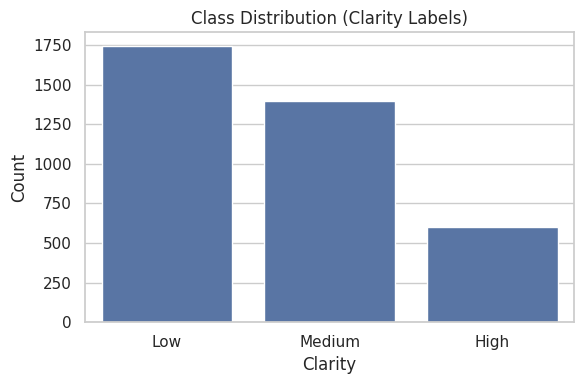


Training classifiers with hyperparameter tuning (no SMOTE)...

KNN Performance:
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}


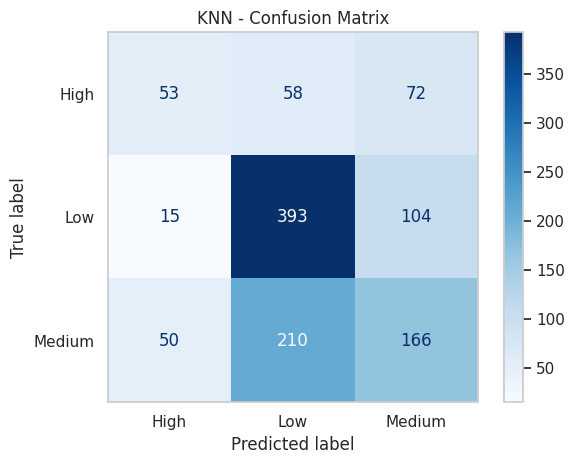


Logistic Regression Performance:
Best Parameters: {'C': 10, 'solver': 'liblinear'}


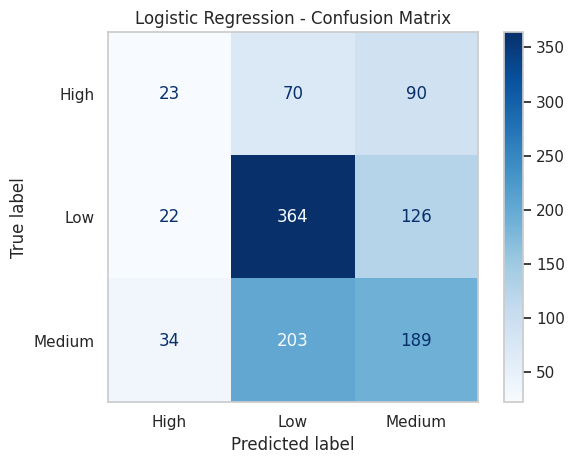


AdaBoost Performance:
Best Parameters: {'learning_rate': 1.0, 'n_estimators': 100}


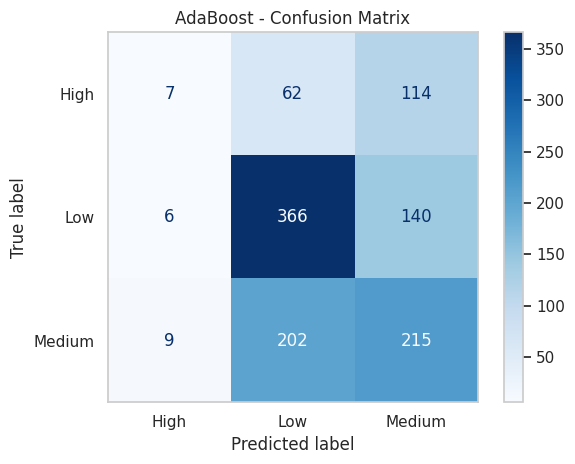


CatBoost Performance:
Best Parameters: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
Error training CatBoost: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

Decision Tree Performance:
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


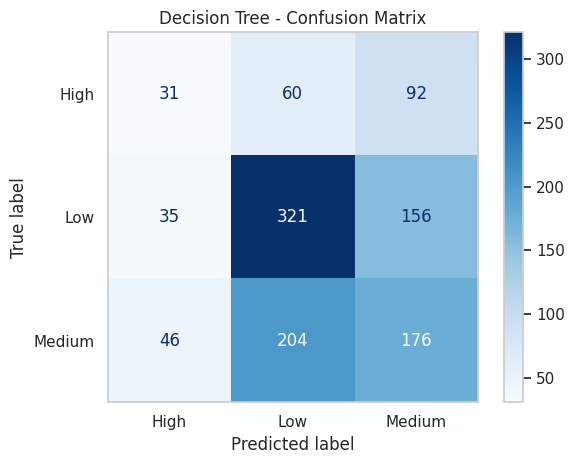


XGBoost Performance:
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}


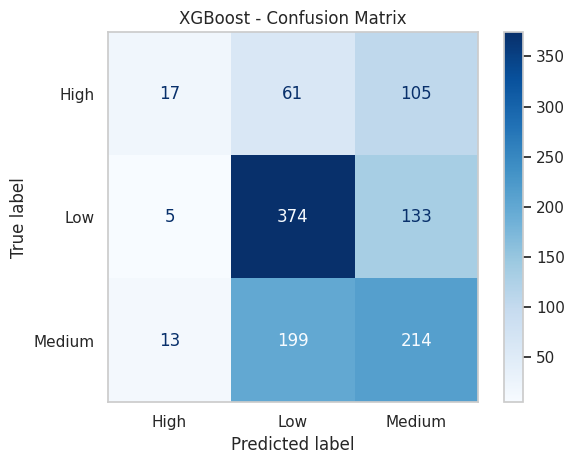


MLP Performance:
Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01}


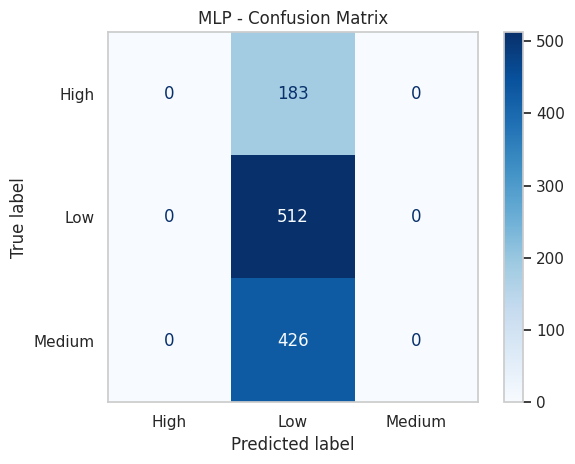


Random Forest Performance:
Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}


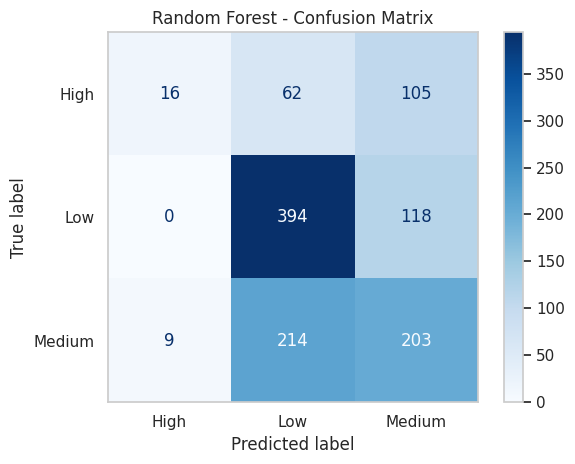


Naïve Bayes Performance:
Best Parameters: {'var_smoothing': 1e-09}


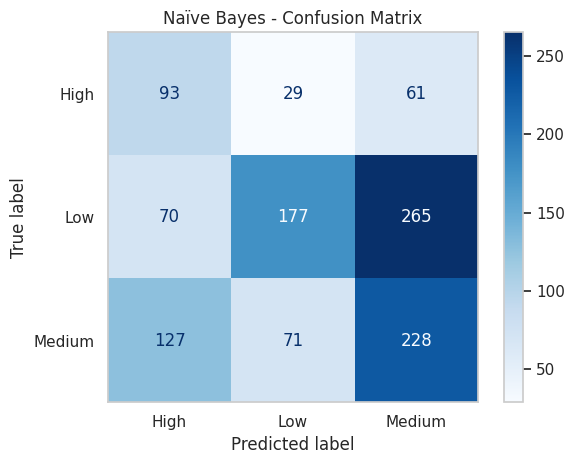

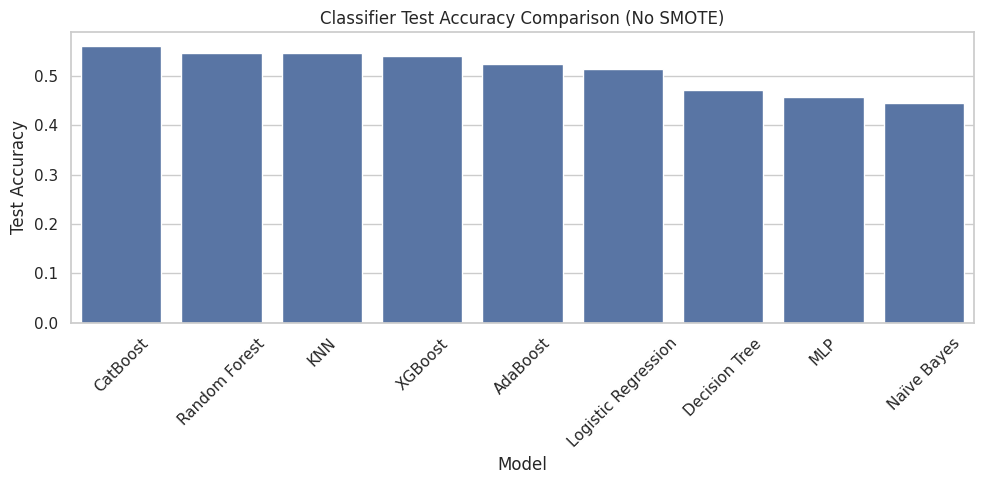


Final Metrics Comparison Table (No SMOTE):
              Model  Train Accuracy  Test Accuracy  Precision   Recall  F1 Score
                KNN        0.673040       0.545941   0.529329 0.545941  0.527815
Logistic Regression        0.616444       0.513827   0.485861 0.513827  0.490907
           AdaBoost        0.583174       0.524532   0.491492 0.524532  0.486485
           CatBoost        0.916635       0.560214   0.555429 0.560214  0.527652
      Decision Tree        0.790822       0.471008   0.453546 0.471008  0.458978
            XGBoost        0.808795       0.539697   0.528642 0.539697  0.508822
                MLP        0.470746       0.456735   0.208607 0.456735  0.286403
      Random Forest        0.990057       0.546833   0.554154 0.546833  0.510693
        Naïve Bayes        0.432887       0.444246   0.500598 0.444246  0.445942

All classifier performance metrics saved to 'classifier_performance_metrics.xlsx'


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

sns.set(style="whitegrid")


X = data.drop(columns=["File Name", "Clarity"])
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
X = X.select_dtypes(include=[np.number])  # Ensure only numerical features are used

# Label encoding for the 'Clarity' column
le = LabelEncoder()
y = le.fit_transform(data["Clarity"])

# Visualize class distribution
print("Visualizing class distribution...")
plt.figure(figsize=(6, 4))
sns.countplot(x=data["Clarity"])
plt.title("Class Distribution (Clarity Labels)")
plt.xlabel("Clarity")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Define classifiers and hyperparameters
classifiers = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7],
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan"]
        }
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "solver": ["lbfgs", "liblinear"]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0]
        }
    },
    "CatBoost": {
        "model": CatBoostClassifier(verbose=0, random_state=42),
        "params": {
            "iterations": [100, 200],
            "depth": [4, 6, 8],
            "learning_rate": [0.01, 0.1]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1]
        }
    },
    "MLP": {
        "model": MLPClassifier(max_iter=500, random_state=42),
        "params": {
            "hidden_layer_sizes": [(50,), (100,), (50, 50)],
            "activation": ["relu", "tanh"],
            "learning_rate_init": [0.001, 0.01]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5]
        }
    },
    "Naïve Bayes": {
        "model": GaussianNB(),
        "params": {
            "var_smoothing": [1e-9, 1e-8, 1e-7]
        }
    }
}

# Train-test split (no SMOTE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train and evaluate models with hyperparameter tuning (no SMOTE)
print("\nTraining classifiers with hyperparameter tuning (no SMOTE)...")
results = []

for name, clf_info in classifiers.items():
    try:
        print(f"\n{name} Performance:")
        clf = clf_info["model"]
        param_grid = clf_info["params"]

        if name == "CatBoost":
            X_train = np.array(X_train)
            X_test = np.array(X_test)

        grid_search = GridSearchCV(
            estimator=clf,
            param_grid=param_grid,
            cv=5,
            scoring="accuracy",
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        best_clf = grid_search.best_estimator_

        print("Best Parameters:", grid_search.best_params_)

        y_train_pred = best_clf.predict(X_train)
        y_test_pred = best_clf.predict(X_test)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred, average='weighted')
        precision = precision_score(y_test, y_test_pred, average='weighted')
        recall = recall_score(y_test, y_test_pred, average='weighted')

        results.append((name, train_acc, test_acc, precision, recall, f1))

        target_names = le.inverse_transform(np.unique(np.concatenate([y_test, y_test_pred])))

        # Display confusion matrix for each classifier
        ConfusionMatrixDisplay.from_predictions(
            y_test, y_test_pred,
            display_labels=target_names,
            cmap="Blues",
            values_format='d'
        )
        plt.title(f"{name} - Confusion Matrix")
        plt.grid(False)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error training {name}: {e}")

# Save results to a DataFrame
results_df = pd.DataFrame(results, columns=["Model", "Train Accuracy", "Test Accuracy", "Precision", "Recall", "F1 Score"])

# Plot test accuracy comparison
plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="Test Accuracy", data=results_df.sort_values(by="Test Accuracy", ascending=False))
plt.xticks(rotation=45)
plt.title("Classifier Test Accuracy Comparison (No SMOTE)")
plt.tight_layout()
plt.show()

print("\nFinal Metrics Comparison Table (No SMOTE):")
print(results_df.to_string(index=False))

# Save classifier performance metrics to Excel
excel_output_path = "classifier_performance_metrics.xlsx"
results_df.to_excel(excel_output_path, index=False)
print(f"\nAll classifier performance metrics saved to '{excel_output_path}'")


DCT with smote

Reading label files...


<ipython-input-4-dab32941583b>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["File Name"] = df["File Name"].astype(str).apply(normalize_filename)


Visualizing class distribution...


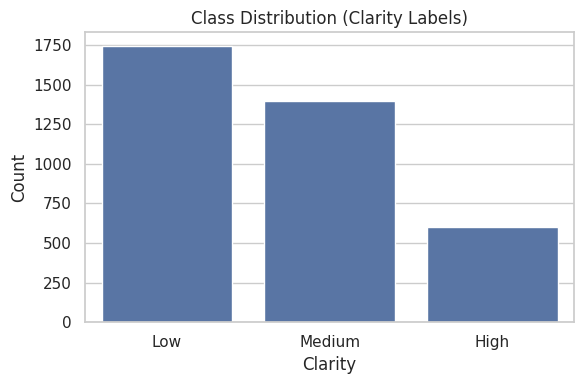

Applying SMOTE to balance training data...
Original class distribution: [ 416 1231  968]
Balanced class distribution: [1231 1231 1231]

Training classifiers with hyperparameter tuning...

Training KNN...
Best Params: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Best Cross-Validation Score: 0.687817713089174
Test Accuracy: 0.4594112399643176

Training Logistic Regression...
Best Params: {'C': 10, 'solver': 'liblinear'}
Best Cross-Validation Score: 0.5369718839272289
Test Accuracy: 0.487957181088314

Training AdaBoost...
Best Params: {'learning_rate': 1.0, 'n_estimators': 200}
Best Cross-Validation Score: 0.4998723830269426
Test Accuracy: 0.46743978590544155

Training CatBoost...
Best Params: {'depth': 8, 'iterations': 200, 'learning_rate': 0.1}
Best Cross-Validation Score: 0.7184109486561713
Test Accuracy: 0.5557537912578056

Training Decision Tree...
Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-Validation Score: 0.586266

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:35:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best Cross-Validation Score: 0.7495582912527367
Test Accuracy: 0.5575379125780553

Training MLP...
Best Params: {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}
Best Cross-Validation Score: 0.679687998503801
Test Accuracy: 0.5084745762711864

Training Random Forest...
Best Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Best Cross-Validation Score: 0.7441349366132363
Test Accuracy: 0.5727029438001784

Training Naïve Bayes...
Best Params: {'var_smoothing': 1e-08}
Best Cross-Validation Score: 0.43976515543233924
Test Accuracy: 0.3514719000892061

Model Performance Comparison:
                 Model                                        Best Params  \
0                  KNN  {'metric': 'euclidean', 'n_neighbors': 3, 'wei...   
1  Logistic Regression                   {'C': 10, 'solver': 'liblinear'}   
2             AdaBoost        {'learning_rate': 1.0, 'n_est

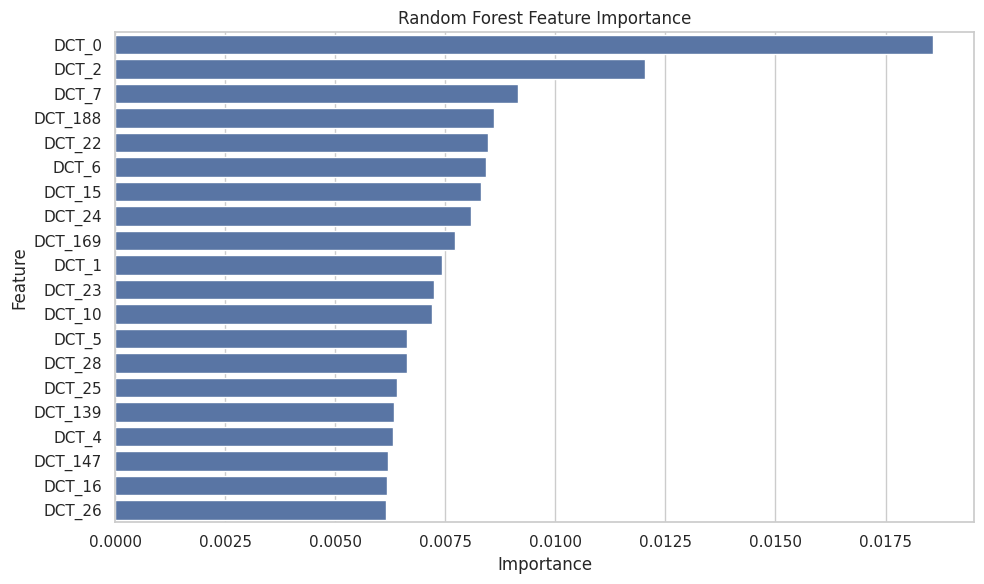

In [4]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import shap

sns.set(style="whitegrid")

# ✅ Normalize filename function
def normalize_filename(name):
    name = name.strip().lower()
    name = os.path.splitext(name)[0]
    return re.sub(r"(\d+)s(\d+)", r"\1_s\2", name)

# Load pre-calculated DCT features from CSV file
dct_file = "/content/dct_mean_features (2).csv"
if not os.path.exists(dct_file):
    raise FileNotFoundError(f"DCT features file not found: {dct_file}")

dct_df = pd.read_csv(dct_file)

# Normalize filenames in the DCT features dataframe
dct_df["File Name"] = dct_df["File Name"].apply(normalize_filename)

#  Read and normalize label files
print("Reading label files...")
excel_files = glob.glob("output_*_s.xlsx")
if not excel_files:
    raise FileNotFoundError("No Excel files found.")

labels_list = []
for excel_file in excel_files:
    try:
        df = pd.read_excel(excel_file)[["File Name", "Clarity"]]
        df["File Name"] = df["File Name"].astype(str).apply(normalize_filename)
        df["Clarity"] = df["Clarity"].astype(str).str.strip().str.title()
        df["Clarity"] = df["Clarity"].replace({
            "Medium Low": "Low",
            "Low Medium": "Medium",
            "High Medium": "High",
            "Lowhigh": "High",
            "Med": "Medium",
            "Mid": "Medium"
        })
        labels_list.append(df)
    except Exception as e:
        print(f"Error reading {excel_file}: {e}")

labels_df = pd.concat(labels_list, ignore_index=True)

#  Merge features and labels
merged_data = dct_df.merge(labels_df, on="File Name", how="inner")

if merged_data.empty:
    unmatched = set(dct_df["File Name"]) - set(labels_df["File Name"])
    print("\nSample from DCT feature file names:", dct_df["File Name"].head())
    print("Sample from Label file names:", labels_df["File Name"].head())
    print(f"\nUnmatched file names: {list(unmatched)[:5]}")
    raise ValueError("No matching data found after merging features with labels.")

data = merged_data

# Prepare data
X = data.drop(columns=["File Name", "Clarity"])
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
X = X.select_dtypes(include=[np.number])

# Store feature names for importance plots
feature_names = X.columns.tolist()

le = LabelEncoder()
y = le.fit_transform(data["Clarity"])

#  Class distribution plot
print("Visualizing class distribution...")
plt.figure(figsize=(6, 4))
sns.countplot(x=data["Clarity"])
plt.title("Class Distribution (Clarity Labels)")
plt.xlabel("Clarity")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Function to plot feature importance
def plot_feature_importance(importances, feature_names, title, top_n=20):
    # Create DataFrame for plotting
    feature_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Select top N features
    if len(feature_imp) > top_n:
        feature_imp = feature_imp.head(top_n)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_imp)
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return feature_imp

#  Classifier config with feature importance support flag
classifiers = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7],
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan"]
        },
        "has_feature_importance": False
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "solver": ["lbfgs", "liblinear"]
        },
        "has_feature_importance": True
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0]
        },
        "has_feature_importance": True
    },
    "CatBoost": {
        "model": CatBoostClassifier(verbose=0, random_state=42),
        "params": {
            "iterations": [100, 200],
            "depth": [4, 6, 8],
            "learning_rate": [0.01, 0.1]
        },
        "has_feature_importance": True
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        },
        "has_feature_importance": True
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1]
        },
        "has_feature_importance": True
    },
    "MLP": {
        "model": MLPClassifier(max_iter=500, random_state=42),
        "params": {
            "hidden_layer_sizes": [(50,), (100,), (50, 50)],
            "activation": ["relu", "tanh"],
            "learning_rate_init": [0.001, 0.01]
        },
        "has_feature_importance": False
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5]
        },
        "has_feature_importance": True
    },
    "Naïve Bayes": {
        "model": GaussianNB(),
        "params": {
            "var_smoothing": [1e-9, 1e-8, 1e-7]
        },
        "has_feature_importance": False
    }
}

#  Split and SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Applying SMOTE to balance training data...")
print("Original class distribution:", np.bincount(y_train))
smote = SMOTE(random_state=42, k_neighbors=2)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print("Balanced class distribution:", np.bincount(y_train_balanced))

#  Training & evaluation
print("\nTraining classifiers with hyperparameter tuning...")
results = []
best_model = None
best_accuracy = 0
best_model_name = ""
trained_models = {}

for name, clf_info in classifiers.items():
    print(f"\nTraining {name}...")
    clf = clf_info["model"]
    param_grid = clf_info["params"]

    # Hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train_balanced, y_train_balanced)

    best_params = grid_search.best_params_
    best_clf = grid_search.best_estimator_
    best_score = grid_search.best_score_

    print(f"Best Params: {best_params}")
    print(f"Best Cross-Validation Score: {best_score}")

    # Evaluate on the test set
    y_pred = best_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Test Accuracy: {accuracy}")

    # Track the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = name
        best_model = best_clf

    results.append({
        'Model': name,
        'Best Params': best_params,
        'Best Cross-Validation Score': best_score,
        'Test Accuracy': accuracy
    })

# Displaying Results
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df)

# Plot Feature Importance for the best model
if best_model_name:
    print(f"\nPlotting Feature Importance for {best_model_name}...")
    if classifiers[best_model_name]["has_feature_importance"]:
        importances = best_model.feature_importances_
        plot_feature_importance(importances, feature_names, f"{best_model_name} Feature Importance")


dct with smote, cross validation, feature importance

Reading label files...
Visualizing class distribution...


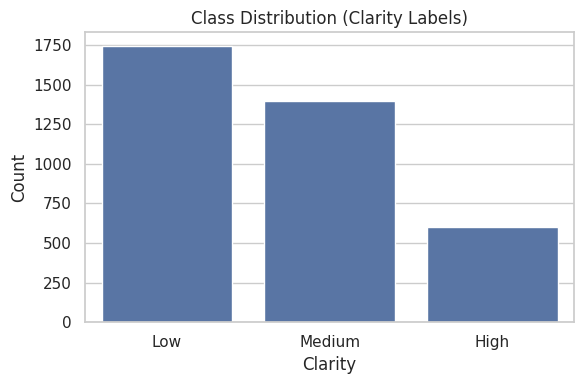

Applying SMOTE to balance training data...
Original class distribution: [ 416 1231  968]
Balanced class distribution: [1231 1231 1231]

Training classifiers with hyperparameter tuning...

Training KNN...
Best Params: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Best Cross-Validation Score: 0.687817713089174
Test Accuracy: 0.4594112399643176


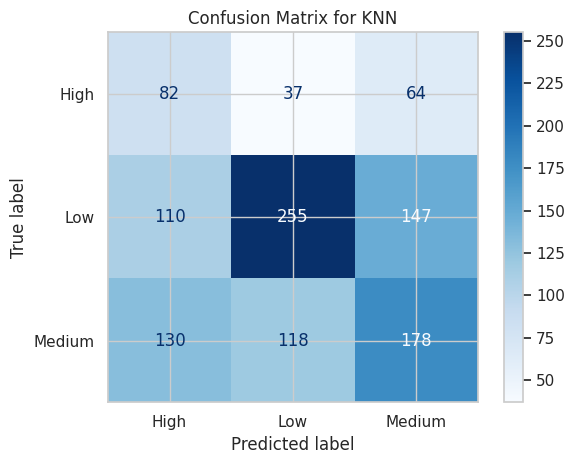

Calculating feature importance for KNN...


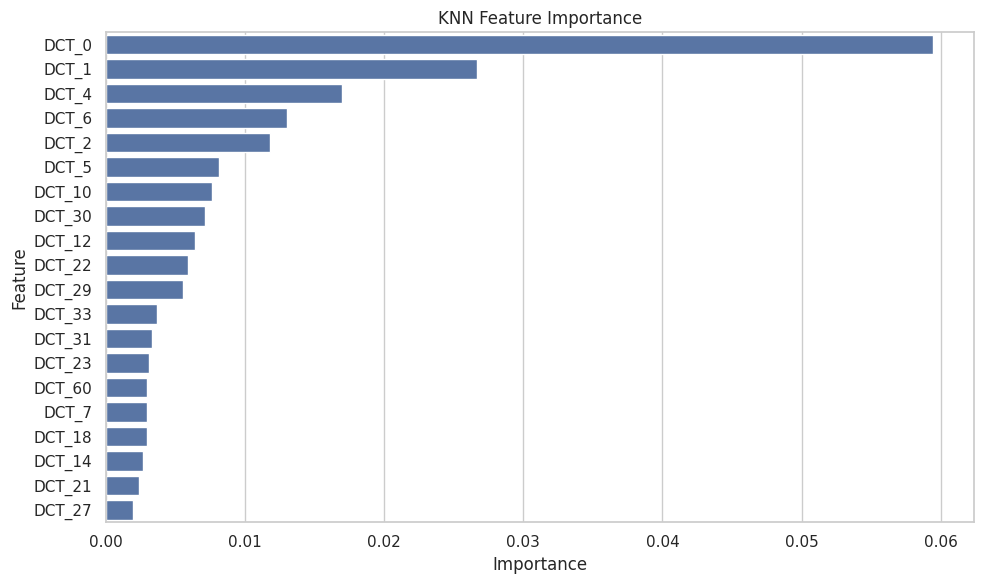

Top 20 features for KNN:
   Feature  Importance
0    DCT_0    0.059411
1    DCT_1    0.026673
4    DCT_4    0.016949
6    DCT_6    0.013024
2    DCT_2    0.011775
5    DCT_5    0.008118
10  DCT_10    0.007672
30  DCT_30    0.007136
12  DCT_12    0.006423
22  DCT_22    0.005888
29  DCT_29    0.005531
33  DCT_33    0.003657
31  DCT_31    0.003301
23  DCT_23    0.003122
60  DCT_60    0.002944
7    DCT_7    0.002944
18  DCT_18    0.002944
14  DCT_14    0.002676
21  DCT_21    0.002409
27  DCT_27    0.001963

Training Logistic Regression...
Best Params: {'C': 10, 'solver': 'liblinear'}
Best Cross-Validation Score: 0.5369718839272289
Test Accuracy: 0.487957181088314


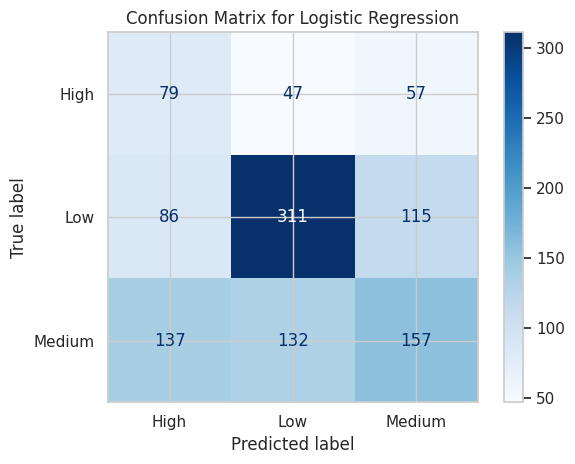

Calculating feature importance for Logistic Regression...


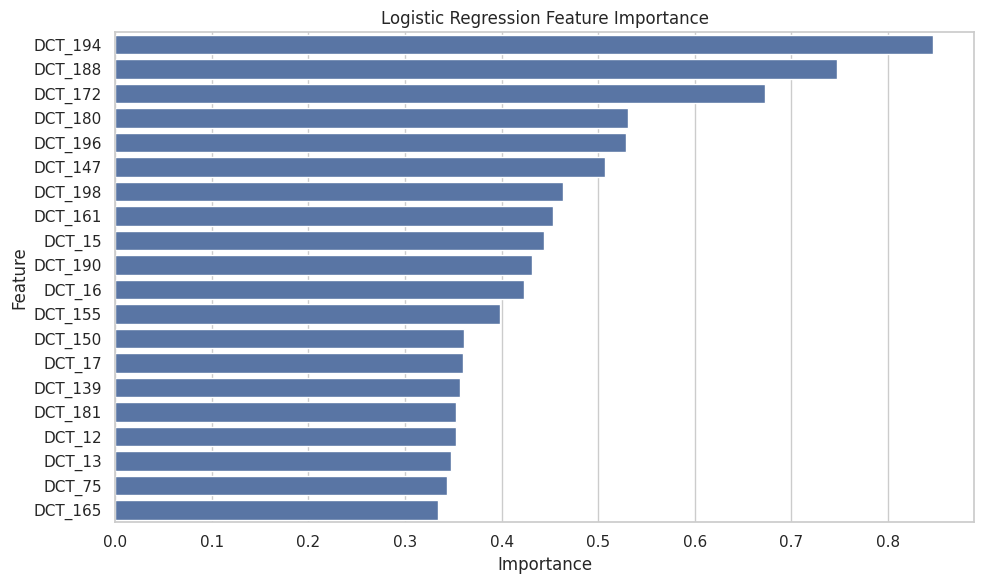

Top 20 features for Logistic Regression:
     Feature  Importance
194  DCT_194    0.846588
188  DCT_188    0.747290
172  DCT_172    0.672756
180  DCT_180    0.530493
196  DCT_196    0.528392
147  DCT_147    0.506755
198  DCT_198    0.463879
161  DCT_161    0.452928
15    DCT_15    0.443438
190  DCT_190    0.431187
16    DCT_16    0.422797
155  DCT_155    0.398420
150  DCT_150    0.360581
17    DCT_17    0.359992
139  DCT_139    0.357142
181  DCT_181    0.352845
12    DCT_12    0.352718
13    DCT_13    0.347752
75    DCT_75    0.343155
165  DCT_165    0.334085

Training AdaBoost...
Best Params: {'learning_rate': 1.0, 'n_estimators': 200}
Best Cross-Validation Score: 0.4998723830269426
Test Accuracy: 0.46743978590544155


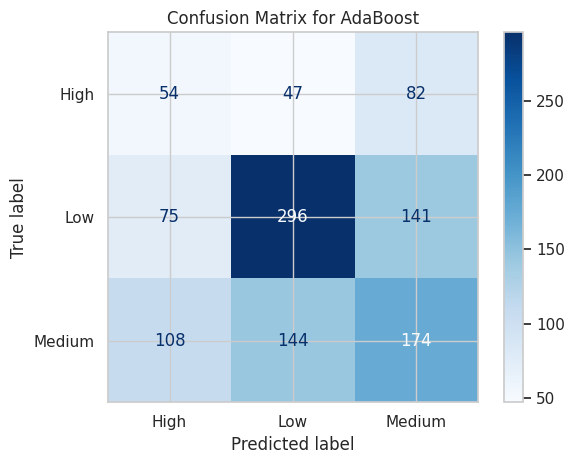

Calculating feature importance for AdaBoost...


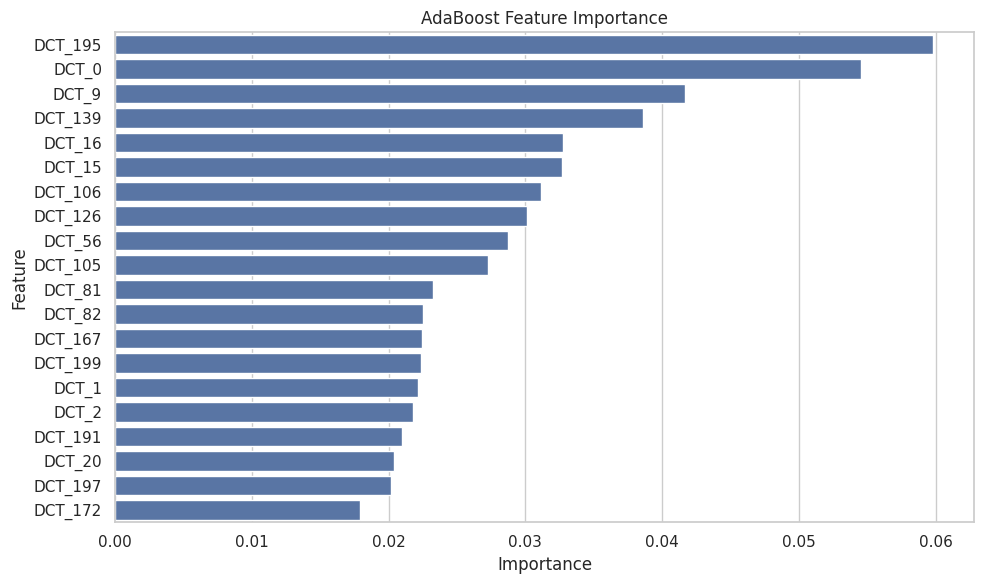

Top 20 features for AdaBoost:
     Feature  Importance
195  DCT_195    0.059822
0      DCT_0    0.054572
9      DCT_9    0.041708
139  DCT_139    0.038604
16    DCT_16    0.032725
15    DCT_15    0.032659
106  DCT_106    0.031130
126  DCT_126    0.030121
56    DCT_56    0.028727
105  DCT_105    0.027229
81    DCT_81    0.023229
82    DCT_82    0.022482
167  DCT_167    0.022467
199  DCT_199    0.022397
1      DCT_1    0.022130
2      DCT_2    0.021775
191  DCT_191    0.020940
20    DCT_20    0.020410
197  DCT_197    0.020174
172  DCT_172    0.017869

Training CatBoost...
Best Params: {'depth': 8, 'iterations': 200, 'learning_rate': 0.1}
Best Cross-Validation Score: 0.7184109486561713
Test Accuracy: 0.5557537912578056


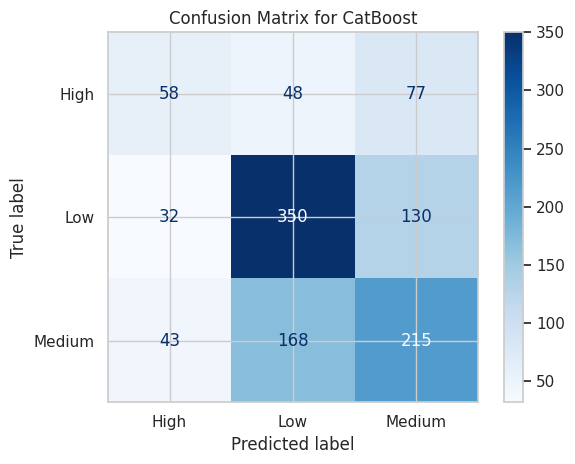

Calculating feature importance for CatBoost...


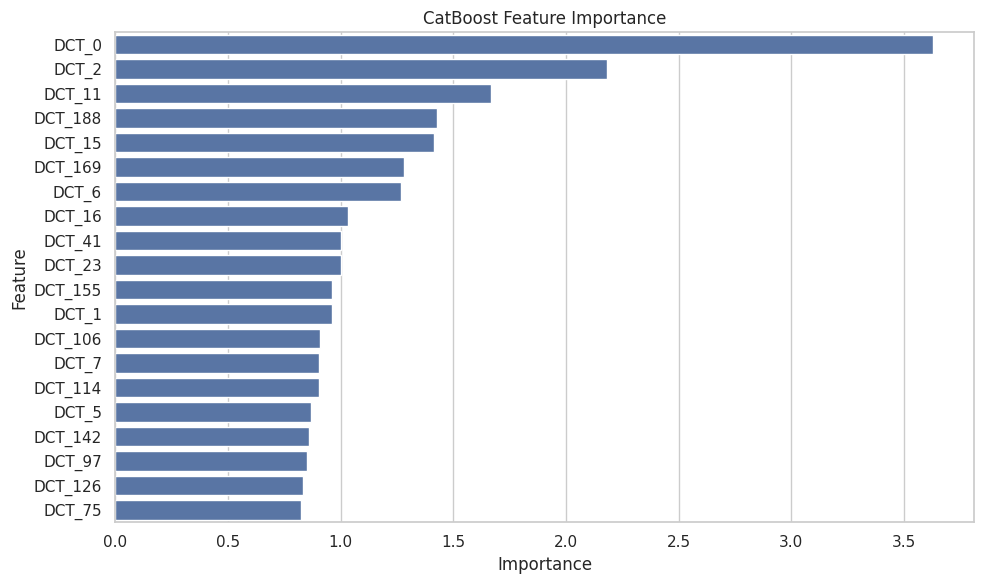

Top 20 features for CatBoost:
     Feature  Importance
0      DCT_0    3.629952
2      DCT_2    2.180411
11    DCT_11    1.666892
188  DCT_188    1.427311
15    DCT_15    1.413627
169  DCT_169    1.281812
6      DCT_6    1.267858
16    DCT_16    1.033807
41    DCT_41    1.003783
23    DCT_23    1.001457
155  DCT_155    0.963355
1      DCT_1    0.962006
106  DCT_106    0.910183
7      DCT_7    0.903939
114  DCT_114    0.903363
5      DCT_5    0.867910
142  DCT_142    0.859767
97    DCT_97    0.850625
126  DCT_126    0.831089
75    DCT_75    0.824789

Training Decision Tree...
Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-Validation Score: 0.5862668734941747
Test Accuracy: 0.4469223907225691


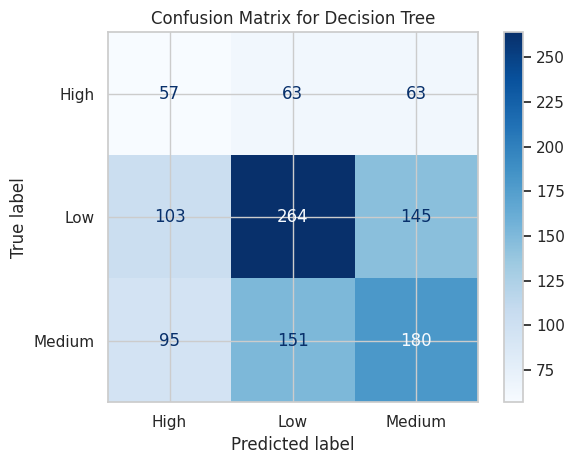

Calculating feature importance for Decision Tree...


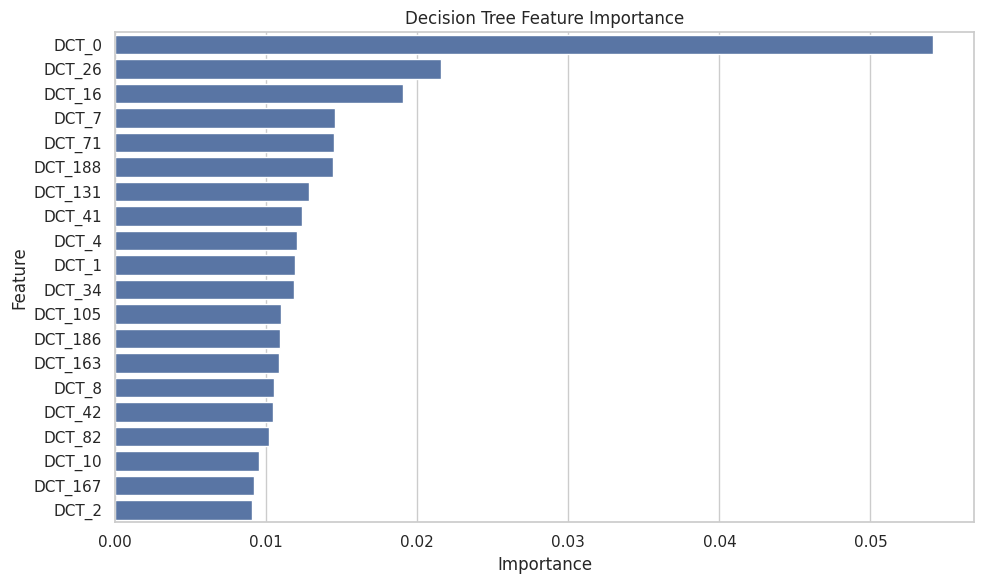

Top 20 features for Decision Tree:
     Feature  Importance
0      DCT_0    0.054148
26    DCT_26    0.021545
16    DCT_16    0.019075
7      DCT_7    0.014579
71    DCT_71    0.014477
188  DCT_188    0.014440
131  DCT_131    0.012796
41    DCT_41    0.012373
4      DCT_4    0.012055
1      DCT_1    0.011923
34    DCT_34    0.011852
105  DCT_105    0.010943
186  DCT_186    0.010908
163  DCT_163    0.010855
8      DCT_8    0.010540
42    DCT_42    0.010414
82    DCT_82    0.010168
10    DCT_10    0.009547
167  DCT_167    0.009196
2      DCT_2    0.009070

Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:19:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best Cross-Validation Score: 0.7495582912527367
Test Accuracy: 0.5575379125780553


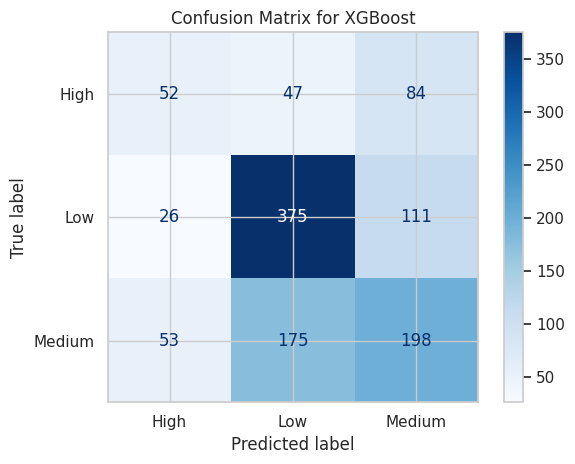

Calculating feature importance for XGBoost...


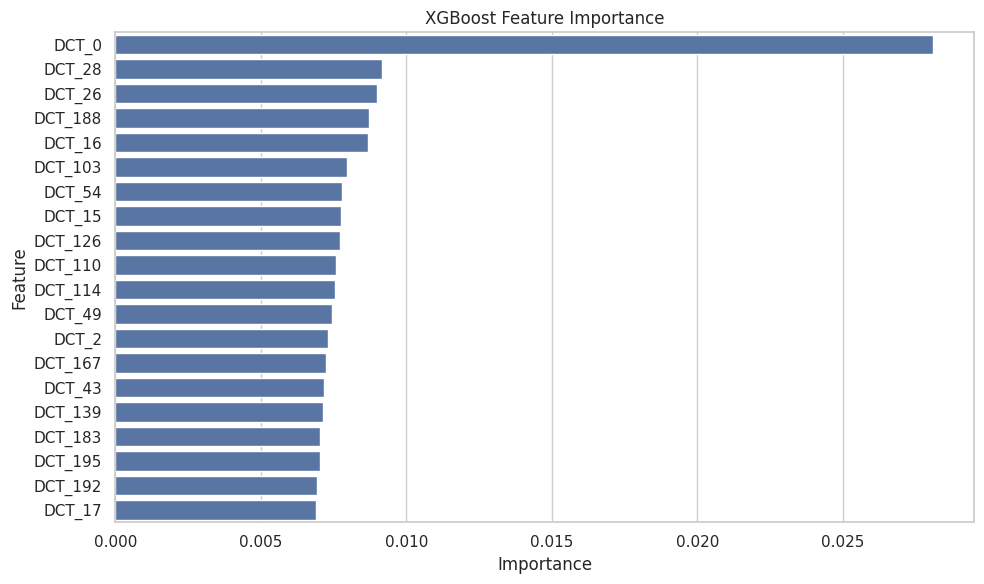

Top 20 features for XGBoost:
     Feature  Importance
0      DCT_0    0.028094
28    DCT_28    0.009157
26    DCT_26    0.008989
188  DCT_188    0.008700
16    DCT_16    0.008670
103  DCT_103    0.007974
54    DCT_54    0.007797
15    DCT_15    0.007758
126  DCT_126    0.007736
110  DCT_110    0.007579
114  DCT_114    0.007552
49    DCT_49    0.007441
2      DCT_2    0.007316
167  DCT_167    0.007246
43    DCT_43    0.007158
139  DCT_139    0.007144
183  DCT_183    0.007041
195  DCT_195    0.007041
192  DCT_192    0.006929
17    DCT_17    0.006888

Training MLP...
Best Params: {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}
Best Cross-Validation Score: 0.679687998503801
Test Accuracy: 0.5084745762711864


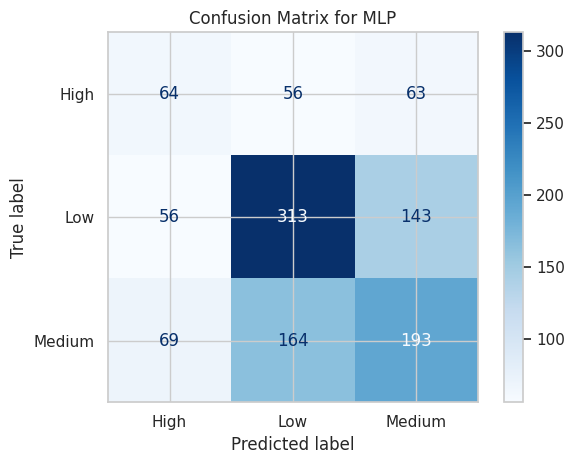

Calculating feature importance for MLP...


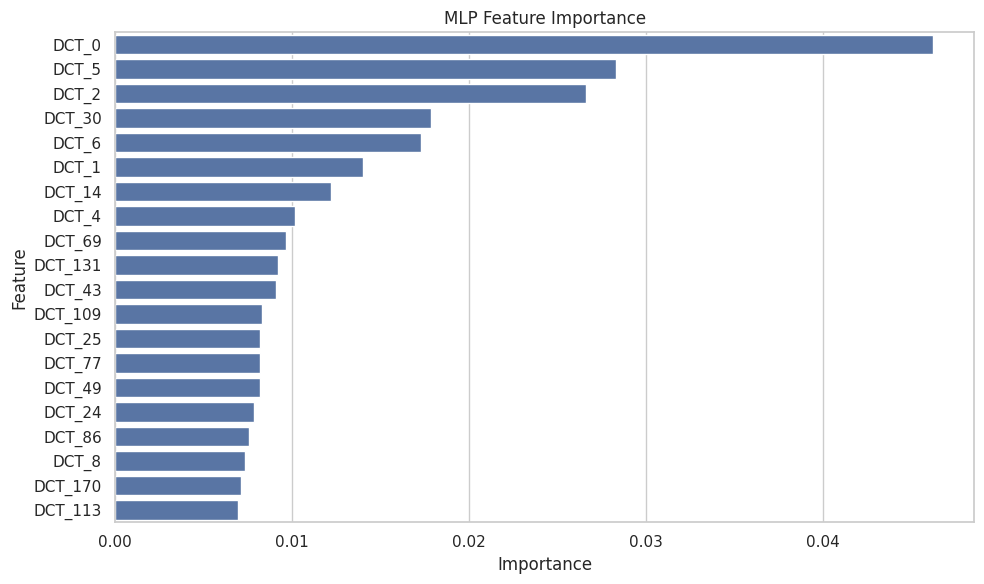

Top 20 features for MLP:
     Feature  Importance
0      DCT_0    0.046209
5      DCT_5    0.028278
2      DCT_2    0.026583
30    DCT_30    0.017841
6      DCT_6    0.017306
1      DCT_1    0.014005
14    DCT_14    0.012221
4      DCT_4    0.010169
69    DCT_69    0.009634
131  DCT_131    0.009188
43    DCT_43    0.009099
109  DCT_109    0.008296
25    DCT_25    0.008207
77    DCT_77    0.008207
49    DCT_49    0.008207
24    DCT_24    0.007850
86    DCT_86    0.007583
8      DCT_8    0.007315
170  DCT_170    0.007136
113  DCT_113    0.006958

Training Random Forest...
Best Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Best Cross-Validation Score: 0.7441349366132363
Test Accuracy: 0.5727029438001784


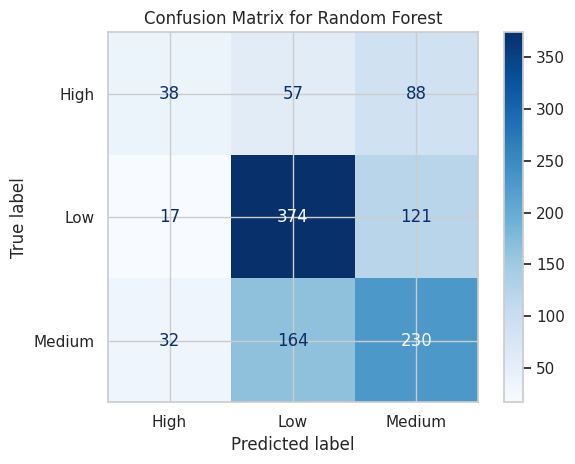

Calculating feature importance for Random Forest...


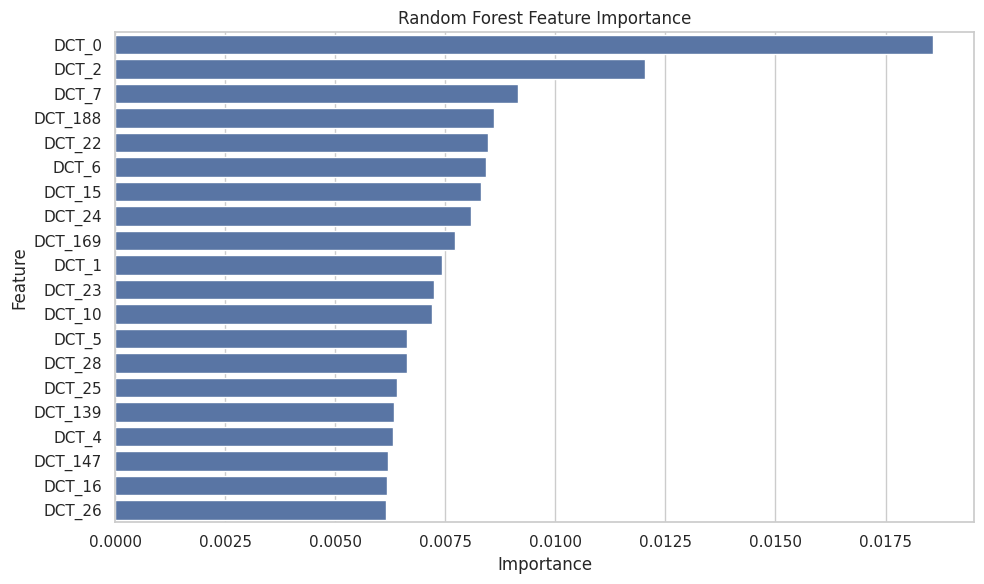

Top 20 features for Random Forest:
     Feature  Importance
0      DCT_0    0.018581
2      DCT_2    0.012042
7      DCT_7    0.009158
188  DCT_188    0.008596
22    DCT_22    0.008469
6      DCT_6    0.008434
15    DCT_15    0.008307
24    DCT_24    0.008079
169  DCT_169    0.007710
1      DCT_1    0.007424
23    DCT_23    0.007245
10    DCT_10    0.007200
5      DCT_5    0.006633
28    DCT_28    0.006633
25    DCT_25    0.006401
139  DCT_139    0.006327
4      DCT_4    0.006301
147  DCT_147    0.006199
16    DCT_16    0.006174
26    DCT_26    0.006145

Training Naïve Bayes...
Best Params: {'var_smoothing': 1e-08}
Best Cross-Validation Score: 0.43976515543233924
Test Accuracy: 0.3514719000892061


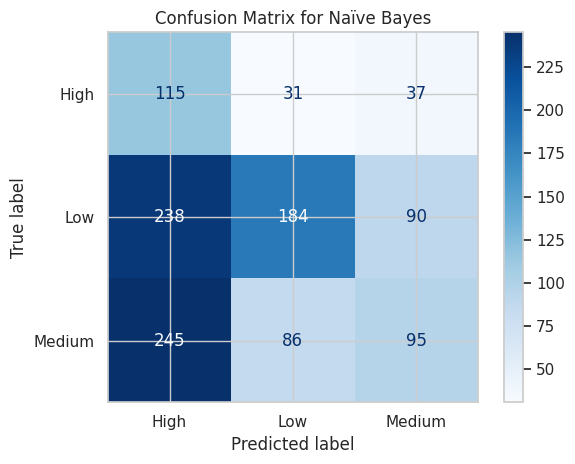

Calculating feature importance for Naïve Bayes...


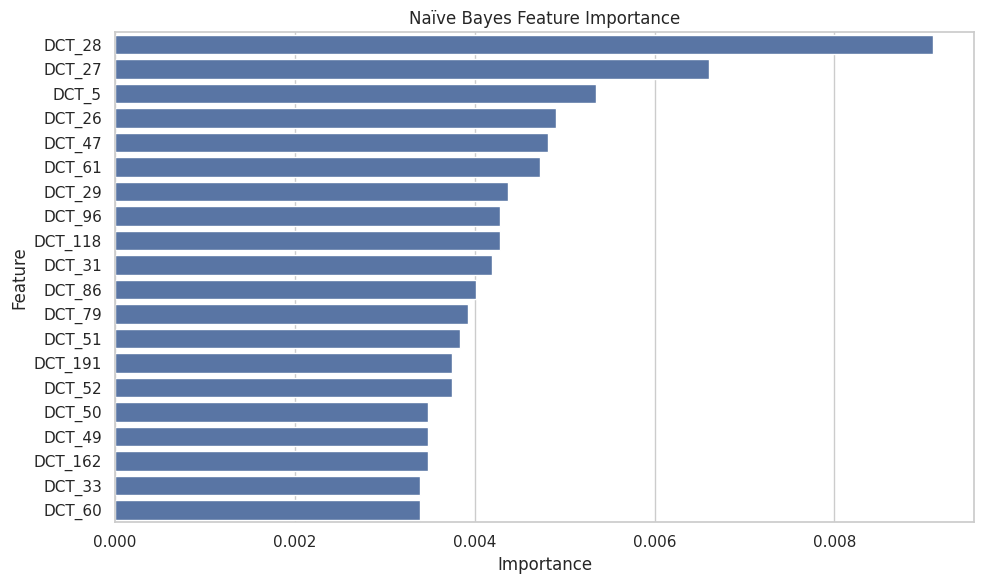

Top 20 features for Naïve Bayes:
     Feature  Importance
28    DCT_28    0.009099
27    DCT_27    0.006601
5      DCT_5    0.005352
26    DCT_26    0.004906
47    DCT_47    0.004817
61    DCT_61    0.004728
29    DCT_29    0.004371
96    DCT_96    0.004282
118  DCT_118    0.004282
31    DCT_31    0.004193
86    DCT_86    0.004014
79    DCT_79    0.003925
51    DCT_51    0.003836
191  DCT_191    0.003747
52    DCT_52    0.003747
50    DCT_50    0.003479
49    DCT_49    0.003479
162  DCT_162    0.003479
33    DCT_33    0.003390
60    DCT_60    0.003390

Model Performance Comparison:
                 Model                                        Best Params  \
0                  KNN  {'metric': 'euclidean', 'n_neighbors': 3, 'wei...   
1  Logistic Regression                   {'C': 10, 'solver': 'liblinear'}   
2             AdaBoost        {'learning_rate': 1.0, 'n_estimators': 200}   
3             CatBoost  {'depth': 8, 'iterations': 200, 'learning_rate...   
4        Decision Tree  {'

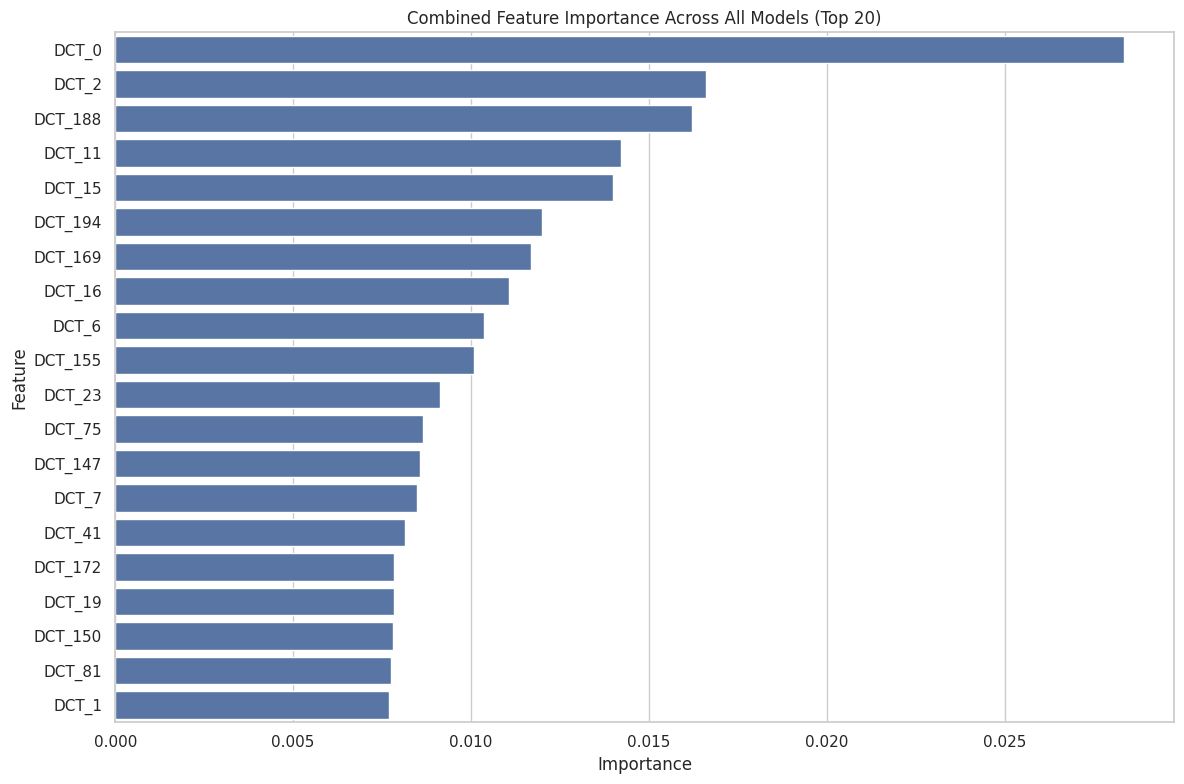

Top 20 features from combined analysis:
     Feature  Importance
0      DCT_0    0.028334
2      DCT_2    0.016600
188  DCT_188    0.016215
11    DCT_11    0.014212
15    DCT_15    0.013987
194  DCT_194    0.011984
169  DCT_169    0.011684
16    DCT_16    0.011072
6      DCT_6    0.010376
155  DCT_155    0.010073
23    DCT_23    0.009127
75    DCT_75    0.008641
147  DCT_147    0.008552
7      DCT_7    0.008479
41    DCT_41    0.008132
172  DCT_172    0.007829
19    DCT_19    0.007820
150  DCT_150    0.007800
81    DCT_81    0.007755
1      DCT_1    0.007687


In [20]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import shap

sns.set(style="whitegrid")

# ✅ Normalize filename function
def normalize_filename(name):
    name = name.strip().lower()
    name = os.path.splitext(name)[0]
    return re.sub(r"(\d+)s(\d+)", r"\1_s\2", name)

# Load pre-calculated DCT features from CSV file
dct_file = "/content/dct_mean_features (2).csv"
if not os.path.exists(dct_file):
    raise FileNotFoundError(f"DCT features file not found: {dct_file}")

dct_df = pd.read_csv(dct_file)

# Normalize filenames in the DCT features dataframe
dct_df["File Name"] = dct_df["File Name"].apply(normalize_filename)

#  Read and normalize label files
print("Reading label files...")
excel_files = glob.glob("output_*_s.xlsx")
if not excel_files:
    raise FileNotFoundError("No Excel files found.")

labels_list = []
for excel_file in excel_files:
    try:
        df = pd.read_excel(excel_file)[["File Name", "Clarity"]]
        df["File Name"] = df["File Name"].astype(str).apply(normalize_filename)
        df["Clarity"] = df["Clarity"].astype(str).str.strip().str.title()
        df["Clarity"] = df["Clarity"].replace({
            "Medium Low": "Low",
            "Low Medium": "Medium",
            "High Medium": "High",
            "Lowhigh": "High",
            "Med": "Medium",
            "Mid": "Medium"
        })
        labels_list.append(df)
    except Exception as e:
        print(f"Error reading {excel_file}: {e}")

labels_df = pd.concat(labels_list, ignore_index=True)

#  Merge features and labels
merged_data = dct_df.merge(labels_df, on="File Name", how="inner")

if merged_data.empty:
    unmatched = set(dct_df["File Name"]) - set(labels_df["File Name"])
    print("\nSample from DCT feature file names:", dct_df["File Name"].head())
    print("Sample from Label file names:", labels_df["File Name"].head())
    print(f"\nUnmatched file names: {list(unmatched)[:5]}")
    raise ValueError("No matching data found after merging features with labels.")

data = merged_data

# Prepare data
X = data.drop(columns=["File Name", "Clarity"])
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
X = X.select_dtypes(include=[np.number])

# Store feature names for importance plots
feature_names = X.columns.tolist()

le = LabelEncoder()
y = le.fit_transform(data["Clarity"])

#  Class distribution plot
print("Visualizing class distribution...")
plt.figure(figsize=(6, 4))
sns.countplot(x=data["Clarity"])
plt.title("Class Distribution (Clarity Labels)")
plt.xlabel("Clarity")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Enhanced function to plot feature importance
def plot_feature_importance(importances, feature_names, title, top_n=20):
    # Create DataFrame for plotting
    feature_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Select top N features
    if len(feature_imp) > top_n:
        feature_imp = feature_imp.head(top_n)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_imp)
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return feature_imp

# Function to calculate permutation importance for models without built-in feature importance
def calculate_permutation_importance(model, X, y):
    perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42)
    return perm_importance.importances_mean

#  Classifier config with feature importance support flag
classifiers = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7],
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan"]
        },
        "has_feature_importance": False  # Will use permutation importance
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "solver": ["lbfgs", "liblinear"]
        },
        "has_feature_importance": True  # Will extract coef_
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0]
        },
        "has_feature_importance": True  # Has feature_importances_
    },
    "CatBoost": {
        "model": CatBoostClassifier(verbose=0, random_state=42),
        "params": {
            "iterations": [100, 200],
            "depth": [4, 6, 8],
            "learning_rate": [0.01, 0.1]
        },
        "has_feature_importance": True  # Has feature_importances_
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        },
        "has_feature_importance": True  # Has feature_importances_
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1]
        },
        "has_feature_importance": True  # Has feature_importances_
    },
    "MLP": {
        "model": MLPClassifier(max_iter=500, random_state=42),
        "params": {
            "hidden_layer_sizes": [(50,), (100,), (50, 50)],
            "activation": ["relu", "tanh"],
            "learning_rate_init": [0.001, 0.01]
        },
        "has_feature_importance": False  # Will use permutation importance
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5]
        },
        "has_feature_importance": True  # Has feature_importances_
    },
    "Naïve Bayes": {
        "model": GaussianNB(),
        "params": {
            "var_smoothing": [1e-9, 1e-8, 1e-7]
        },
        "has_feature_importance": False  # Will use permutation importance
    }
}

#  Split and SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Applying SMOTE to balance training data...")
print("Original class distribution:", np.bincount(y_train))
smote = SMOTE(random_state=42, k_neighbors=2)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print("Balanced class distribution:", np.bincount(y_train_balanced))

#  Training & evaluation
print("\nTraining classifiers with hyperparameter tuning...")
results = []
best_model = None
best_accuracy = 0
best_model_name = ""
trained_models = {}

# Dictionary to store feature importance for all models
all_feature_importances = {}

for name, clf_info in classifiers.items():
    print(f"\nTraining {name}...")
    clf = clf_info["model"]
    param_grid = clf_info["params"]

    # Hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train_balanced, y_train_balanced)

    best_params = grid_search.best_params_
    best_clf = grid_search.best_estimator_
    best_score = grid_search.best_score_

    print(f"Best Params: {best_params}")
    print(f"Best Cross-Validation Score: {best_score}")

    # Evaluate on the test set
    y_pred = best_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Test Accuracy: {accuracy}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=le.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {name}")
    plt.tight_layout()
    plt.show()

    # Calculate and store feature importance for all models
    print(f"Calculating feature importance for {name}...")
    if clf_info["has_feature_importance"]:
        if hasattr(best_clf, "feature_importances_"):
            # For tree-based models and ensemble methods
            importances = best_clf.feature_importances_
        elif hasattr(best_clf, "coef_"):
            # For linear models like Logistic Regression
            importances = np.abs(best_clf.coef_[0]) if len(best_clf.coef_.shape) > 1 else np.abs(best_clf.coef_)
        else:
            # Fallback to permutation importance
            importances = calculate_permutation_importance(best_clf, X_test, y_test)
    else:
        # Use permutation importance for models that don't have built-in feature importance
        importances = calculate_permutation_importance(best_clf, X_test, y_test)

    # Store the feature importance
    all_feature_importances[name] = importances

    # Plot feature importance for each model
    importance_df = plot_feature_importance(importances, feature_names, f"{name} Feature Importance", top_n=20)
    print(f"Top 20 features for {name}:")
    print(importance_df)

    # Track the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = name
        best_model = best_clf

    results.append({
        'Model': name,
        'Best Params': best_params,
        'Best Cross-Validation Score': best_score,
        'Test Accuracy': accuracy
    })

# Displaying Results
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df)

print(f"\nBest model: {best_model_name} with accuracy: {best_accuracy:.4f}")

# Optionally: Create a combined plot of top features across all models
print("\nCreating combined feature importance analysis...")

# Aggregate feature importances across all models
combined_importances = {}
for feature in feature_names:
    combined_importances[feature] = 0

for model_name, importances in all_feature_importances.items():
    for feature, importance in zip(feature_names, importances):
        combined_importances[feature] += importance

# Normalize the combined importance
total_importance = sum(combined_importances.values())
if total_importance > 0:  # Avoid division by zero
    for feature in combined_importances:
        combined_importances[feature] /= total_importance

# Create a DataFrame for the combined importance
combined_imp_df = pd.DataFrame({
    'Feature': list(combined_importances.keys()),
    'Importance': list(combined_importances.values())
}).sort_values(by='Importance', ascending=False)

# Plot the top 20 features from the combined analysis
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=combined_imp_df.head(20))
plt.title("Combined Feature Importance Across All Models (Top 20)")
plt.tight_layout()
plt.show()

print("Top 20 features from combined analysis:")
print(combined_imp_df.head(20))

Reading label files...
Visualizing class distribution...


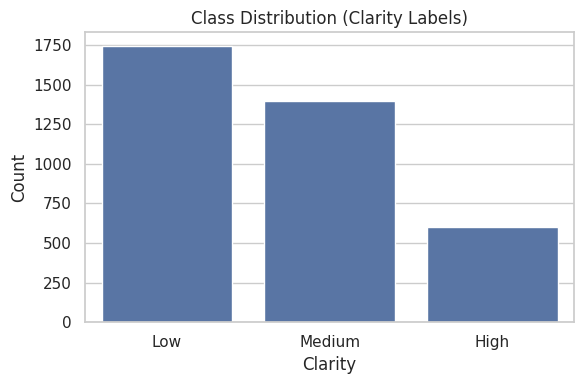

Applying SMOTE to balance training data...
Original class distribution: [ 416 1231  968]
Balanced class distribution: [1231 1231 1231]

Training classifiers with hyperparameter tuning...

Training KNN...
Best Params: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Best Cross-Validation Score: 0.687817713089174
Test Accuracy: 0.4594
Precision: 0.4995
Recall: 0.4594
F1 Score: 0.4717


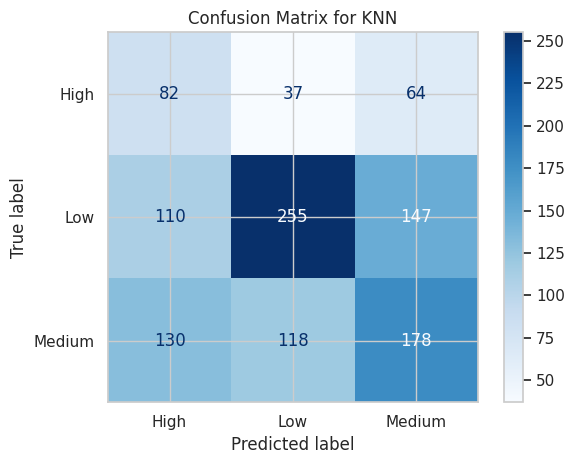

Calculating feature importance for KNN...


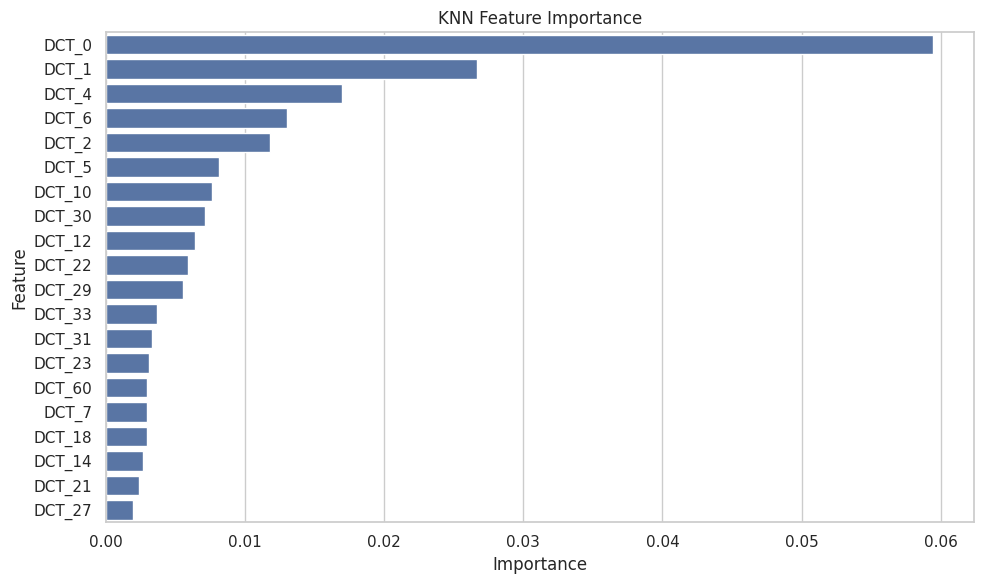

Top 20 features for KNN:
   Feature  Importance
0    DCT_0    0.059411
1    DCT_1    0.026673
4    DCT_4    0.016949
6    DCT_6    0.013024
2    DCT_2    0.011775
5    DCT_5    0.008118
10  DCT_10    0.007672
30  DCT_30    0.007136
12  DCT_12    0.006423
22  DCT_22    0.005888
29  DCT_29    0.005531
33  DCT_33    0.003657
31  DCT_31    0.003301
23  DCT_23    0.003122
60  DCT_60    0.002944
7    DCT_7    0.002944
18  DCT_18    0.002944
14  DCT_14    0.002676
21  DCT_21    0.002409
27  DCT_27    0.001963

Training Logistic Regression...
Best Params: {'C': 10, 'solver': 'liblinear'}
Best Cross-Validation Score: 0.5369718839272289
Test Accuracy: 0.4880
Precision: 0.5139
Recall: 0.4880
F1 Score: 0.4948


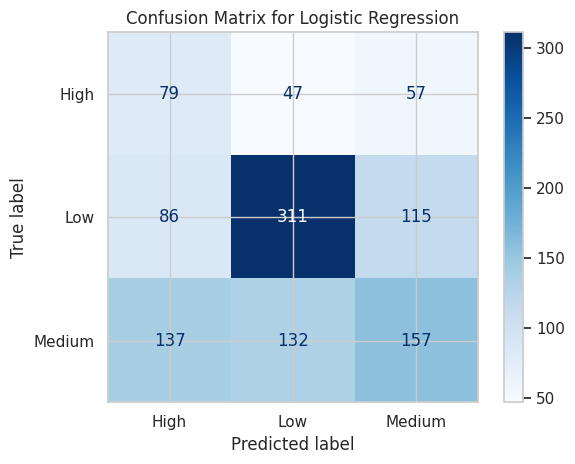

Calculating feature importance for Logistic Regression...


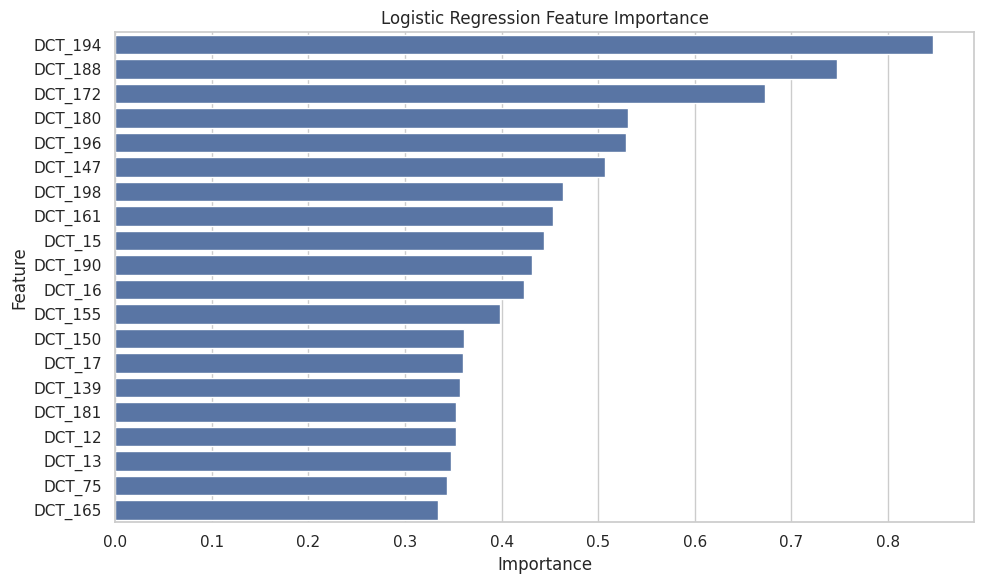

Top 20 features for Logistic Regression:
     Feature  Importance
194  DCT_194    0.846588
188  DCT_188    0.747290
172  DCT_172    0.672756
180  DCT_180    0.530493
196  DCT_196    0.528392
147  DCT_147    0.506755
198  DCT_198    0.463879
161  DCT_161    0.452928
15    DCT_15    0.443438
190  DCT_190    0.431187
16    DCT_16    0.422797
155  DCT_155    0.398420
150  DCT_150    0.360581
17    DCT_17    0.359992
139  DCT_139    0.357142
181  DCT_181    0.352845
12    DCT_12    0.352718
13    DCT_13    0.347752
75    DCT_75    0.343155
165  DCT_165    0.334085

Training AdaBoost...
Best Params: {'learning_rate': 1.0, 'n_estimators': 200}
Best Cross-Validation Score: 0.4998723830269426
Test Accuracy: 0.4674
Precision: 0.4814
Recall: 0.4674
F1 Score: 0.4733


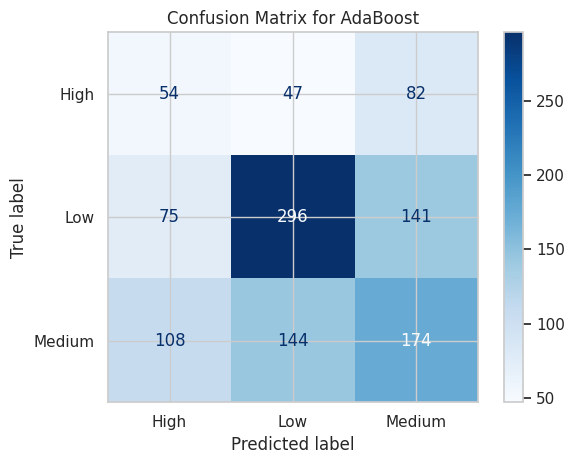

Calculating feature importance for AdaBoost...


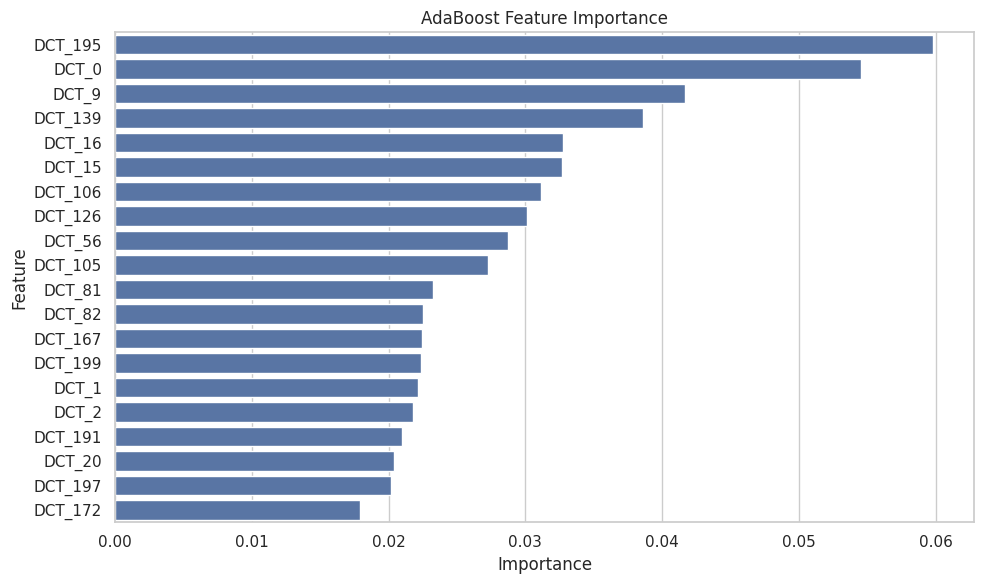

Top 20 features for AdaBoost:
     Feature  Importance
195  DCT_195    0.059822
0      DCT_0    0.054572
9      DCT_9    0.041708
139  DCT_139    0.038604
16    DCT_16    0.032725
15    DCT_15    0.032659
106  DCT_106    0.031130
126  DCT_126    0.030121
56    DCT_56    0.028727
105  DCT_105    0.027229
81    DCT_81    0.023229
82    DCT_82    0.022482
167  DCT_167    0.022467
199  DCT_199    0.022397
1      DCT_1    0.022130
2      DCT_2    0.021775
191  DCT_191    0.020940
20    DCT_20    0.020410
197  DCT_197    0.020174
172  DCT_172    0.017869

Training CatBoost...
Best Params: {'depth': 8, 'iterations': 200, 'learning_rate': 0.1}
Best Cross-Validation Score: 0.7184109486561713
Test Accuracy: 0.5558
Precision: 0.5472
Recall: 0.5558
F1 Score: 0.5492


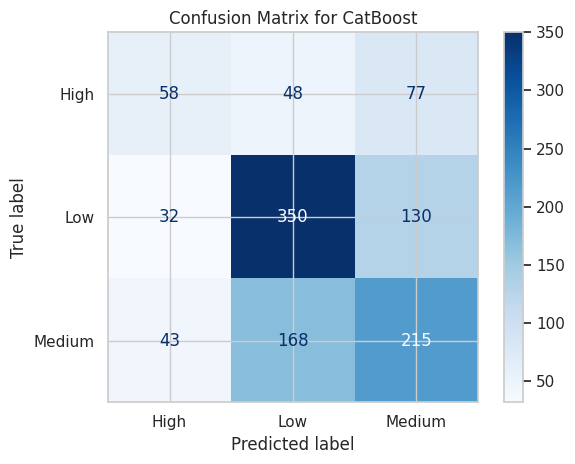

Calculating feature importance for CatBoost...


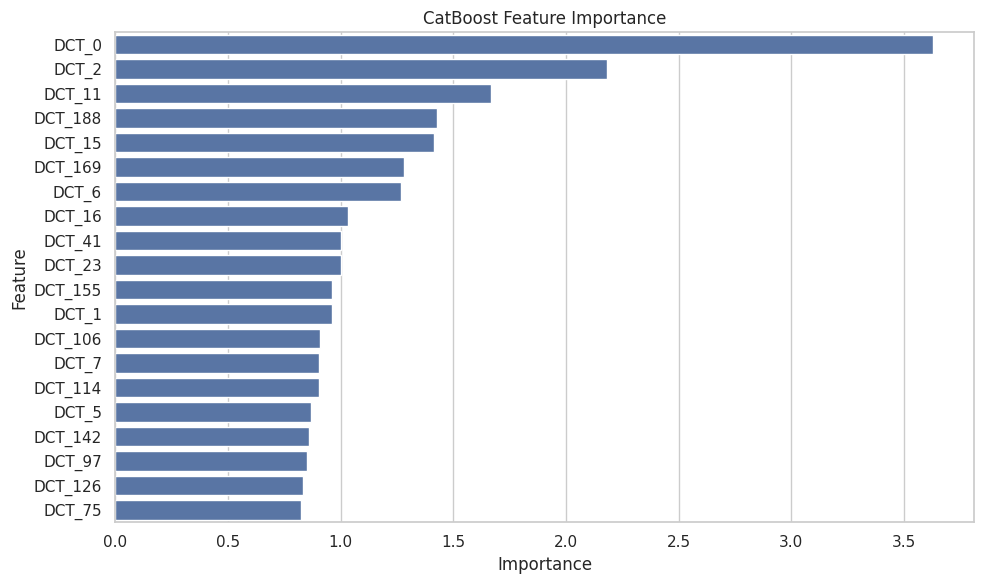

Top 20 features for CatBoost:
     Feature  Importance
0      DCT_0    3.629952
2      DCT_2    2.180411
11    DCT_11    1.666892
188  DCT_188    1.427311
15    DCT_15    1.413627
169  DCT_169    1.281812
6      DCT_6    1.267858
16    DCT_16    1.033807
41    DCT_41    1.003783
23    DCT_23    1.001457
155  DCT_155    0.963355
1      DCT_1    0.962006
106  DCT_106    0.910183
7      DCT_7    0.903939
114  DCT_114    0.903363
5      DCT_5    0.867910
142  DCT_142    0.859767
97    DCT_97    0.850625
126  DCT_126    0.831089
75    DCT_75    0.824789

Training Decision Tree...
Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-Validation Score: 0.5862668734941747
Test Accuracy: 0.4469
Precision: 0.4650
Recall: 0.4469
F1 Score: 0.4541


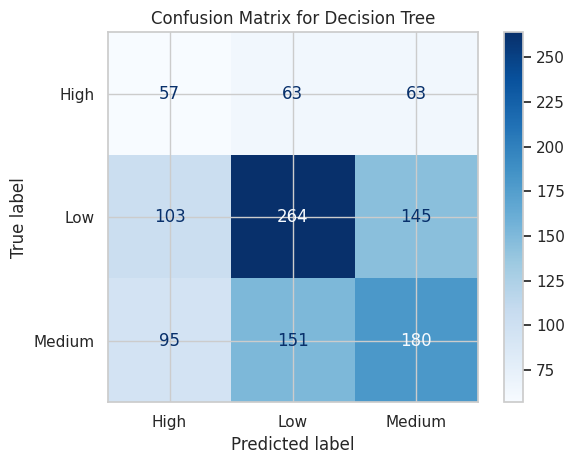

Calculating feature importance for Decision Tree...


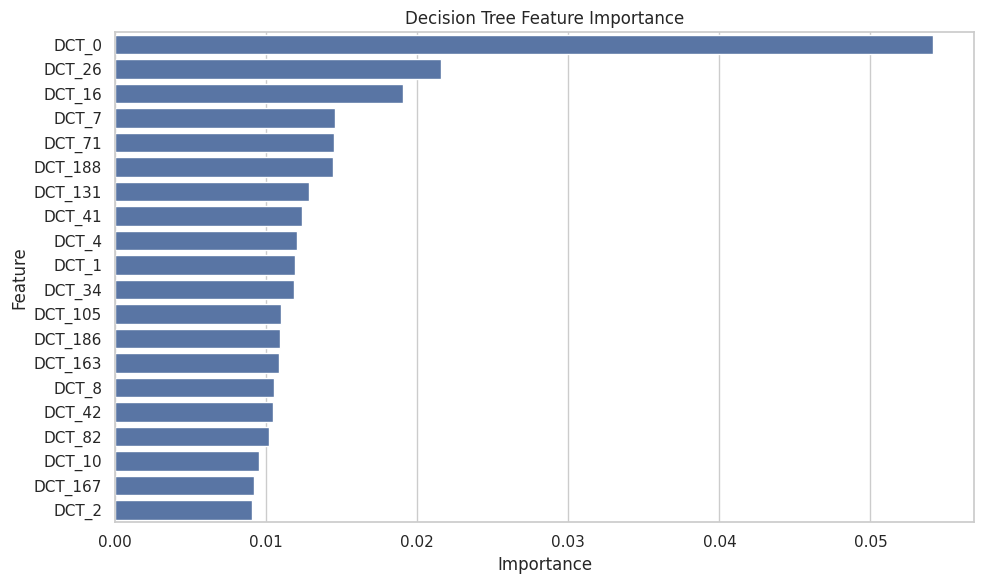

Top 20 features for Decision Tree:
     Feature  Importance
0      DCT_0    0.054148
26    DCT_26    0.021545
16    DCT_16    0.019075
7      DCT_7    0.014579
71    DCT_71    0.014477
188  DCT_188    0.014440
131  DCT_131    0.012796
41    DCT_41    0.012373
4      DCT_4    0.012055
1      DCT_1    0.011923
34    DCT_34    0.011852
105  DCT_105    0.010943
186  DCT_186    0.010908
163  DCT_163    0.010855
8      DCT_8    0.010540
42    DCT_42    0.010414
82    DCT_82    0.010168
10    DCT_10    0.009547
167  DCT_167    0.009196
2      DCT_2    0.009070

Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:29:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best Cross-Validation Score: 0.7495582912527367
Test Accuracy: 0.5575
Precision: 0.5432
Recall: 0.5575
F1 Score: 0.5467


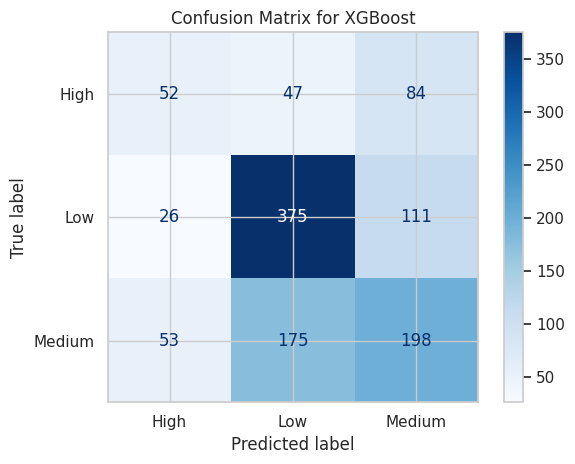

Calculating feature importance for XGBoost...


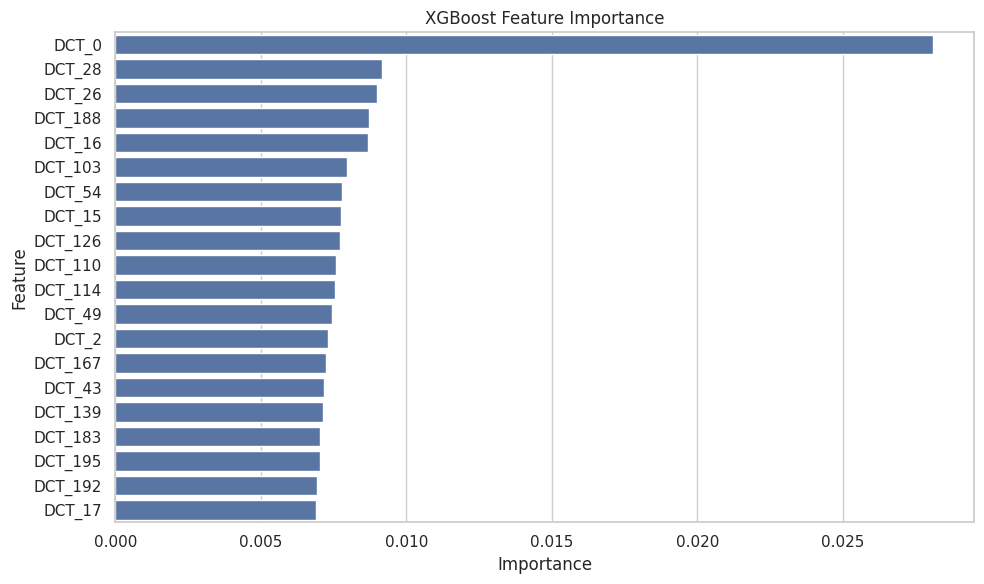

Top 20 features for XGBoost:
     Feature  Importance
0      DCT_0    0.028094
28    DCT_28    0.009157
26    DCT_26    0.008989
188  DCT_188    0.008700
16    DCT_16    0.008670
103  DCT_103    0.007974
54    DCT_54    0.007797
15    DCT_15    0.007758
126  DCT_126    0.007736
110  DCT_110    0.007579
114  DCT_114    0.007552
49    DCT_49    0.007441
2      DCT_2    0.007316
167  DCT_167    0.007246
43    DCT_43    0.007158
139  DCT_139    0.007144
183  DCT_183    0.007041
195  DCT_195    0.007041
192  DCT_192    0.006929
17    DCT_17    0.006888

Training MLP...
Best Params: {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}
Best Cross-Validation Score: 0.679687998503801
Test Accuracy: 0.5085
Precision: 0.5073
Recall: 0.5085
F1 Score: 0.5076


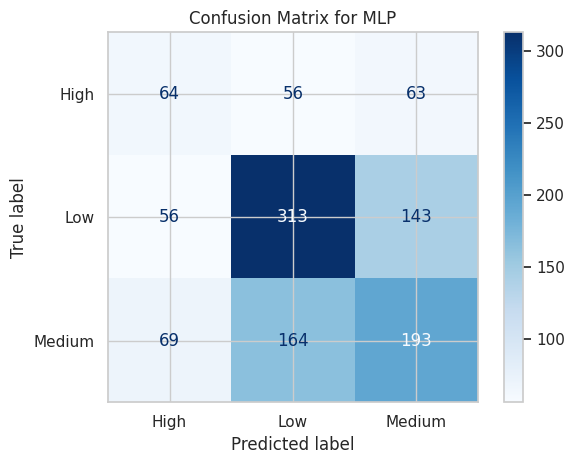

Calculating feature importance for MLP...


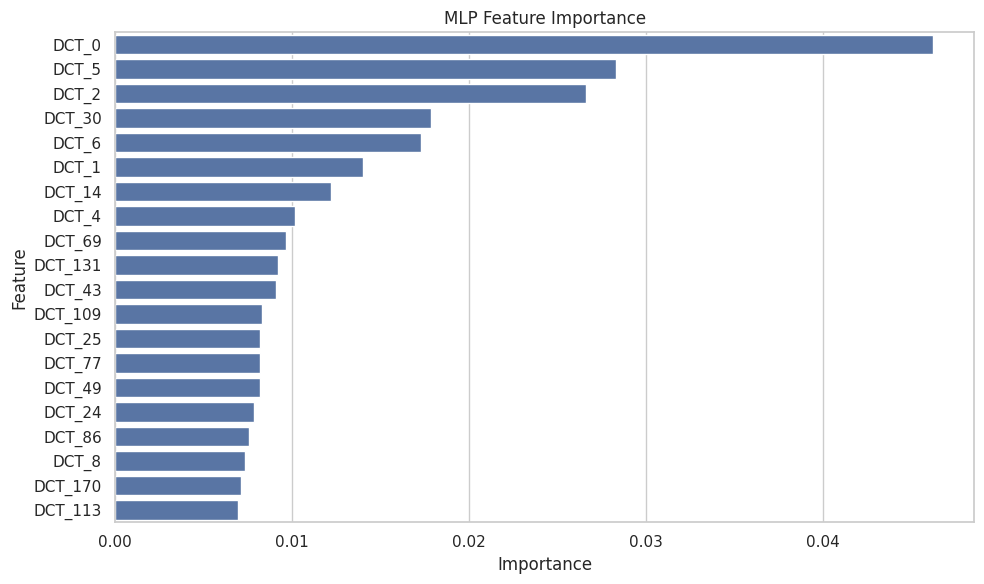

Top 20 features for MLP:
     Feature  Importance
0      DCT_0    0.046209
5      DCT_5    0.028278
2      DCT_2    0.026583
30    DCT_30    0.017841
6      DCT_6    0.017306
1      DCT_1    0.014005
14    DCT_14    0.012221
4      DCT_4    0.010169
69    DCT_69    0.009634
131  DCT_131    0.009188
43    DCT_43    0.009099
109  DCT_109    0.008296
25    DCT_25    0.008207
77    DCT_77    0.008207
49    DCT_49    0.008207
24    DCT_24    0.007850
86    DCT_86    0.007583
8      DCT_8    0.007315
170  DCT_170    0.007136
113  DCT_113    0.006958

Training Random Forest...
Best Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Best Cross-Validation Score: 0.7441349366132363
Test Accuracy: 0.5727
Precision: 0.5575
Recall: 0.5727
F1 Score: 0.5567


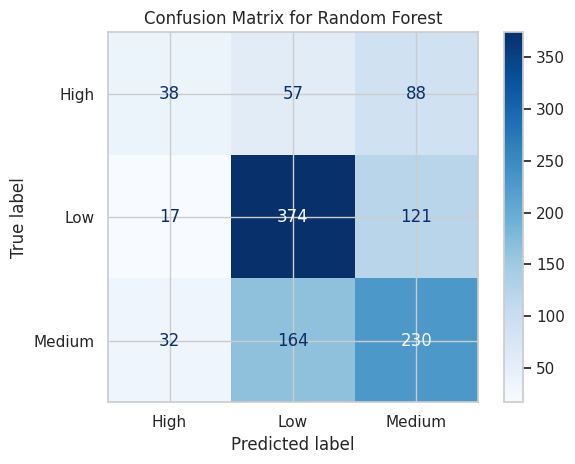

Calculating feature importance for Random Forest...


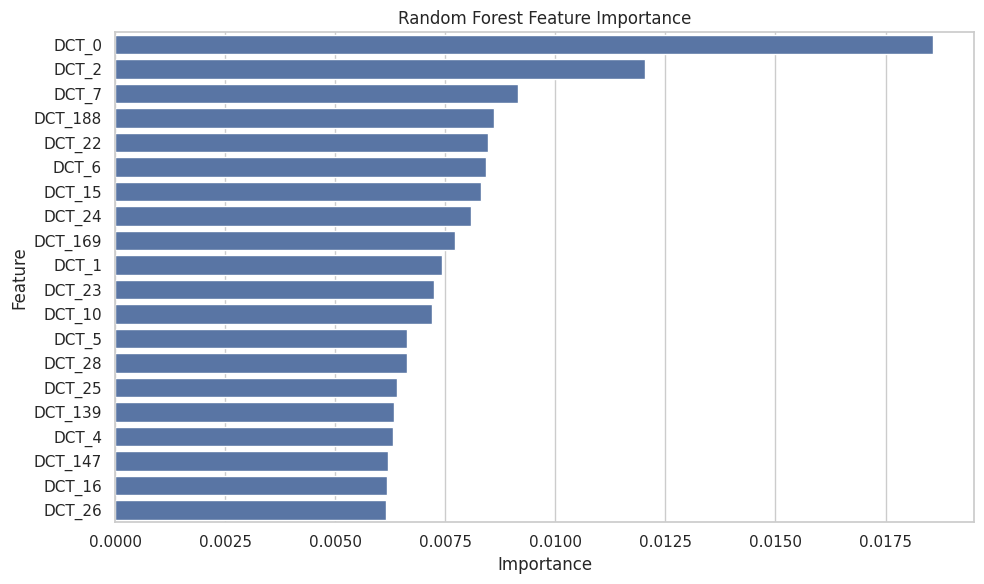

Top 20 features for Random Forest:
     Feature  Importance
0      DCT_0    0.018581
2      DCT_2    0.012042
7      DCT_7    0.009158
188  DCT_188    0.008596
22    DCT_22    0.008469
6      DCT_6    0.008434
15    DCT_15    0.008307
24    DCT_24    0.008079
169  DCT_169    0.007710
1      DCT_1    0.007424
23    DCT_23    0.007245
10    DCT_10    0.007200
5      DCT_5    0.006633
28    DCT_28    0.006633
25    DCT_25    0.006401
139  DCT_139    0.006327
4      DCT_4    0.006301
147  DCT_147    0.006199
16    DCT_16    0.006174
26    DCT_26    0.006145

Training Naïve Bayes...
Best Params: {'var_smoothing': 1e-08}
Best Cross-Validation Score: 0.43976515543233924
Test Accuracy: 0.3515
Precision: 0.4732
Recall: 0.3515
F1 Score: 0.3662


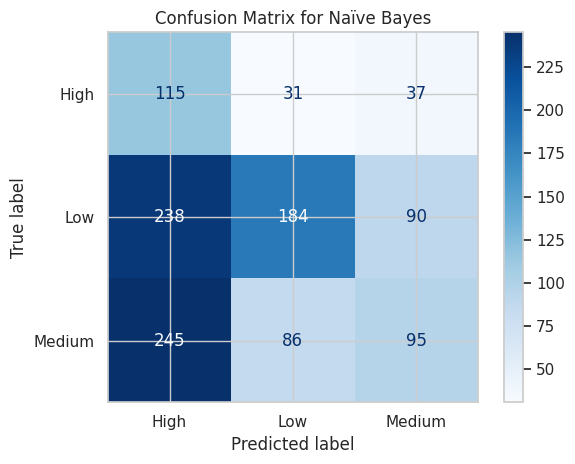

Calculating feature importance for Naïve Bayes...


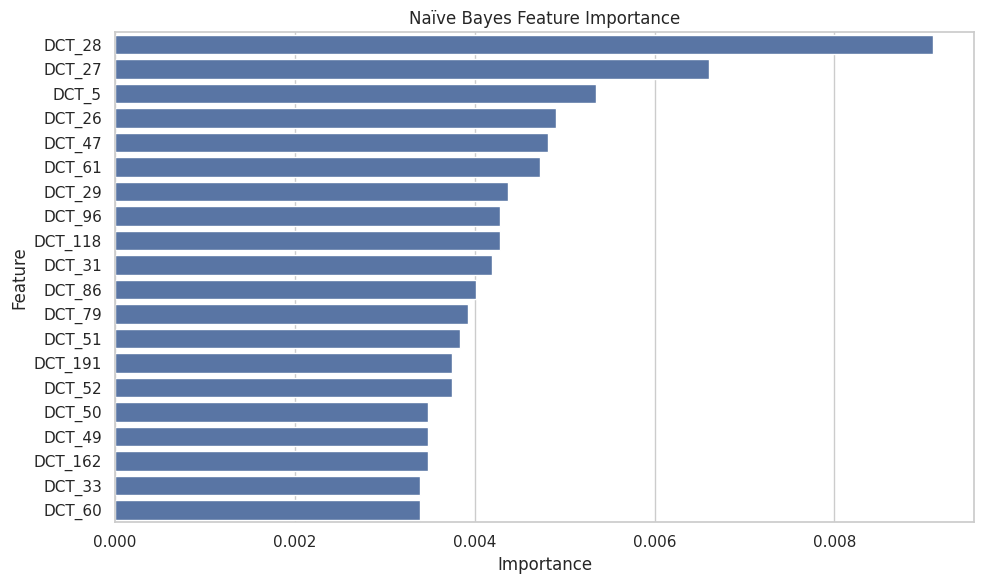

Top 20 features for Naïve Bayes:
     Feature  Importance
28    DCT_28    0.009099
27    DCT_27    0.006601
5      DCT_5    0.005352
26    DCT_26    0.004906
47    DCT_47    0.004817
61    DCT_61    0.004728
29    DCT_29    0.004371
96    DCT_96    0.004282
118  DCT_118    0.004282
31    DCT_31    0.004193
86    DCT_86    0.004014
79    DCT_79    0.003925
51    DCT_51    0.003836
191  DCT_191    0.003747
52    DCT_52    0.003747
50    DCT_50    0.003479
49    DCT_49    0.003479
162  DCT_162    0.003479
33    DCT_33    0.003390
60    DCT_60    0.003390

Comprehensive Model Performance Comparison:
                 Model CV Mean Score Test Accuracy Precision  Recall F1 Score                                                                        Best Params
7        Random Forest        0.7441        0.5727    0.5575  0.5727   0.5567                     {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
5              XGBoost        0.7496        0.5575    0.5432  0.5575   0.54

<ipython-input-27-b21b1cb756e8>:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df[col] = metrics_df[col].astype(float)
<ipython-input-27-b21b1cb756e8>:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df[col] = metrics_df[col].astype(float)
<ipython-input-27-b21b1cb756e8>:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

<Figure size 1400x1000 with 0 Axes>

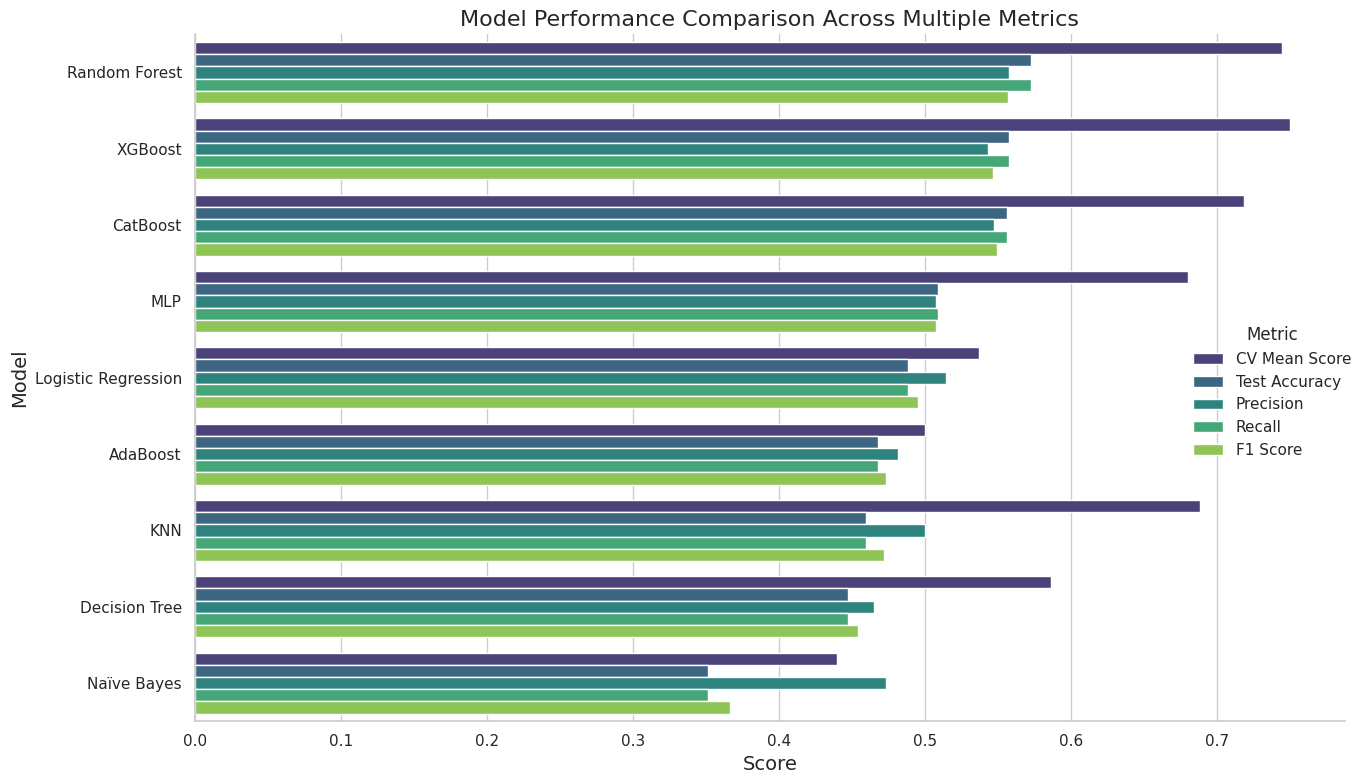


Best model: Random Forest with accuracy: 0.5727

Creating combined feature importance analysis...


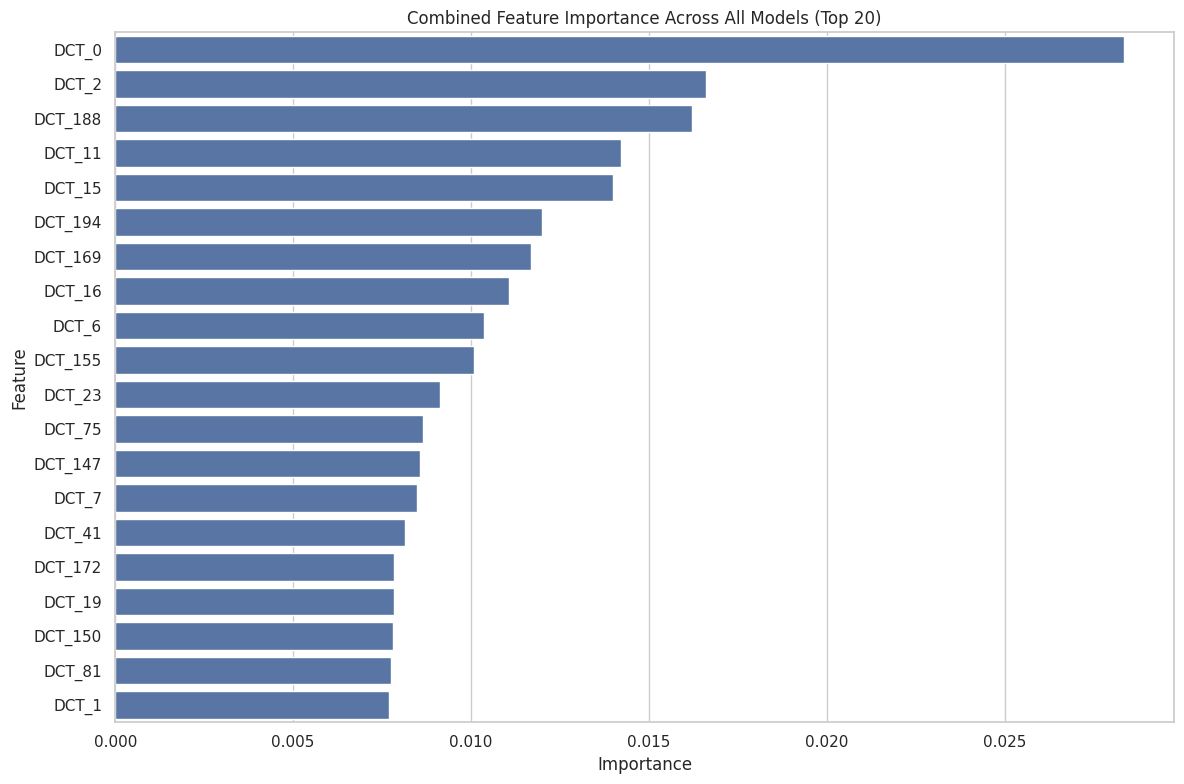

Top 20 features from combined analysis:
     Feature  Importance
0      DCT_0    0.028334
2      DCT_2    0.016600
188  DCT_188    0.016215
11    DCT_11    0.014212
15    DCT_15    0.013987
194  DCT_194    0.011984
169  DCT_169    0.011684
16    DCT_16    0.011072
6      DCT_6    0.010376
155  DCT_155    0.010073
23    DCT_23    0.009127
75    DCT_75    0.008641
147  DCT_147    0.008552
7      DCT_7    0.008479
41    DCT_41    0.008132
172  DCT_172    0.007829
19    DCT_19    0.007820
150  DCT_150    0.007800
81    DCT_81    0.007755
1      DCT_1    0.007687


In [27]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
accuracy_score, precision_score, recall_score, f1_score,
confusion_matrix, ConfusionMatrixDisplay
)
import shap

sns.set(style="whitegrid")

# ✅ Normalize filename function

def normalize_filename(name):
    name = name.strip().lower()
    name = os.path.splitext(name)[0]
    return re.sub(r"(\d+)s(\d+)", r"\1_s\2", name)

# Load pre-calculated DCT features from CSV file

dct_file = "/content/dct_mean_features (2).csv"
if not os.path.exists(dct_file):
    raise FileNotFoundError(f"DCT features file not found: {dct_file}")

dct_df = pd.read_csv(dct_file)

# Normalize filenames in the DCT features dataframe

dct_df["File Name"] = dct_df["File Name"].apply(normalize_filename)

# Read and normalize label files

print("Reading label files...")
excel_files = glob.glob("output_*_s.xlsx")
if not excel_files:
    raise FileNotFoundError("No Excel files found.")

labels_list = []
for excel_file in excel_files:
    try:
        df = pd.read_excel(excel_file)[["File Name", "Clarity"]]
        df["File Name"] = df["File Name"].astype(str).apply(normalize_filename)
        df["Clarity"] = df["Clarity"].astype(str).str.strip().str.title()
        df["Clarity"] = df["Clarity"].replace({
            "Medium Low": "Low",
            "Low Medium": "Medium",
            "High Medium": "High",
            "Lowhigh": "High",
            "Med": "Medium",
            "Mid": "Medium"
        })
        labels_list.append(df)
    except Exception as e:
        print(f"Error reading {excel_file}: {e}")

labels_df = pd.concat(labels_list, ignore_index=True)

# Merge features and labels

merged_data = dct_df.merge(labels_df, on="File Name", how="inner")

if merged_data.empty:
    unmatched = set(dct_df["File Name"]) - set(labels_df["File Name"])
    print("\nSample from DCT feature file names:", dct_df["File Name"].head())
    print("Sample from Label file names:", labels_df["File Name"].head())
    print(f"\nUnmatched file names: {list(unmatched)[:5]}")
    raise ValueError("No matching data found after merging features with labels.")

data = merged_data

# Prepare data

X = data.drop(columns=["File Name", "Clarity"])
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
X = X.select_dtypes(include=[np.number])

# Store feature names for importance plots

feature_names = X.columns.tolist()

le = LabelEncoder()
y = le.fit_transform(data["Clarity"])

# Class distribution plot

print("Visualizing class distribution...")
plt.figure(figsize=(6, 4))
sns.countplot(x=data["Clarity"])
plt.title("Class Distribution (Clarity Labels)")
plt.xlabel("Clarity")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Enhanced function to plot feature importance

def plot_feature_importance(importances, feature_names, title, top_n=20):
    # Create DataFrame for plotting
    feature_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Select top N features
    if len(feature_imp) > top_n:
        feature_imp = feature_imp.head(top_n)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_imp)
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return feature_imp

# Function to calculate permutation importance for models without built-in feature importance

def calculate_permutation_importance(model, X, y):
    perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42)
    return perm_importance.importances_mean

# Classifier config with feature importance support flag

classifiers = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7],
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan"]
        },
        "has_feature_importance": False  # Will use permutation importance
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "solver": ["lbfgs", "liblinear"]
        },
        "has_feature_importance": True  # Will extract coef_
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0]
        },
        "has_feature_importance": True  # Has feature_importances_
    },
    "CatBoost": {
        "model": CatBoostClassifier(verbose=0, random_state=42),
        "params": {
            "iterations": [100, 200],
            "depth": [4, 6, 8],
            "learning_rate": [0.01, 0.1]
        },
        "has_feature_importance": True  # Has feature_importances_
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        },
        "has_feature_importance": True  # Has feature_importances_
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1]
        },
        "has_feature_importance": True  # Has feature_importances_
    },
    "MLP": {
        "model": MLPClassifier(max_iter=500, random_state=42),
        "params": {
            "hidden_layer_sizes": [(50,), (100,), (50, 50)],
            "activation": ["relu", "tanh"],
            "learning_rate_init": [0.001, 0.01]
        },
        "has_feature_importance": False  # Will use permutation importance
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5]
        },
        "has_feature_importance": True  # Has feature_importances_
    },
    "Naïve Bayes": {
        "model": GaussianNB(),
        "params": {
            "var_smoothing": [1e-9, 1e-8, 1e-7]
        },
        "has_feature_importance": False  # Will use permutation importance
    }
}

# Split and SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Applying SMOTE to balance training data...")
print("Original class distribution:", np.bincount(y_train))
smote = SMOTE(random_state=42, k_neighbors=2)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print("Balanced class distribution:", np.bincount(y_train_balanced))

# Training & evaluation

print("\nTraining classifiers with hyperparameter tuning...")
results = []
best_model = None
best_accuracy = 0
best_model_name = ""
trained_models = {}

# Dictionary to store feature importance for all models

all_feature_importances = {}

for name, clf_info in classifiers.items():
    print(f"\nTraining {name}...")
    clf = clf_info["model"]
    param_grid = clf_info["params"]

    # Hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train_balanced, y_train_balanced)

    best_params = grid_search.best_params_
    best_clf = grid_search.best_estimator_
    best_score = grid_search.best_score_

    print(f"Best Params: {best_params}")
    print(f"Best Cross-Validation Score: {best_score}")

    # Evaluate on the test set
    y_pred = best_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate additional metrics - handle potential warnings for binary metrics with multi-class data
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=le.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {name}")
    plt.tight_layout()
    plt.show()

    # Calculate and store feature importance for all models
    print(f"Calculating feature importance for {name}...")
    if clf_info["has_feature_importance"]:
        if hasattr(best_clf, "feature_importances_"):
            # For tree-based models and ensemble methods
            importances = best_clf.feature_importances_
        elif hasattr(best_clf, "coef_"):
            # For linear models like Logistic Regression
            importances = np.abs(best_clf.coef_[0]) if len(best_clf.coef_.shape) > 1 else np.abs(best_clf.coef_)
        else:
            # Fallback to permutation importance
            importances = calculate_permutation_importance(best_clf, X_test, y_test)
    else:
        # Use permutation importance for models that don't have built-in feature importance
        importances = calculate_permutation_importance(best_clf, X_test, y_test)

    # Store the feature importance
    all_feature_importances[name] = importances

    # Plot feature importance for each model
    importance_df = plot_feature_importance(importances, feature_names, f"{name} Feature Importance", top_n=20)
    print(f"Top 20 features for {name}:")
    print(importance_df)

    # Track the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = name
        best_model = best_clf

    results.append({
        'Model': name,
        'Best Params': best_params,
        'CV Mean Score': best_score,
        'Test Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

# Create comprehensive comparison table
results_df = pd.DataFrame(results)

# Reorder columns for better readability
column_order = ['Model', 'CV Mean Score', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score', 'Best Params']
results_df = results_df[column_order]

# Sort by test accuracy descending
results_df = results_df.sort_values(by='Test Accuracy', ascending=False)

# Format numeric columns to show 4 decimal places
for col in ['CV Mean Score', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score']:
    if col in results_df.columns:
        results_df[col] = results_df[col].map('{:.4f}'.format)

print("\nComprehensive Model Performance Comparison:")
print(results_df.to_string())

# Create a visual comparison of model performance metrics
metrics_df = results_df[['Model', 'CV Mean Score', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score']]

# Convert back to float for plotting
for col in ['CV Mean Score', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score']:
    metrics_df[col] = metrics_df[col].astype(float)

# Melt the dataframe for better plotting
metrics_melted = pd.melt(metrics_df, id_vars=['Model'],
                         value_vars=['CV Mean Score', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score'],
                         var_name='Metric', value_name='Score')

# Plot horizontal bar chart grouped by model
plt.figure(figsize=(14, 10))
g = sns.catplot(
    data=metrics_melted,
    kind="bar",
    x="Score", y="Model", hue="Metric",
    palette="viridis",
    height=8, aspect=1.5
)
plt.title("Model Performance Comparison Across Multiple Metrics", fontsize=16)
plt.xlabel("Score", fontsize=14)
plt.ylabel("Model", fontsize=14)
plt.tight_layout()
plt.show()

print(f"\nBest model: {best_model_name} with accuracy: {best_accuracy:.4f}")

# Optionally: Create a combined plot of top features across all models

print("\nCreating combined feature importance analysis...")

# Aggregate feature importances across all models

combined_importances = {}
for feature in feature_names:
    combined_importances[feature] = 0

for model_name, importances in all_feature_importances.items():
    for feature, importance in zip(feature_names, importances):
        combined_importances[feature] += importance

# Normalize the combined importance

total_importance = sum(combined_importances.values())
if total_importance > 0:  # Avoid division by zero
    for feature in combined_importances:
        combined_importances[feature] /= total_importance

# Create a DataFrame for the combined importance

combined_imp_df = pd.DataFrame({
    'Feature': list(combined_importances.keys()),
    'Importance': list(combined_importances.values())
}).sort_values(by='Importance', ascending=False)

# Plot the top 20 features from the combined analysis

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=combined_imp_df.head(20))
plt.title("Combined Feature Importance Across All Models (Top 20)")
plt.tight_layout()
plt.show()

print("Top 20 features from combined analysis:")
print(combined_imp_df.head(20))

In [22]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e1dbf5f91440a11efb3870277fe60b0f828b37220c7badcdee2fa5605d197f1b
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


Applying SMOTE to balance training data...

Training Random Forest with hyperparameter tuning...
Best parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score: 0.7441
Test accuracy: 0.5727


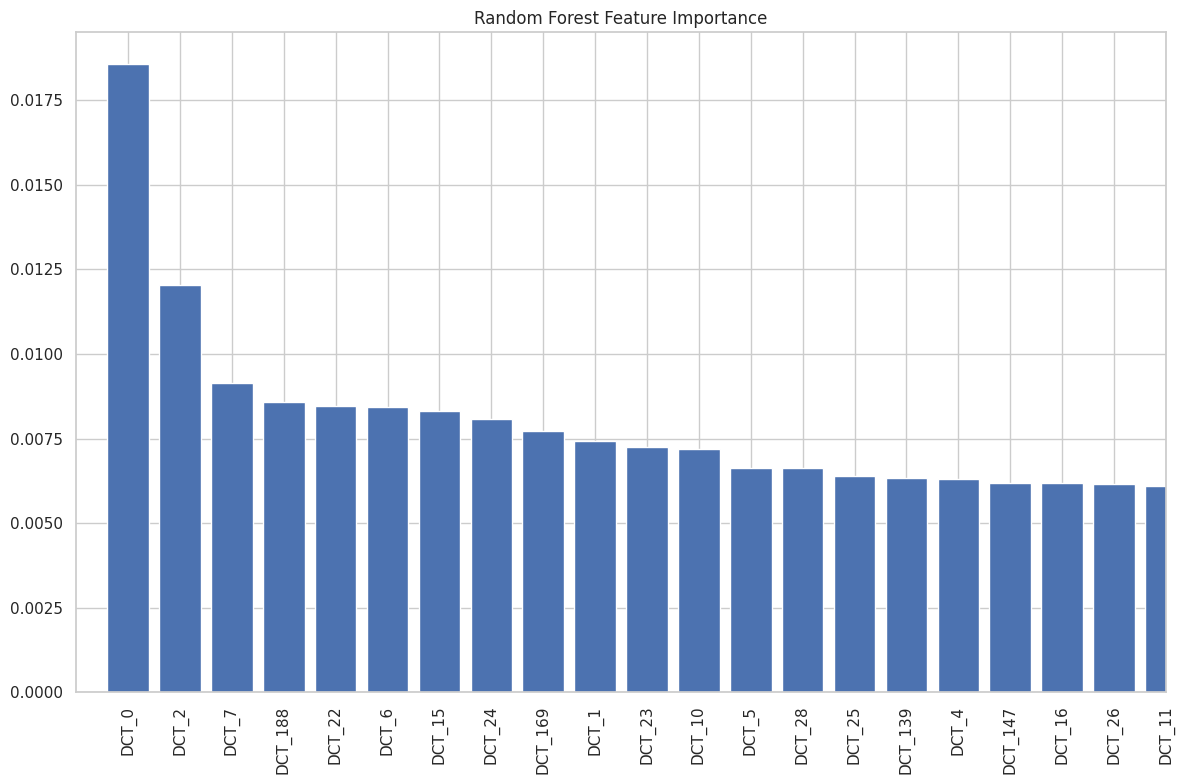


LIME interpretation for Random Forest
Generating LIME explanations for 5 test instances...

LIME Explanation for Test Instance 1:
Actual class: Medium
Model prediction: Low

Explanation for predicted class: Low
  DCT_2 > 0.70: 0.0221
  -0.13 < DCT_0 <= 0.22: 0.0218
  DCT_169 > 0.54: 0.0183
  DCT_23 > 0.62: 0.0117
  DCT_15 > 0.64: 0.0114
  DCT_24 <= -0.67: -0.0096
  DCT_22 <= -0.68: -0.0092
  DCT_5 > 0.50: 0.0091
  DCT_147 > 0.55: 0.0066
  DCT_180 <= -0.49: 0.0063


<Figure size 1000x600 with 0 Axes>

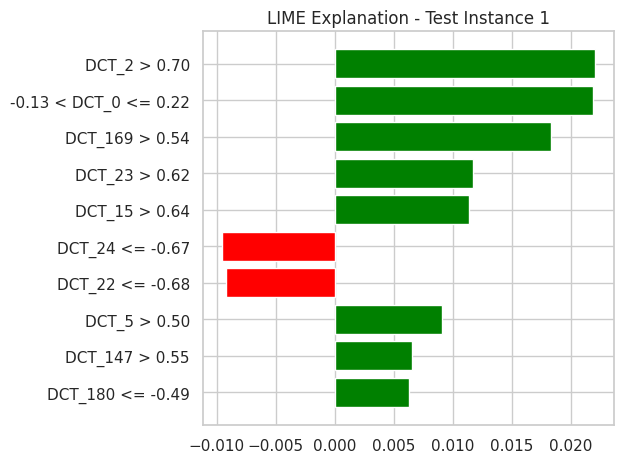


LIME Explanation for Test Instance 2:
Actual class: Low
Model prediction: Medium

Explanation for predicted class: Medium
  DCT_0 > 0.48: 0.0145
  DCT_6 <= -0.66: 0.0102
  DCT_24 <= -0.67: 0.0099
  DCT_169 <= -0.51: 0.0058
  DCT_30 <= -0.58: -0.0047
  DCT_155 > 0.50: 0.0043
  DCT_53 > 0.54: 0.0036
  -0.08 < DCT_34 <= 0.58: -0.0031
  -0.50 < DCT_172 <= 0.02: -0.0027
  DCT_40 > 0.52: -0.0027


<Figure size 1000x600 with 0 Axes>

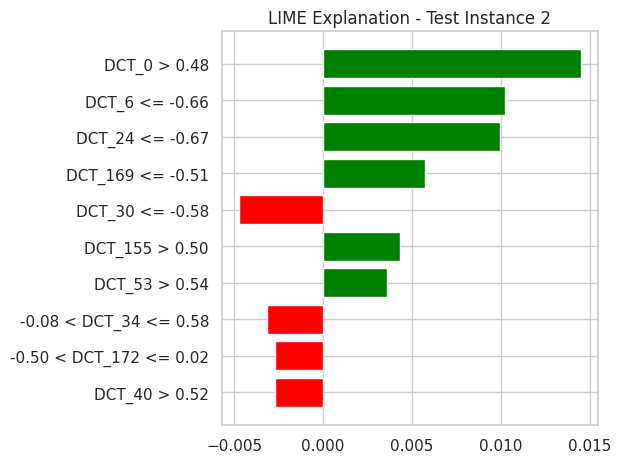


LIME Explanation for Test Instance 3:
Actual class: Medium
Model prediction: High

Explanation for predicted class: High
  DCT_0 > 0.48: 0.0177
  DCT_188 <= -0.51: 0.0075
  DCT_7 <= -0.62: 0.0069
  DCT_15 <= -0.66: 0.0062
  DCT_25 <= -0.63: 0.0055
  DCT_103 <= -0.56: -0.0053
  DCT_191 <= -0.52: 0.0052
  DCT_170 > 0.47: -0.0052
  DCT_195 > 0.49: -0.0049
  DCT_115 > 0.55: 0.0045


<Figure size 1000x600 with 0 Axes>

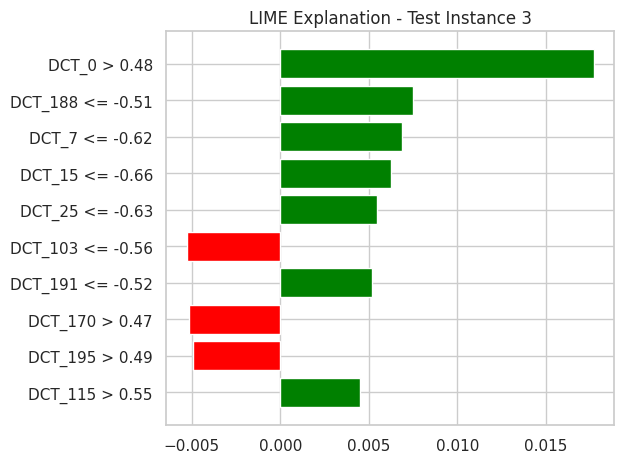


LIME Explanation for Test Instance 4:
Actual class: Low
Model prediction: Low

Explanation for predicted class: Low
  DCT_0 <= -0.13: 0.0376
  DCT_7 > 0.56: 0.0183
  DCT_6 > 0.67: 0.0131
  DCT_23 > 0.62: 0.0099
  DCT_2 <= -0.69: -0.0085
  DCT_15 > 0.64: 0.0085
  DCT_100 > 0.63: 0.0069
  DCT_197 > 0.53: 0.0067
  -0.51 < DCT_169 <= -0.04: -0.0059
  DCT_20 > 0.60: 0.0055


<Figure size 1000x600 with 0 Axes>

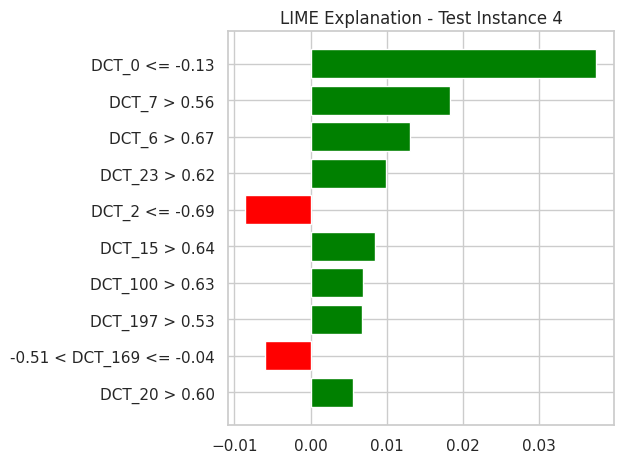


LIME Explanation for Test Instance 5:
Actual class: Medium
Model prediction: Medium

Explanation for predicted class: Medium
  DCT_0 > 0.48: 0.0163
  DCT_24 <= -0.67: 0.0095
  DCT_6 <= -0.66: 0.0092
  DCT_23 > 0.62: -0.0067
  DCT_30 <= -0.58: -0.0050
  -0.51 < DCT_169 <= -0.04: 0.0047
  -0.63 < DCT_34 <= -0.08: 0.0045
  DCT_126 > 0.57: -0.0043
  -0.27 < DCT_1 <= 0.06: 0.0040
  DCT_195 > 0.49: 0.0034


<Figure size 1000x600 with 0 Axes>

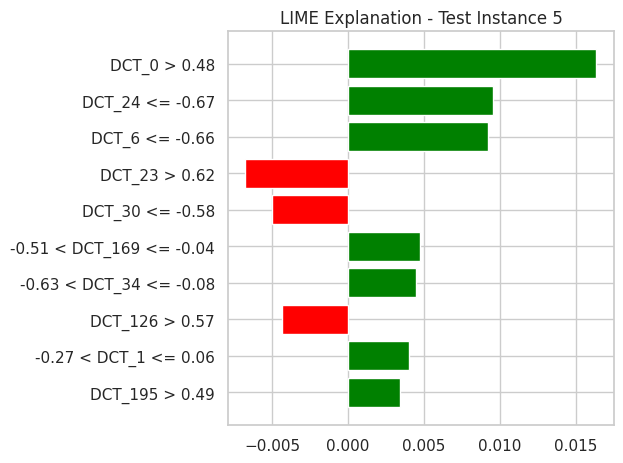


LIME analysis complete!


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from lime import lime_tabular

# Assuming you've already loaded and preprocessed your data
# X = your_features
# y = your_labels (encoded with LabelEncoder)
# feature_names = list of feature names

# For demonstration purposes, I'll include the data loading code
# If you already have X, y, and le (LabelEncoder) defined, you can skip this part
def load_data():
    # Replace this with your actual data loading process
    dct_file = "/content/dct_mean_features (2).csv"
    dct_df = pd.read_csv(dct_file)
    # Merge with labels and preprocess
    # ...

    # For demonstration purposes:
    X = data.drop(columns=["File Name", "Clarity"])
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
    X = X.select_dtypes(include=[np.number])

    feature_names = X.columns.tolist()

    le = LabelEncoder()
    y = le.fit_transform(data["Clarity"])

    return X, y, feature_names, le

# Load data
# X, y, feature_names, le = load_data()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to balance training data
print("Applying SMOTE to balance training data...")
smote = SMOTE(random_state=42, k_neighbors=2)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Scale features
scaler = StandardScaler()
X_train_balanced_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest with hyperparameter tuning
print("\nTraining Random Forest with hyperparameter tuning...")
rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}

rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train_balanced_scaled, y_train_balanced)

best_rf = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate on test set
y_pred = best_rf.predict(X_test_scaled)
accuracy = np.mean(y_pred == y_test)
print(f"Test accuracy: {accuracy:.4f}")

# Feature importance for Random Forest
plt.figure(figsize=(12, 8))
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.title('Random Forest Feature Importance')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, min(20, len(importances))])
plt.tight_layout()
plt.show()

# LIME interpretation for Random Forest
print("\n" + "="*50)
print("LIME interpretation for Random Forest")

# Get class names
class_names = le.classes_.tolist()

# Create LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    X_train_balanced_scaled,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

# Number of test instances to explain
num_samples_to_explain = min(5, len(X_test))
print(f"Generating LIME explanations for {num_samples_to_explain} test instances...")

for i in range(num_samples_to_explain):
    print(f"\nLIME Explanation for Test Instance {i+1}:")
    print(f"Actual class: {class_names[y_test[i]]}")

    # Generate explanation
    explanation = explainer.explain_instance(
        X_test_scaled[i],
        best_rf.predict_proba,
        num_features=10,
        top_labels=len(class_names)
    )

    # Print text explanation
    predicted_class = best_rf.predict([X_test_scaled[i]])[0]
    print(f"Model prediction: {class_names[predicted_class]}")

    # Show the explanation for the predicted class
    print(f"\nExplanation for predicted class: {class_names[predicted_class]}")
    for feature, weight in explanation.as_list(label=predicted_class):
        print(f"  {feature}: {weight:.4f}")

    # Plot the explanation
    plt.figure(figsize=(10, 6))
    explanation.as_pyplot_figure(label=predicted_class)
    plt.title(f"LIME Explanation - Test Instance {i+1}")
    plt.tight_layout()
    plt.show()

print("\nLIME analysis complete!")

LPC without smote

In [ ]:
import librosa
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

sns.set(style="whitegrid")
mfcc_df = pd.read_csv("/content/lpc_mean_features (1).csv")
if mfcc_df.empty:
    raise ValueError("MFCC feature file is empty or not loaded correctly.")
# Load label files
print("Reading label files...")
excel_files = glob.glob("output_*_s.xlsx")
if not excel_files:
    raise FileNotFoundError("No Excel files found.")

labels_list = []
for excel_file in excel_files:
    try:
        df = pd.read_excel(excel_file)[["File Name", "Clarity"]]
        df["File Name"] = df["File Name"].astype(str).apply(normalize_filename)
        df["Clarity"] = df["Clarity"].astype(str).str.strip().str.title()
        df["Clarity"] = df["Clarity"].replace({
            "Medium Low": "Low",
            "Low Medium": "Medium",
            "High Medium": "High",
            "Lowhigh": "High",
            "Med": "Medium",
            "Mid": "Medium"
        })
        labels_list.append(df)
    except Exception as e:
        print(f"Error reading {excel_file}: {e}")

labels_df = pd.concat(labels_list, ignore_index=True)

# Merge and validate
lpc_df["File Name"] = lpc_df["File Name"].astype(str).apply(normalize_filename)
merged_data = lpc_df.merge(labels_df, on="File Name", how="inner")
if merged_data.empty:
    unmatched = set(lpc_df["File Name"]) - set(labels_df["File Name"])
    print("Sample unmatched files:", list(unmatched)[:5])
    raise ValueError("No matching data found after merging features with labels.")

data = merged_data

# Prepare features and labels
X = data.drop(columns=["File Name", "Clarity"])
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
X = X.select_dtypes(include=[np.number])
le = LabelEncoder()
y = le.fit_transform(data["Clarity"])

# Visualize class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=data["Clarity"])
plt.title("Class Distribution (Clarity Labels)")
plt.xlabel("Clarity")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Classifiers and hyperparameters
classifiers = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5],
            "weights": ["uniform", "distance"]
        }
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            "C": [0.1, 1],
            "solver": ["lbfgs"]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100]
        }
    },
    "CatBoost": {
        "model": CatBoostClassifier(verbose=0, random_state=42),
        "params": {
            "iterations": [100],
            "depth": [4, 6],
            "learning_rate": [0.1]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "max_depth": [None, 10]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        "params": {
            "n_estimators": [100],
            "max_depth": [3, 5]
        }
    },
    "MLP": {
        "model": MLPClassifier(max_iter=500, random_state=42),
        "params": {
            "hidden_layer_sizes": [(50,), (100,)],
            "activation": ["relu"],
            "learning_rate_init": [0.001]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100],
            "max_depth": [None]
        }
    },
    "Naïve Bayes": {
        "model": GaussianNB(),
        "params": {
            "var_smoothing": [1e-9, 1e-8]
        }
    }
}

# Split data (No SMOTE applied here)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train and evaluate
results = []
for name, clf_info in classifiers.items():
    try:
        print(f"\n{name} Performance:")
        clf = clf_info["model"]
        param_grid = clf_info["params"]

        if name == "CatBoost":
            X_train = np.array(X_train)
            X_test = np.array(X_test)

        grid_search = GridSearchCV(
            estimator=clf,
            param_grid=param_grid,
            cv=5,
            scoring="accuracy",
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        best_clf = grid_search.best_estimator_

        print("Best Parameters:", grid_search.best_params_)

        y_train_pred = best_clf.predict(X_train)
        y_test_pred = best_clf.predict(X_test)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred, average='weighted')
        precision = precision_score(y_test, y_test_pred, average='weighted')
        recall = recall_score(y_test, y_test_pred, average='weighted')

        results.append((name, train_acc, test_acc, precision, recall, f1))

        target_names = le.inverse_transform(np.unique(np.concatenate([y_test, y_test_pred])))

        ConfusionMatrixDisplay.from_predictions(
            y_test, y_test_pred,
            display_labels=target_names,
            cmap="Blues",
            values_format='d'
        )
        plt.title(f"{name} - Confusion Matrix")
        plt.grid(False)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error training {name}: {e}")

# Plot results
results_df = pd.DataFrame(results, columns=["Model", "Train Accuracy", "Test Accuracy", "Precision", "Recall", "F1 Score"])
plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="Test Accuracy", data=results_df.sort_values(by="Test Accuracy", ascending=False))
plt.xticks(rotation=45)
plt.title("Classifier Test Accuracy Comparison (LPC) without SMOTE")
plt.tight_layout()
plt.show()

print("\nFinal Metrics Comparison Table (LPC without SMOTE):")
print(results_df.to_string(index=False))

lpc_df.to_csv("lpc_mean_features_without_smote.csv", index=False)
print("\nLPC mean values saved to 'lpc_mean_features_without_smote.csv'")

excel_output_path = "lpc_classifier.xlsx"
results_df.to_excel(excel_output_path, index=False)
print(f"\nAll classifier performance metrics saved to '{excel_output_path}'")


lpc with smote

In [ ]:
import librosa
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

sns.set(style="whitegrid")
mfcc_df = pd.read_csv("/content/lpc_mean_features (1).csv")
if mfcc_df.empty:
    raise ValueError("MFCC feature file is empty or not loaded correctly.")
# Load and process label files
print("Reading label files...")
excel_files = glob.glob("output_*_s.xlsx")
if not excel_files:
    raise FileNotFoundError("No Excel files found.")

labels_list = []
for excel_file in excel_files:
    try:
        df = pd.read_excel(excel_file)[["File Name", "Clarity"]]
        df["File Name"] = df["File Name"].astype(str).str.strip().str.lower()
        df["File Name"] = df["File Name"].apply(lambda x: re.sub(r"(\d+)s(\d+)", r"\1_s\2", x))
        df["File Name"] = df["File Name"].apply(lambda x: re.sub(r"[\s\-]+", "_", x))
        df["Clarity"] = df["Clarity"].astype(str).str.strip().str.lower()
        df["Clarity"] = df["Clarity"].replace({
            "clear": "clear",
            "not clear": "not clear",
            "unclear": "not clear",
            "uncleared": "not clear",
            "un clear": "not clear"
        })
        labels_list.append(df)
    except Exception as e:
        print(f"Error reading {excel_file}: {e}")

labels_df = pd.concat(labels_list, ignore_index=True)

# Merge and validate
lpc_df["File Name"] = lpc_df["File Name"].astype(str).str.strip().str.lower()
merged_data = lpc_df.merge(labels_df, on="File Name", how="inner")
if merged_data.empty:
    unmatched = set(lpc_df["File Name"]) - set(labels_df["File Name"])
    print("Sample unmatched files:", list(unmatched)[:5])
    raise ValueError("No matching data found after merging features with labels.")

data = merged_data

# Prepare features and labels
X = data.drop(columns=["File Name", "Clarity"])
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
X = X.select_dtypes(include=[np.number])
le = LabelEncoder()
y = le.fit_transform(data["Clarity"])

# Visualize class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=data["Clarity"])
plt.title("Class Distribution (Clarity Labels)")
plt.xlabel("Clarity")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Classifiers and hyperparameters
classifiers = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5],
            "weights": ["uniform", "distance"]
        }
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            "C": [0.1, 1],
            "solver": ["lbfgs"]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100]
        }
    },
    "CatBoost": {
        "model": CatBoostClassifier(verbose=0, random_state=42),
        "params": {
            "iterations": [100],
            "depth": [4, 6],
            "learning_rate": [0.1]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "max_depth": [None, 10]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        "params": {
            "n_estimators": [100],
            "max_depth": [3, 5]
        }
    },
    "MLP": {
        "model": MLPClassifier(max_iter=500, random_state=42),
        "params": {
            "hidden_layer_sizes": [(50,), (100,)],
            "activation": ["relu"],
            "learning_rate_init": [0.001]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100],
            "max_depth": [None]
        }
    },
    "Naïve Bayes": {
        "model": GaussianNB(),
        "params": {
            "var_smoothing": [1e-9, 1e-8]
        }
    }
}

# Split and apply SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Applying SMOTE...")
smote = SMOTE(random_state=42, k_neighbors=2)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Train and evaluate
results = []
for name, clf_info in classifiers.items():
    try:
        print(f"\n{name} Performance:")
        clf = clf_info["model"]
        param_grid = clf_info["params"]

        if name == "CatBoost":
            X_train_balanced = np.array(X_train_balanced)
            X_test = np.array(X_test)

        grid_search = GridSearchCV(
            estimator=clf,
            param_grid=param_grid,
            cv=5,
            scoring="accuracy",
            n_jobs=-1
        )
        grid_search.fit(X_train_balanced, y_train_balanced)
        best_clf = grid_search.best_estimator_

        print("Best Parameters:", grid_search.best_params_)

        y_train_pred = best_clf.predict(X_train_balanced)
        y_test_pred = best_clf.predict(X_test)

        train_acc = accuracy_score(y_train_balanced, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred, average='weighted')
        precision = precision_score(y_test, y_test_pred, average='weighted')
        recall = recall_score(y_test, y_test_pred, average='weighted')

        results.append((name, train_acc, test_acc, precision, recall, f1))

        target_names = le.inverse_transform(np.unique(np.concatenate([y_test, y_test_pred])))
        ConfusionMatrixDisplay.from_predictions(
            y_test, y_test_pred,
            display_labels=target_names,
            cmap="Blues",
            values_format='d'
        )
        plt.title(f"{name} - Confusion Matrix")
        plt.grid(False)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error training {name}: {e}")

# Plot results
results_df = pd.DataFrame(results, columns=["Model", "Train Accuracy", "Test Accuracy", "Precision", "Recall", "F1 Score"])
plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="Test Accuracy", data=results_df.sort_values(by="Test Accuracy", ascending=False))
plt.xticks(rotation=45)
plt.title("Classifier Test Accuracy Comparison (LPC)")
plt.tight_layout()
plt.show()

print("\nFinal Metrics Comparison Table (LPC):")
print(results_df.to_string(index=False))

lpc_df.to_csv("lpc_mean_features.csv", index=False)
print("\nLPC mean values saved to 'lpc_mean_features.csv'")

excel_output_path = "lpc_s_classifier.xlsx"
results_df.to_excel(excel_output_path, index=False)
print(f"\nAll classifier performance metrics saved to '{excel_output_path}'")


In [16]:
from google.colab import files

files_to_download = ['mfcc_smote_classifier_results.xlsx']

for file in files_to_download:
    try:
        files.download(file)
        print(f"Downloading: {file}")
    except Exception as e:
        print(f"Error downloading {file}: {e}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: mfcc_smote_classifier_results.xlsx
